## All Imports

In [127]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
from scipy.stats import entropy
import airr
import json
import itertools
from kneed import KneeLocator
from itertools import combinations

In [128]:
hannanlab_dir = '/mnt/md0/Projects/HannanLab/KidneyTCR/'
vdjpipe_dir_33 = hannanlab_dir + '9251db8a-f7ec-45a6-8f3b-79f25232154c-007/' #
vdjpipe_dir_34 = hannanlab_dir + '6c3d5355-4429-4431-be5b-51162af8b849-007/' #91ca4180-37bd-4d93-aa7b-4425deee0b95
igblast_dir = hannanlab_dir + '0c31b9fc-9732-4eb0-acf9-67b015a0e12d-007/'

# Specify the directory path where you would like to save your figures
fig_dir = 'Figures/'
# Create the directory if it doesn't exist
os.makedirs(fig_dir, exist_ok=True)
print(f"Directory '{fig_dir}' is created or already exists.")

Directory 'Figures/' is created or already exists.


## Read the repertoire File for Kidney Samples

In [129]:
info_list = []
data = airr.read_airr('repertoires.airr.json')
for rep in data['Repertoire']:
    # print(json.dumps(rep['sample'], indent = 4))
    repertoire_id = rep.get("repertoire_id", None)
    subject_id = rep.get("subject", {}).get('subject_id', None)
    sample_id = rep.get("sample", [{}])[0].get('sample_id', None)
    age = rep.get("subject", {}).get('age_min', None)
    ethnicity = rep.get("subject", {}).get('ethnicity', None)
    race = rep.get("subject", {}).get('race', None)
    
    diagnosis = rep.get("subject", {}).get('diagnosis', [{}])[0].get('study_group_description', None)
    tissue = rep.get("sample", [{}])[0].get('tissue', {}).get('label', None)
    library = rep.get("sample", [{}])[0].get('sequencing_run_id', None)
    disease_state = rep.get("sample", [])[0].get('disease_state_sample', None)
    info_list.append({'repertoire_id': repertoire_id,
                      'subject_id': subject_id,
                      'sample_id': sample_id.replace(" ", ""), # Removing the space between pbmc and the number to match with filename.
                      'age': age, 
                      'ethnicity': ethnicity, 
                      'race':race, 
                      'tissue': tissue,
                      'disease_state': disease_state,
                      'library': library,
                      'diagnosis': diagnosis
                     })
sample_info_df = pd.DataFrame(info_list)
print(sample_info_df.head())


                          repertoire_id subject_id sample_id  age  \
0  5a97e753-a55a-4770-b831-df315327a5c5        101     101-1   41   
1  0528150f-f217-4273-a5b7-bf5091b60ac0        101     101-2   41   
2  fa3f6632-41cc-44b1-a28a-830352f22934        101     101-3   41   
3  3968dec2-f220-47dd-85e3-5a436031a8d8        103     103-1   39   
4  2e11be30-1ff8-48fb-9b93-469d5f1d1909        103     103-2   39   

      ethnicity              race  tissue disease_state     library diagnosis  
0      Hispanic             White  kidney     non-tumor  library_33    cancer  
1      Hispanic             White  kidney         tumor  library_33    cancer  
2      Hispanic             White  kidney         tumor  library_33    cancer  
3  Non-Hispanic  African American  kidney     non-tumor  library_33    cancer  
4  Non-Hispanic  African American  kidney     non-tumor  library_33    cancer  


In [122]:
sample_info_df.subject_id.nunique()

21

## Read VDJPipe Summary File

In [4]:
#read vdjpipe summary
vdj_pipe_33 = pd.read_csv(f'{vdjpipe_dir_33}/vdjpipe_summary.csv')
vdj_pipe_34 = pd.read_csv(f'{vdjpipe_dir_34}/vdjpipe_summary.csv')
#separate sample_id from filename
vdj_pipe_33['sample_id'] = vdj_pipe_33['file'].str.split('_').str[0]
vdj_pipe_34['sample_id'] = vdj_pipe_34['file'].str.split('_').str[0]

#separate subject/patient id for later calculation
vdj_pipe_33['patient_id'] = vdj_pipe_33['sample_id'].str.split('-').str[0]
vdj_pipe_34['patient_id'] = vdj_pipe_34['sample_id'].str.split('-').str[0]

#calculating percentage of reads that passed the filter
vdj_pipe_33['% Pass'] = (vdj_pipe_33['filtered reads'] / vdj_pipe_33['merged reads']) * 100
vdj_pipe_34['% Pass'] = (vdj_pipe_34['filtered reads'] / vdj_pipe_34['merged reads']) * 100
#calculating percentage of unique reads
vdj_pipe_33['% Unique'] = (vdj_pipe_33['unique reads'] / vdj_pipe_33['filtered reads']) * 100
vdj_pipe_34['% Unique'] = (vdj_pipe_34['unique reads'] / vdj_pipe_34['filtered reads']) * 100

vdj_pipe_combined = pd.concat([vdj_pipe_33, vdj_pipe_34])
vdj_pipe_combined = vdj_pipe_combined.reset_index(drop = True)
vdj_pipe_combined.head()

file  input reads  merged reads  \
0  101-1_S1_R1_001.fastq.merged.summary.txt       214480        214479   
1  101-2_S2_R1_001.fastq.merged.summary.txt       254703        254701   
2  101-3_S3_R1_001.fastq.merged.summary.txt       243155        243154   
3  103-1_S4_R1_001.fastq.merged.summary.txt       132744        132744   
4  103-2_S5_R1_001.fastq.merged.summary.txt       315607        315606   

   length_filter  quality_filter  homopolymer_filter  match1  match2  match3  \
0         133816           34757                 367     NaN     NaN     NaN   
1         192344           33279                 767     NaN     NaN     NaN   
2         193176           30669                 731     NaN     NaN     NaN   
3         110095           21463                 376     NaN     NaN     NaN   
4         263594           39058                1118     NaN     NaN     NaN   

   filtered reads  unique reads sample_id patient_id     % Pass   % Unique  
0           59615         50425     101-1        101  27.795262  84.584417  
1           46991         41965     101-2        101  18.449476  89.304335  
2           37115         32553     101-3        101  15.263989  87.708474  
3           14716         13049     103-1        103  11.086000  88.672194  
4           37992         33327     103-2        103  12.037794  87.721099

## Combine All Stat Files

In [6]:
#read igblast stat file
igblast_combined = pd.read_csv(f'{igblast_dir}/igblast_count_statistics.csv')
igblast_combined['repertoire_id'] = igblast_combined['file'].str.split('.').str[0]
igblast_combined['% productive'] = (igblast_combined['productive records'] / igblast_combined['total records']) * 100


sample_info_combined = sample_info_df.merge(igblast_combined, on = ['repertoire_id'], how = 'inner')
sample_info_combined = sample_info_combined.merge(vdj_pipe_combined, on = ['sample_id'], how = 'inner')
sample_info_combined.drop(['file_x', 'file_y', 'match1', 'match2', 'match3'], axis = 1, inplace = True)
sample_info_combined

repertoire_id subject_id   sample_id  age  \
0   5a97e753-a55a-4770-b831-df315327a5c5        101       101-1   41   
1   0528150f-f217-4273-a5b7-bf5091b60ac0        101       101-2   41   
2   fa3f6632-41cc-44b1-a28a-830352f22934        101       101-3   41   
3   3968dec2-f220-47dd-85e3-5a436031a8d8        103       103-1   39   
4   2e11be30-1ff8-48fb-9b93-469d5f1d1909        103       103-2   39   
..                                   ...        ...         ...  ...   
93  808a7f78-c26c-40b5-9b36-f23906acce37        124  124-14PBMC   53   
94  0389983e-4fae-4ae1-9469-1d0960d79dcb        125  125-15PBMC   60   
95  e7271374-0351-42ff-857e-660d98b0e5b8        125  125-16PBMC   60   
96  3dc83954-4437-4fe4-b157-f568b0ebda15        120  120-17PBMC   81   
97  38e55358-5ed6-4262-bf1b-b108e23daf2b        120  120-18PBMC   81   

       ethnicity              race  tissue disease_state     library  \
0       Hispanic             White  kidney     non-tumor  library_33   
1       Hispanic             White  kidney         tumor  library_33   
2       Hispanic             White  kidney         tumor  library_33   
3   Non-Hispanic  African American  kidney     non-tumor  library_33   
4   Non-Hispanic  African American  kidney     non-tumor  library_33   
..           ...               ...     ...           ...         ...   
93  Non-Hispanic             White   blood     kidney CA  library_34   
94  Non-Hispanic             White   blood     kidney CA  library_34   
95  Non-Hispanic             White   blood     kidney CA  library_34   
96  Non-Hispanic             White   blood     kidney CA  library_34   
97  Non-Hispanic             White   blood     kidney CA  library_34   

   diagnosis  ...  input reads  merged reads  length_filter  quality_filter  \
0     cancer  ...       214480        214479         133816           34757   
1     cancer  ...       254703        254701         192344           33279   
2     cancer  ...       243155        243154         193176           30669   
3     cancer  ...       132744        132744         110095           21463   
4     cancer  ...       315607        315606         263594           39058   
..       ...  ...          ...           ...            ...             ...   
93    cancer  ...       155949        155946          91130            7510   
94    cancer  ...       376166        376165         163637           25823   
95    cancer  ...       764925        764919         561380           29922   
96    cancer  ...       698638        698629         343834           40850   
97    cancer  ...       545416        545410         389307           27831   

    homopolymer_filter  filtered reads  unique reads  patient_id     % Pass  \
0                  367           59615         50425         101  27.795262   
1                  767           46991         41965         101  18.449476   
2                  731           37115         32553         101  15.263989   
3                  376           14716         13049         103  11.086000   
4                 1118           37992         33327         103  12.037794   
..                 ...             ...           ...         ...        ...   
93                 282           58754         47275         124  37.675862   
94                 568          190587        151563         125  50.665798   
95                1742          184353        130794         125  24.100983   
96                1390          320623        238887         120  45.893171   
97                1087          136929        100251         120  25.105700   

     % Unique  
0   84.584417  
1   89.304335  
2   87.708474  
3   88.672194  
4   87.721099  
..        ...  
93  80.462607  
94  79.524312  
95  70.947584  
96  74.507131  
97  73.213855  

[98 rows x 27 columns]

In [7]:
# igblast_combined[igblast_combined['productive records'] < 500]
# sample_info_combined[sample_info_combined.subject_id == '109']

## Plot Age Distribution of The Samples

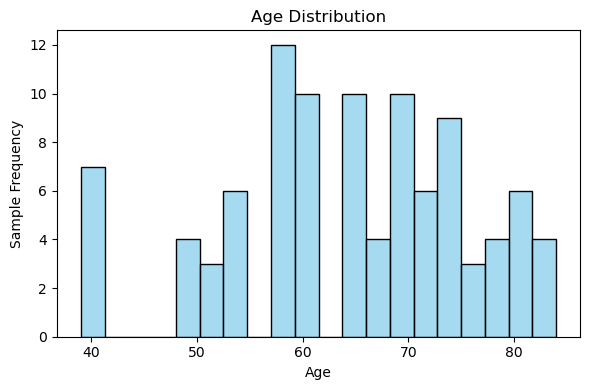

In [104]:
df = sample_info_combined.copy()
plt.figure(figsize=(6, 4))
sns.histplot(df['age'], bins=20,  color='skyblue')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Sample Frequency')
plt.tight_layout()
figname = fig_dir + 'age_distribution.png'
# plt.savefig(figname, bbox_inches = 'tight', dpi = 300)
plt.show()

## Plot Race Distribution of The Samples

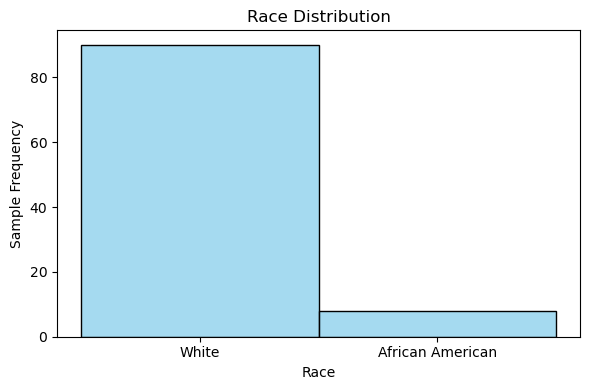

In [105]:
df = sample_info_combined.copy()
plt.figure(figsize=(6, 4))
sns.histplot(data = df, x = 'race', bins=20, color='skyblue')
plt.title('Race Distribution')
plt.xlabel('Race')
plt.ylabel('Sample Frequency')
plt.tight_layout()

plt.show()

## VDJPipe Summary For Kidney Tissue Samples Only

Number of Tissue Samples:  80


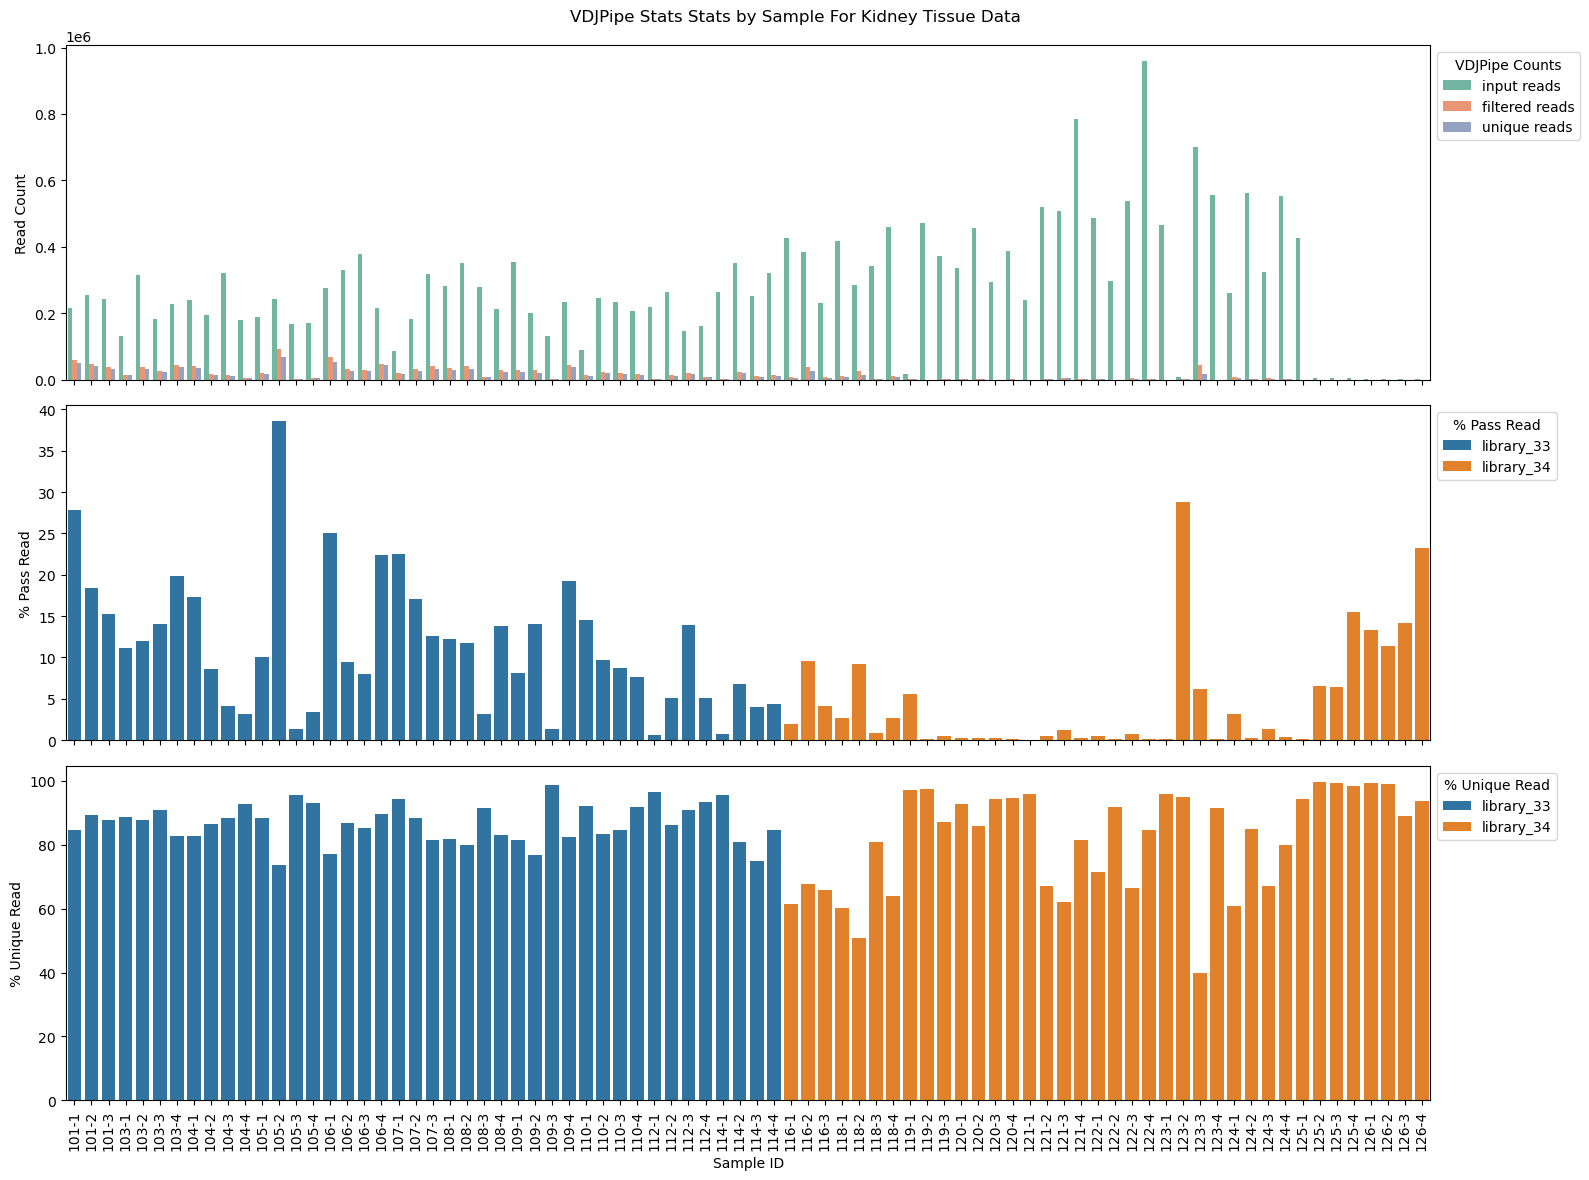

In [9]:
temp = sample_info_combined[sample_info_combined.tissue == 'kidney']
print("Number of Tissue Samples: ", temp.shape[0])
df_melted = temp.melt(id_vars="sample_id", value_vars = [ 'input reads', 'filtered reads', 'unique reads'], 
                             var_name="statistic", value_name="value")

# Create the barplot
fix, axs = plt.subplots(3, 1, figsize = (16, 12), sharex = True)

ax = axs[0]
sns.barplot(x="sample_id", y="value", hue="statistic", data=df_melted, ax = ax, palette = 'Set2')
ax.set_ylabel('Read Count')
ax.legend(title = "VDJPipe Counts", loc='upper left', bbox_to_anchor = (1, 1))

ax = axs[1]
sns.barplot(x="sample_id", y="% Pass", hue = 'library',  data=temp, ax = ax)
ax.set_ylabel('% Pass Read')
ax.legend(title = "% Pass Read", loc='upper left', bbox_to_anchor = (1, 1))
ax.set_xlabel("Sample ID")

ax = axs[2]
sns.barplot(x="sample_id", y="% Unique", hue = 'library',  data=temp, ax = ax)
ax.set_ylabel('% Unique Read')
ax.legend(title = "% Unique Read", loc='upper left', bbox_to_anchor = (1, 1))
ax.set_xlabel("Sample ID")
ax.tick_params(axis='x', rotation=90)

plt.suptitle("VDJPipe Stats Stats by Sample For Kidney Tissue Data")
plt.tight_layout()

figname = fig_dir + 'vdjpipe_stats_tissue.png'
plt.savefig(figname, bbox_inches = 'tight', dpi = 300)

# Show the plot
plt.show()

## VDJPipe Summary For Blood samples

Number of Blood Samples:  18


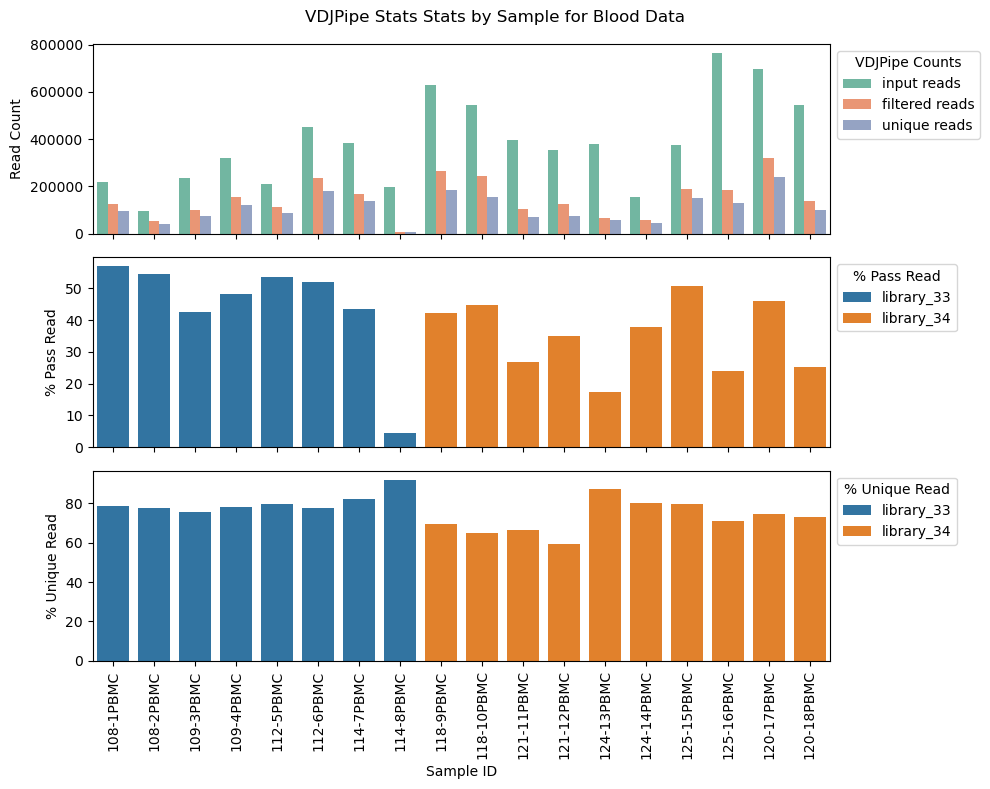

In [10]:
# Reshape the DataFrame for easier plotting
temp = sample_info_combined[sample_info_combined.tissue == 'blood']

print("Number of Blood Samples: ", temp.shape[0])
df_melted = temp.melt(id_vars="sample_id", value_vars = ['input reads',  'filtered reads', 'unique reads'], 
                             var_name="statistic", value_name="value")

# Create the barplot
fix, axs = plt.subplots(3, 1, figsize = (10, 8), sharex = True)

ax = axs[0]
sns.barplot(x="sample_id", y="value", hue="statistic", data=df_melted, ax = ax, palette = 'Set2')
ax.set_ylabel('Read Count')
ax.legend(title = "VDJPipe Counts", loc='upper left', bbox_to_anchor = (1, 1))

ax = axs[1]
sns.barplot(x="sample_id", y="% Pass", hue = 'library',  data=temp, ax = ax)
ax.set_ylabel('% Pass Read')
ax.legend(title = "% Pass Read", loc='upper left', bbox_to_anchor = (1, 1))
ax.set_xlabel("Sample ID")

ax = axs[2]
sns.barplot(x="sample_id", y="% Unique", hue = 'library',  data=temp, ax = ax)
ax.set_ylabel('% Unique Read')
ax.legend(title = "% Unique Read", loc='upper left', bbox_to_anchor = (1, 1))
ax.set_xlabel("Sample ID")
ax.tick_params(axis='x', rotation=90)

plt.suptitle("VDJPipe Stats Stats by Sample for Blood Data")
plt.tight_layout()
figname = fig_dir + 'vdjpipe_stats_blood.png'
plt.savefig(figname, bbox_inches = 'tight', dpi = 300)

# Show the plot
plt.show()

## Samples with Less than 1000 total records

(18, 27)


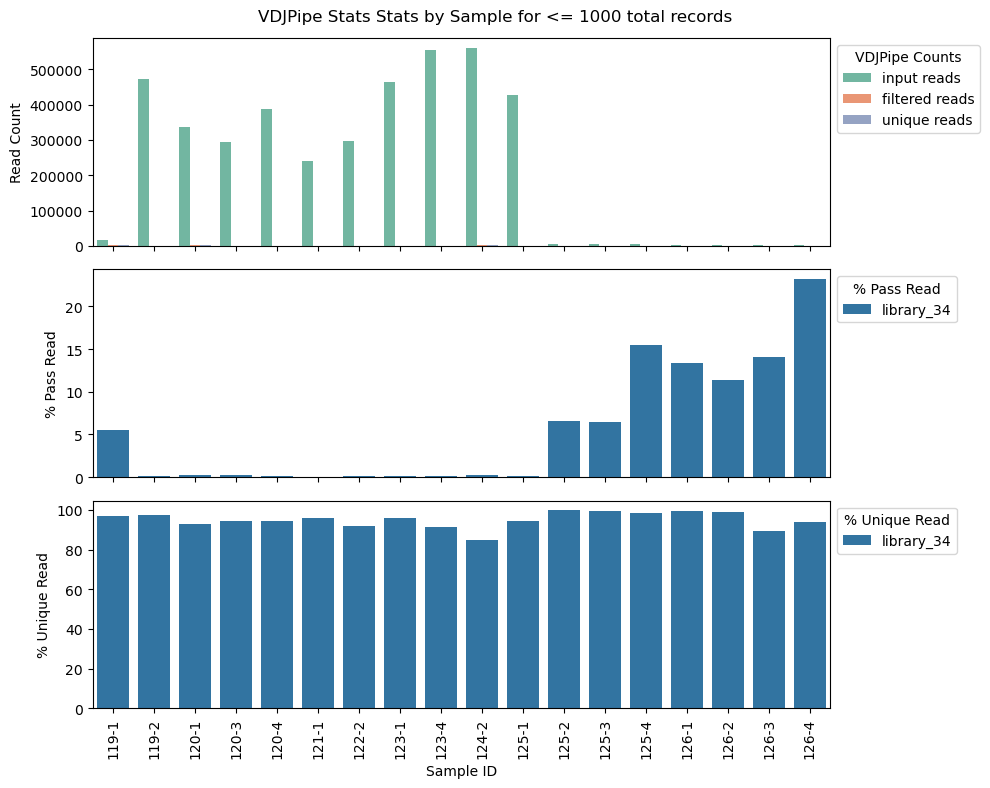

In [11]:
temp  = sample_info_combined[sample_info_combined['total records'] <= 1000]
# Reshape the DataFrame for easier plotting
print(temp.shape)
df_melted = temp.melt(id_vars="sample_id", value_vars = ['input reads', 'filtered reads', 'unique reads'], 
                             var_name="statistic", value_name="value")

# Create the barplot
fix, axs = plt.subplots(3, 1, figsize = (10, 8), sharex = True)

ax = axs[0]
sns.barplot(x="sample_id", y="value", hue="statistic", data=df_melted, ax = ax, palette = 'Set2')
ax.set_ylabel('Read Count')
ax.legend(title = "VDJPipe Counts", loc='upper left', bbox_to_anchor = (1, 1))

ax = axs[1]
sns.barplot(x="sample_id", y="% Pass", hue = 'library',  data=temp, ax = ax)
ax.set_ylabel('% Pass Read')
ax.legend(title = "% Pass Read", loc='upper left', bbox_to_anchor = (1, 1))
ax.set_xlabel("Sample ID")

ax = axs[2]
sns.barplot(x="sample_id", y="% Unique", hue = 'library',  data=temp, ax = ax)
ax.set_ylabel('% Unique Read')
ax.legend(title = "% Unique Read", loc='upper left', bbox_to_anchor = (1, 1))
ax.set_xlabel("Sample ID")
ax.tick_params(axis='x', rotation=90)

plt.suptitle("VDJPipe Stats Stats by Sample for <= 1000 total records")
plt.tight_layout()
figname = fig_dir + 'samples_with_less_than_1000_records.png'
plt.savefig(figname, bbox_inches = 'tight', dpi = 300)

# Show the plot
plt.show()

## Pie Chart of Productive vs Non-Productive Records (Aggregate)

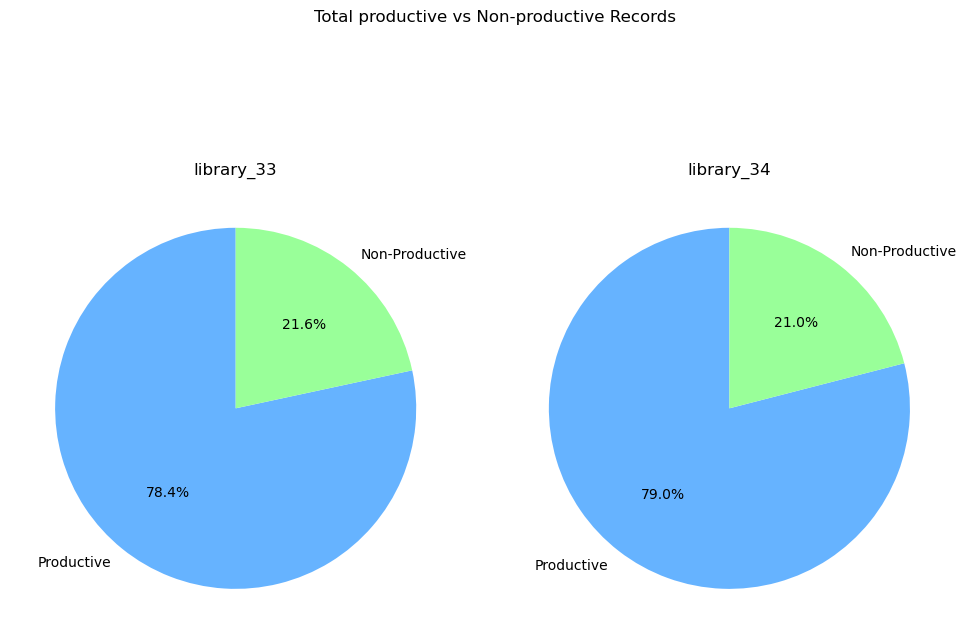

In [12]:
# Summing the records across all files for productive and non-productive records
df1 = sample_info_combined[sample_info_combined.library == 'library_33']
df2 = sample_info_combined[sample_info_combined.library == 'library_34']
dfs = [df1, df2]
libraries = ['library_33', 'library_34']
# Plotting a pie chart
fix, ax = plt.subplots(1, 2, figsize = (10, 8), sharex = True)
for i, df in enumerate(dfs):
    ax[i].pie([df['productive records'].sum(), df['non-productive records'].sum()], labels=['Productive', 'Non-Productive'], autopct='%1.1f%%',
            startangle=90, colors=['#66b3ff','#99ff99'])
    ax[i].set_title(libraries[i])

plt.suptitle("Total productive vs Non-productive Records")
plt.tight_layout()
figname = fig_dir + 'piechart_total_productive_vs_nonproductive_records.png'
plt.savefig(figname, bbox_inches = 'tight', dpi = 300)
plt.show()

## IgBlast Summary Statistics

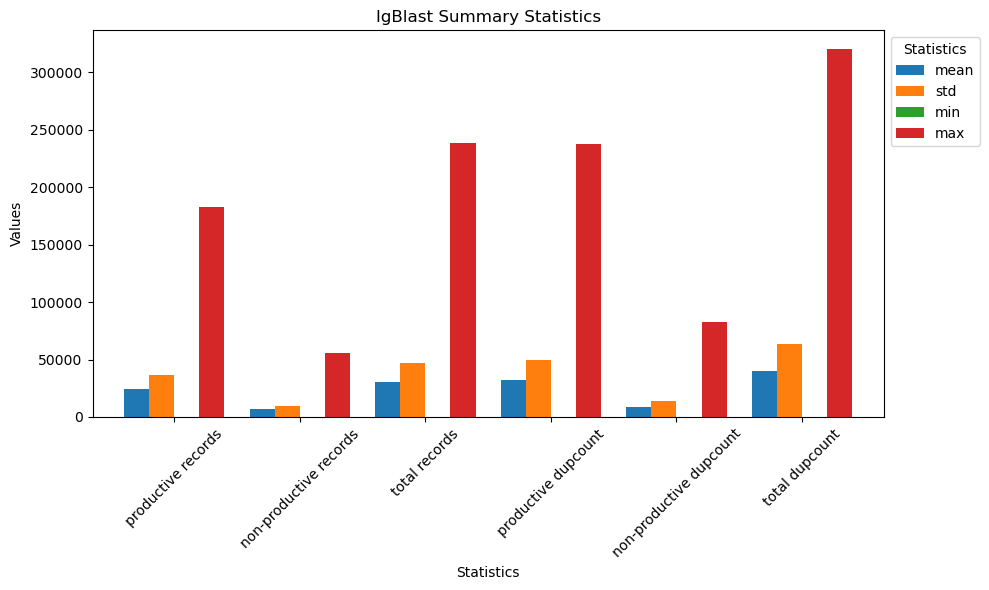

In [13]:
# Get summary statistics
summary_stats = sample_info_combined[['productive records', 'non-productive records', 'total records', 
                    'productive dupcount', 'non-productive dupcount', 'total dupcount']].describe().transpose()

# Plotting the summary statistics
fig, ax = plt.subplots(figsize=(10, 6))

# Plot mean, standard deviation, min, max for each column
summary_stats[['mean', 'std', 'min', 'max']].plot(kind='bar', ax=ax, width=0.8)
ax.legend(title = "Statistics", loc='upper left', bbox_to_anchor = (1, 1))
plt.title('IgBlast Summary Statistics')
plt.ylabel('Values')
plt.xlabel('Statistics')
plt.xticks(rotation=45)
plt.tight_layout()
# figname = fig_dir + 'l24_igblast_summary.png'
# plt.savefig(figname, bbox_inches = 'tight', dpi = 300)
plt.show()


## All Samples Unique Read Distribution

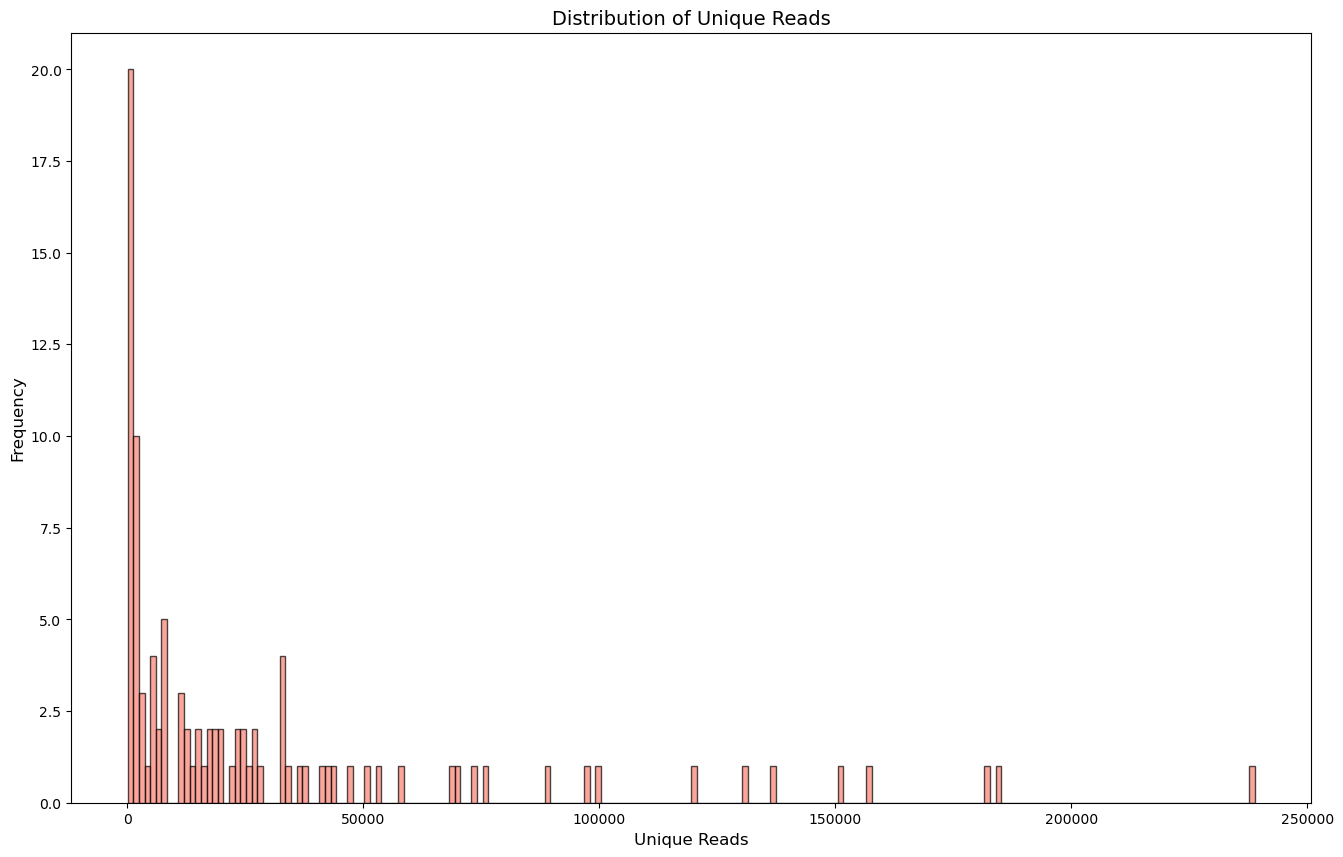

In [14]:
unique_reads = sample_info_combined['unique reads'].tolist()

# # Create a histogram
plt.figure(figsize=(16, 10))
plt.hist(unique_reads, bins=200, color='salmon', edgecolor='black', alpha=0.7)

# Adding titles and labels
plt.title('Distribution of Unique Reads', fontsize=14)
plt.xlabel('Unique Reads', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
figname = fig_dir + f'unique_distribution_barplot.png'
plt.savefig(figname, bbox_inches='tight', dpi=300)
# Show the plot
plt.show()


## Unique Read Distribution Per Library

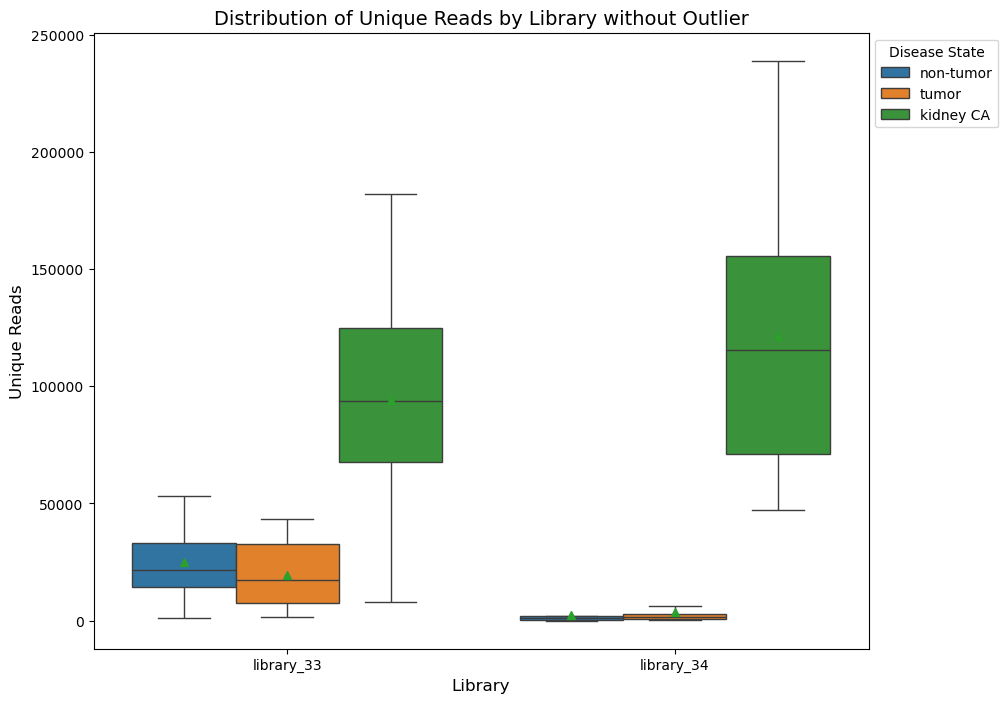

In [15]:
df = sample_info_combined.copy()
plt.figure(figsize=(10, 8))
sns.boxplot(x='library', y='unique reads', hue = 'disease_state', showmeans= True,  data=df, showfliers = False)
## turn back on if you want the points on top
# sns.stripplot(x = 'library', y = 'unique reads', data=sample_info_combined, color='black', legend = False)
# Add titles and labels
plt.title('Distribution of Unique Reads by Library without Outlier', fontsize=14)
plt.xlabel('Library', fontsize=12)
plt.ylabel('Unique Reads', fontsize=12)
plt.legend(title = "Disease State", loc='upper left', bbox_to_anchor = (1, 1))
figname = fig_dir + f'unique_distribution_with_outlier.png'
# plt.savefig(figname, bbox_inches='tight', dpi=300)

# Show the plot
plt.show()

## For Each Patient Find Number of Reads Pre-QC, Post QC (VDJPipe Stats)

Merged read Max:  959098
Merged read Min:  906


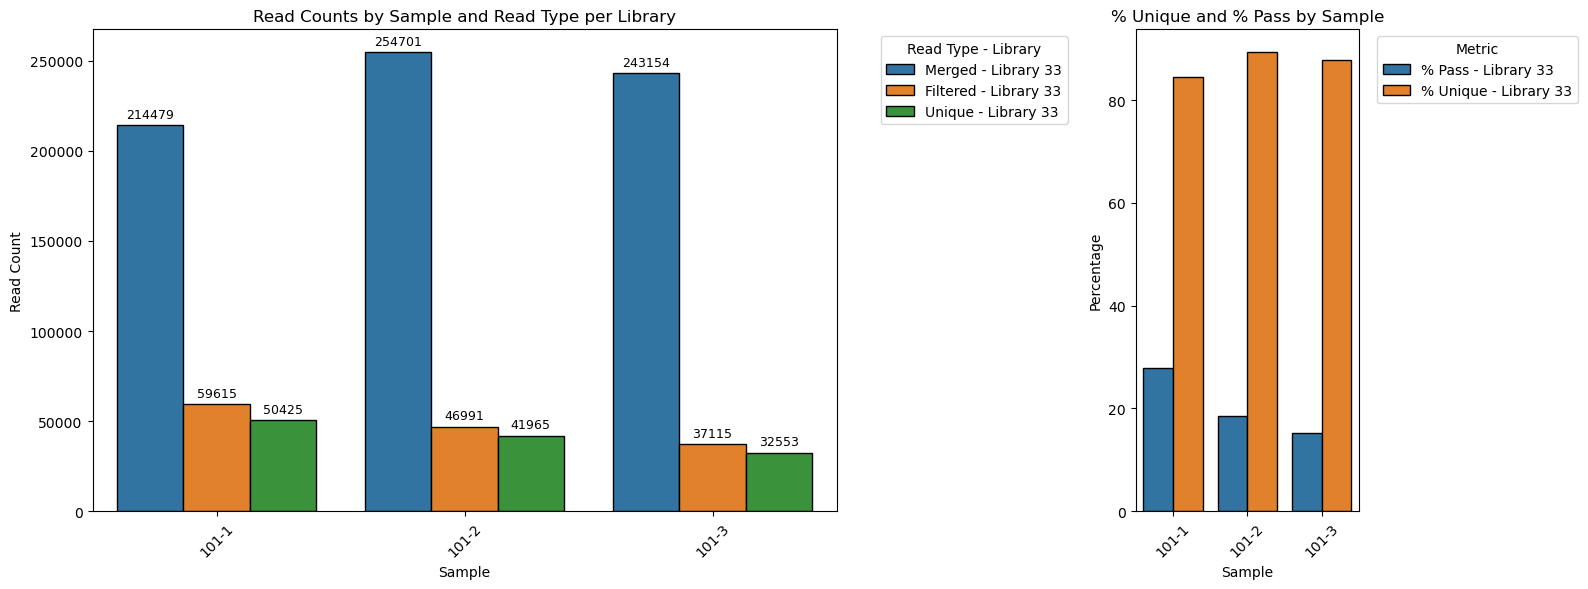

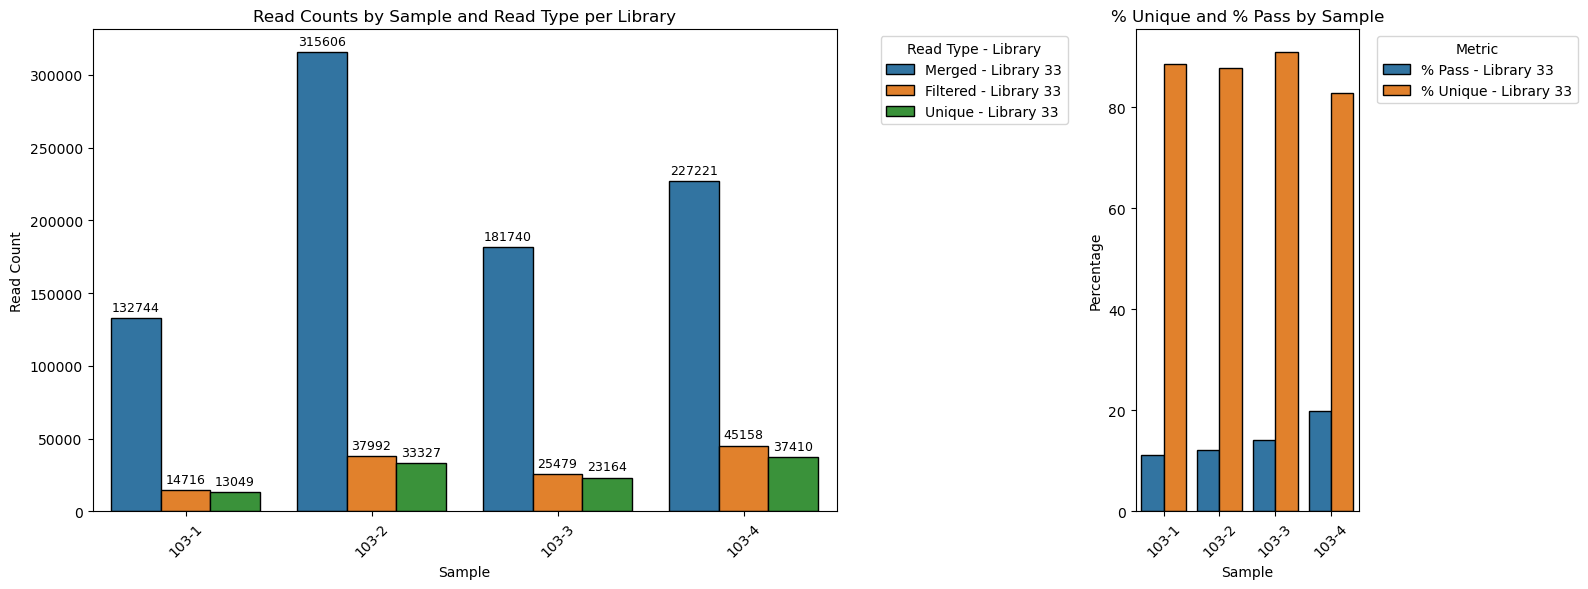

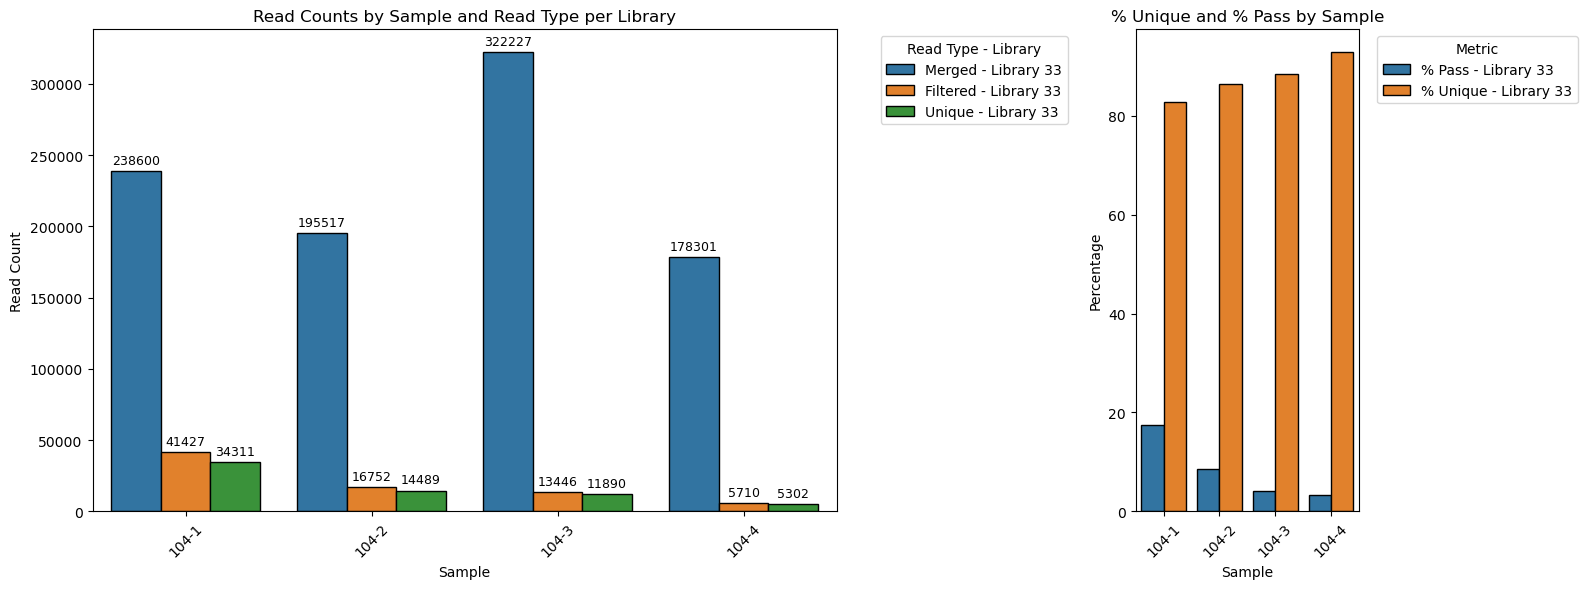

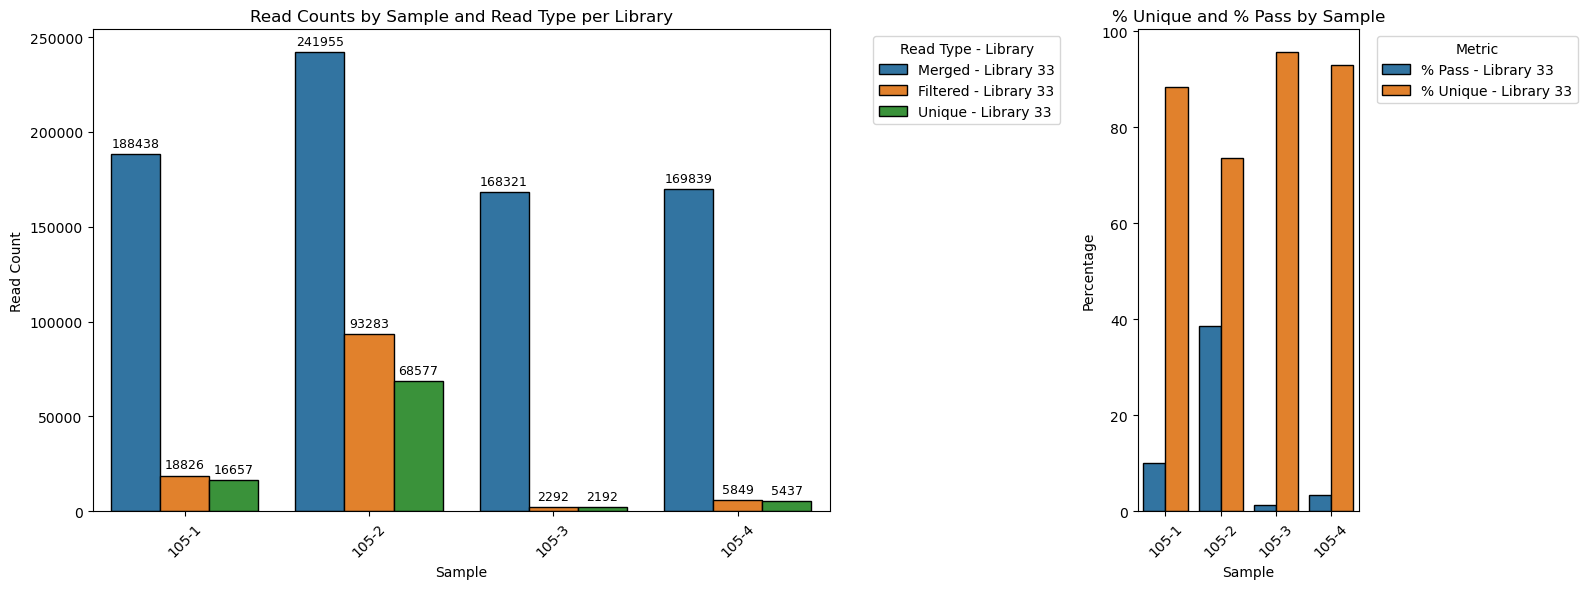

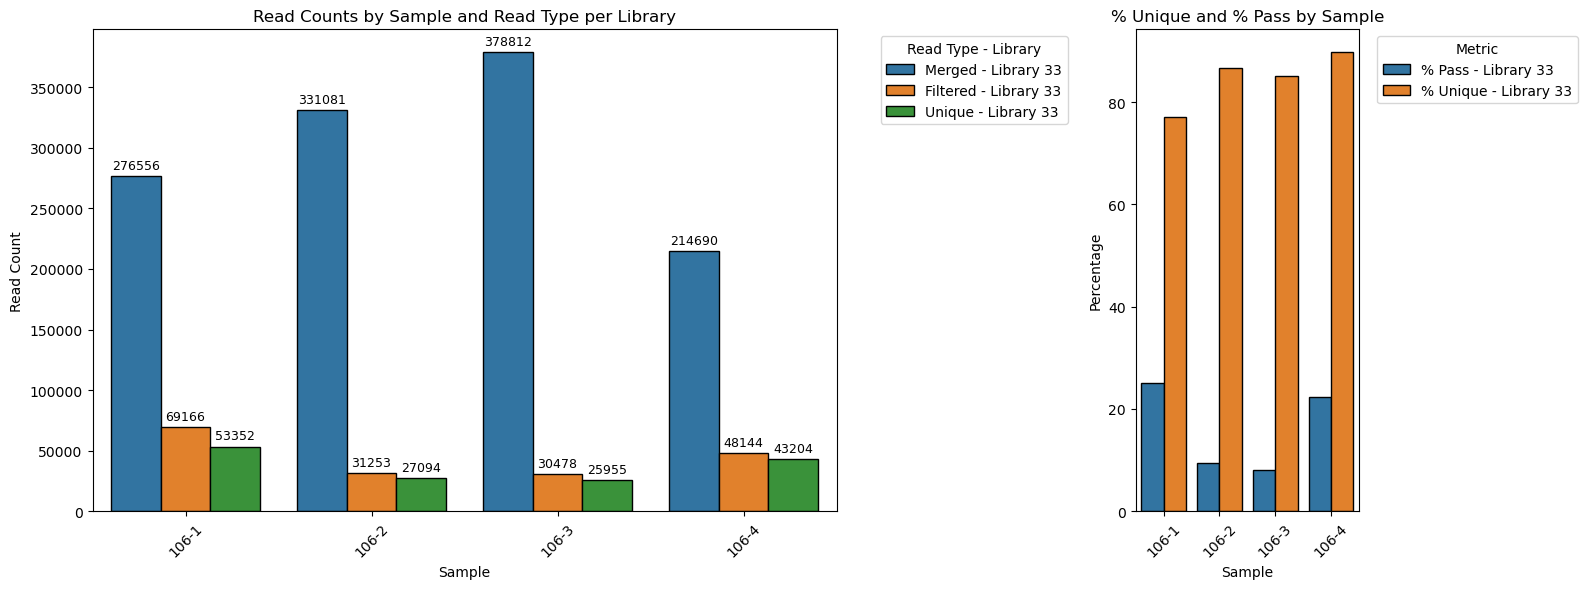

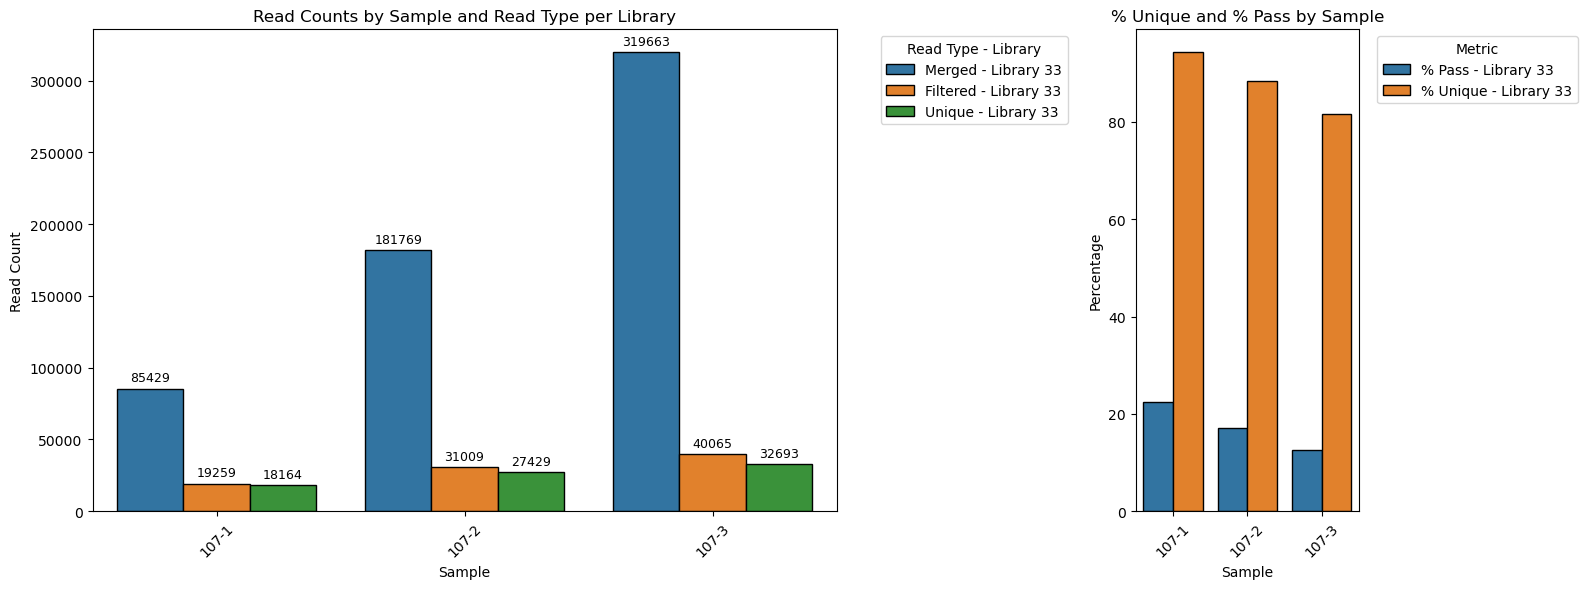

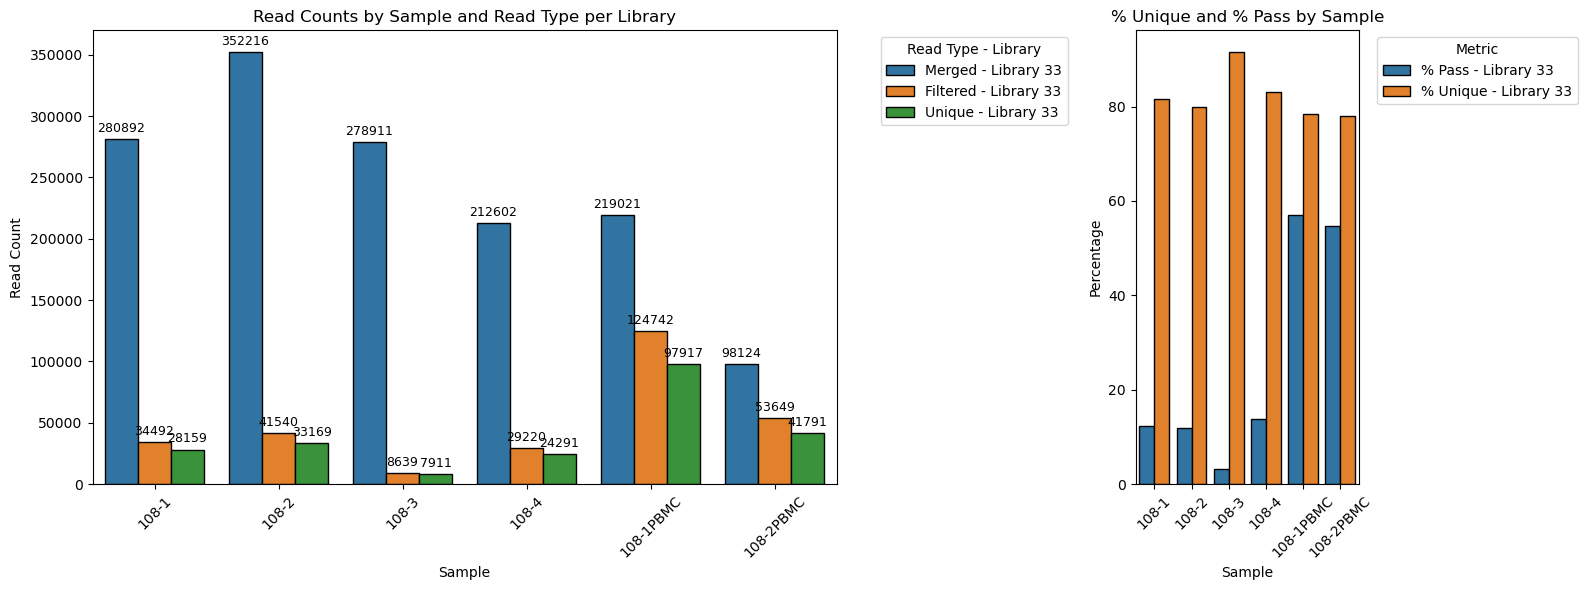

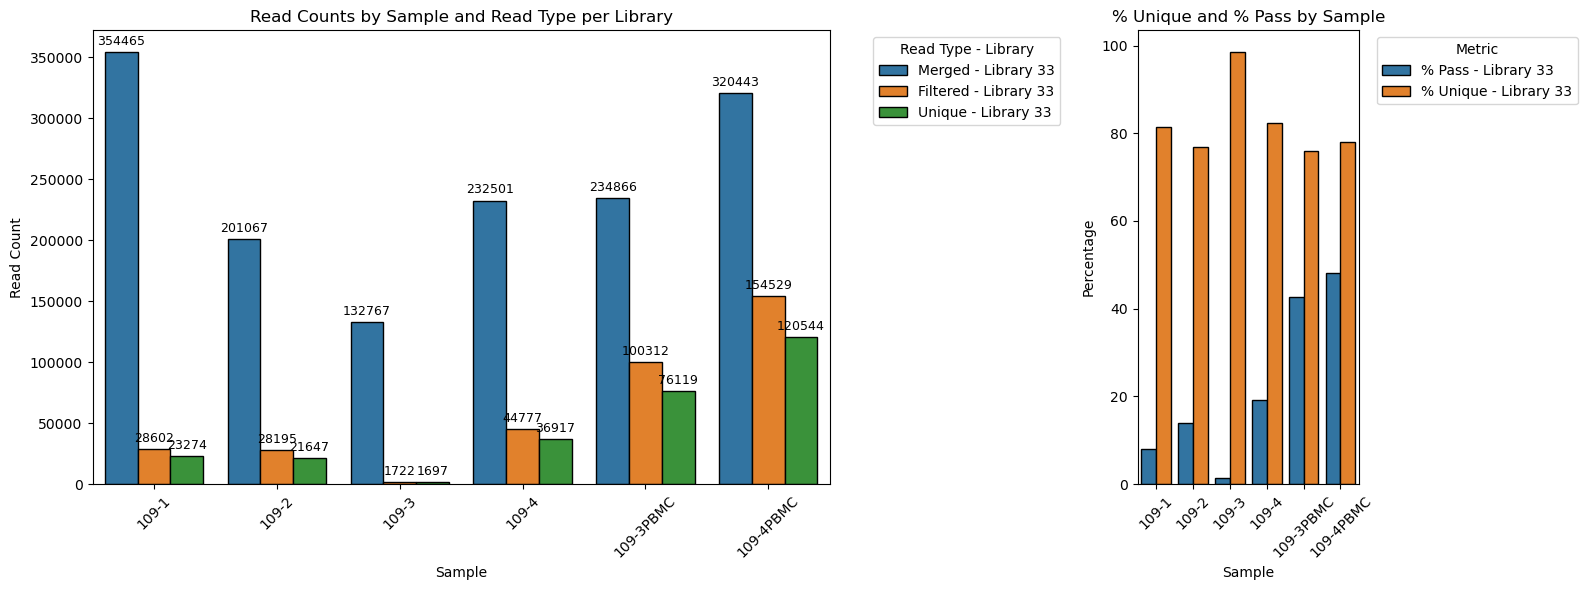

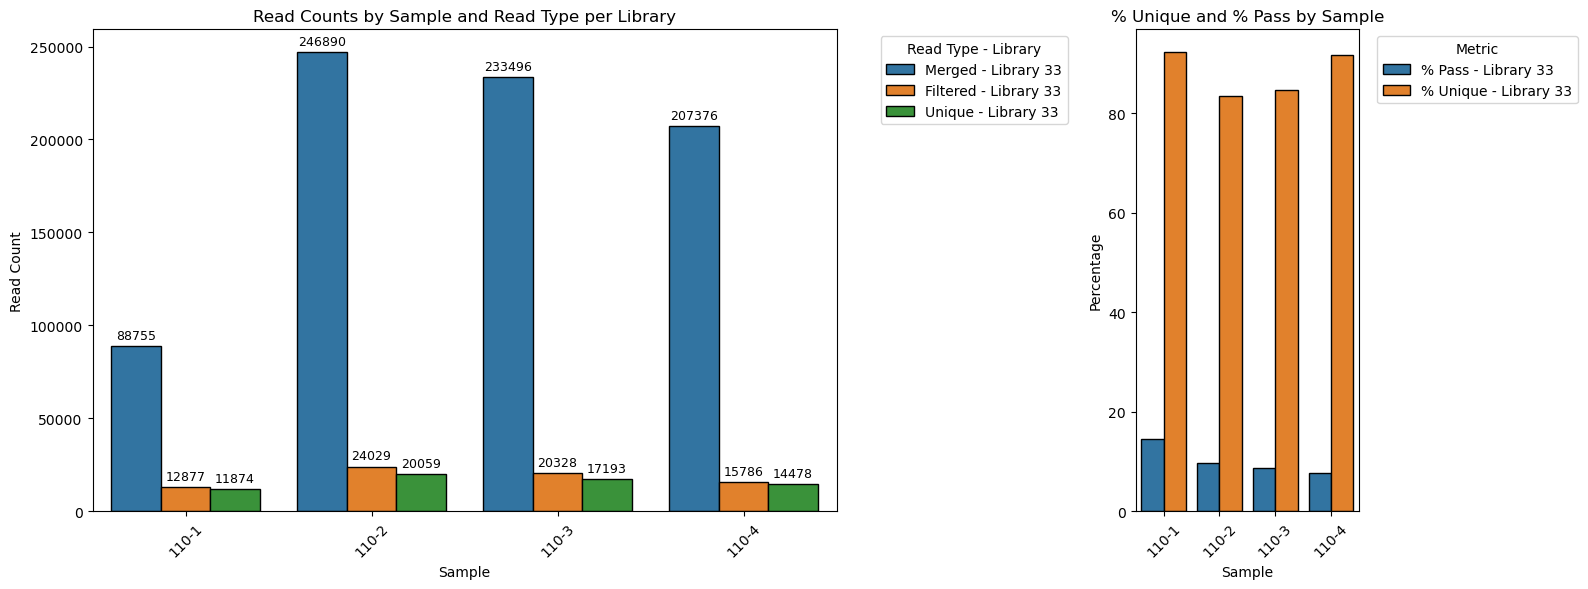

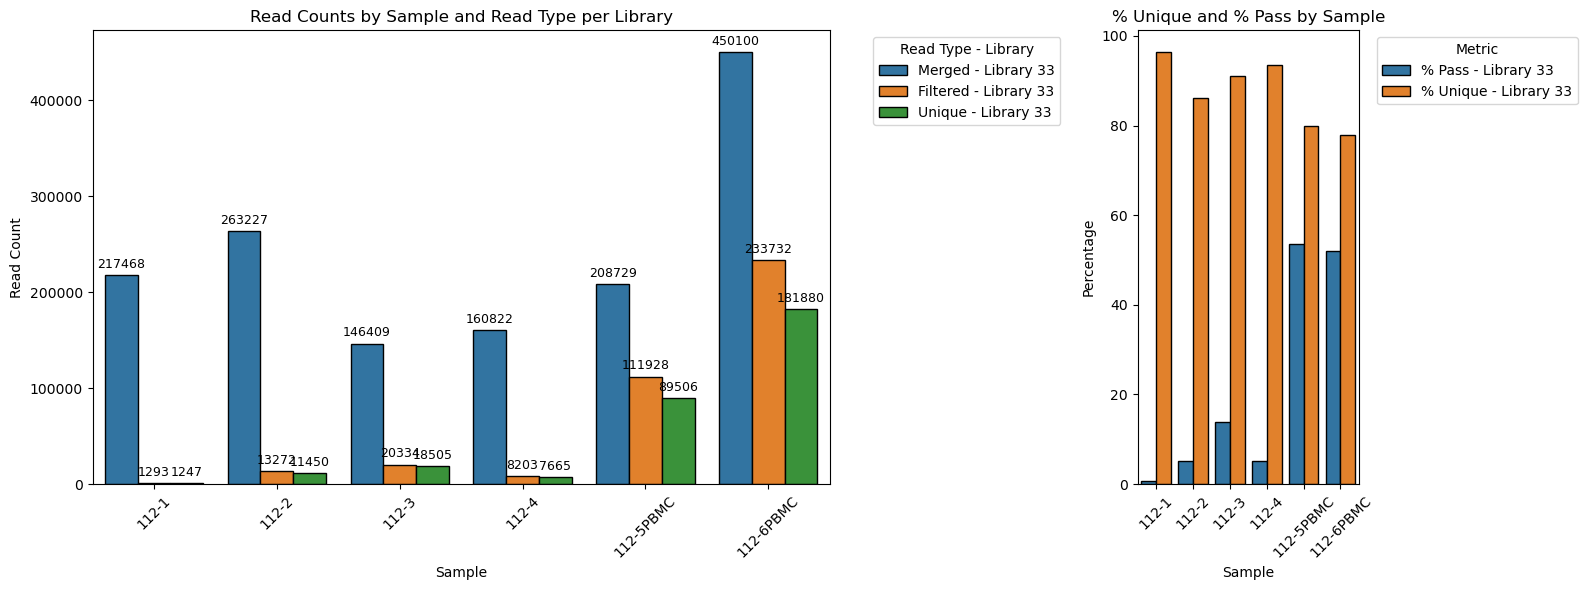

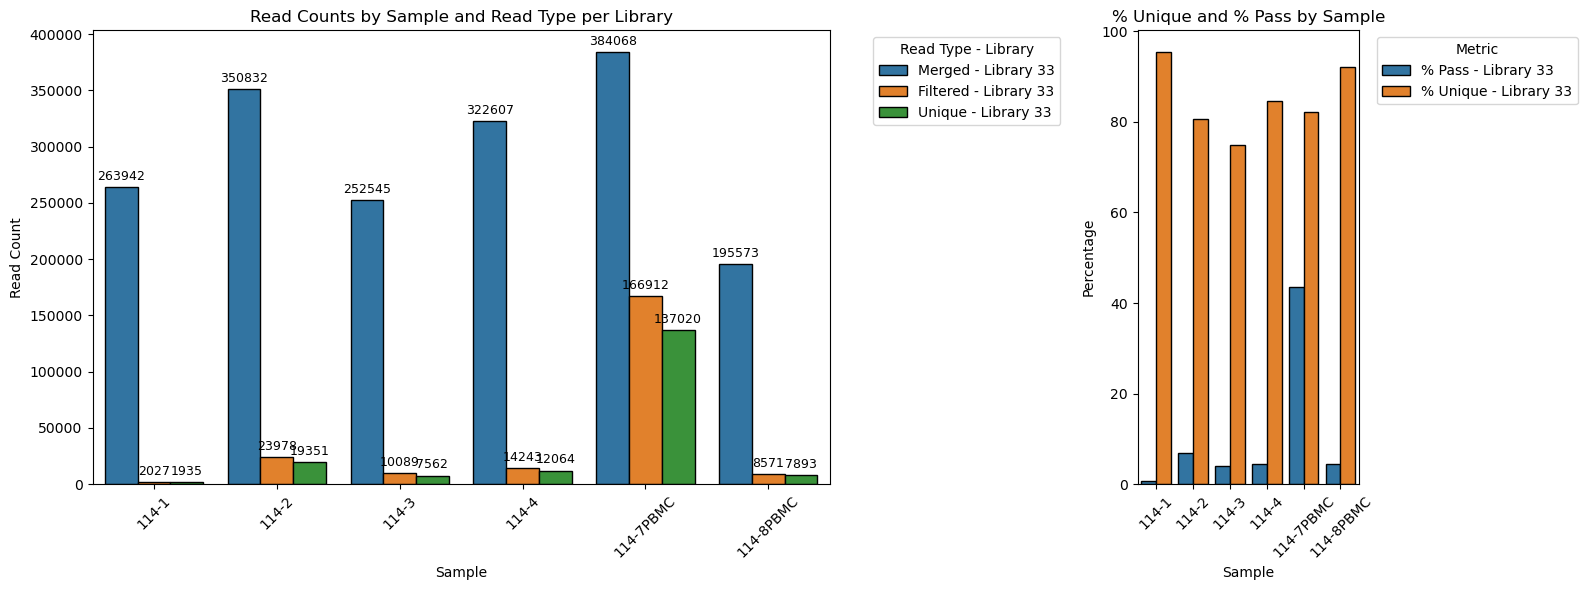

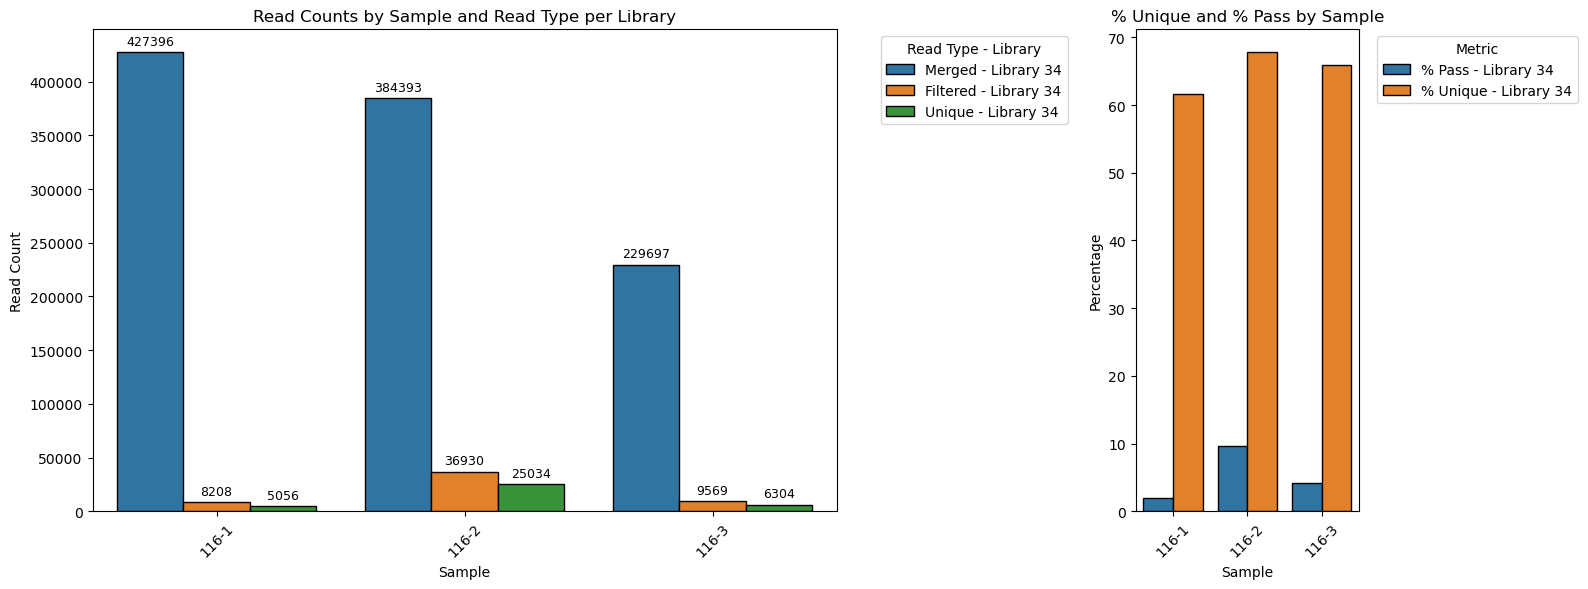

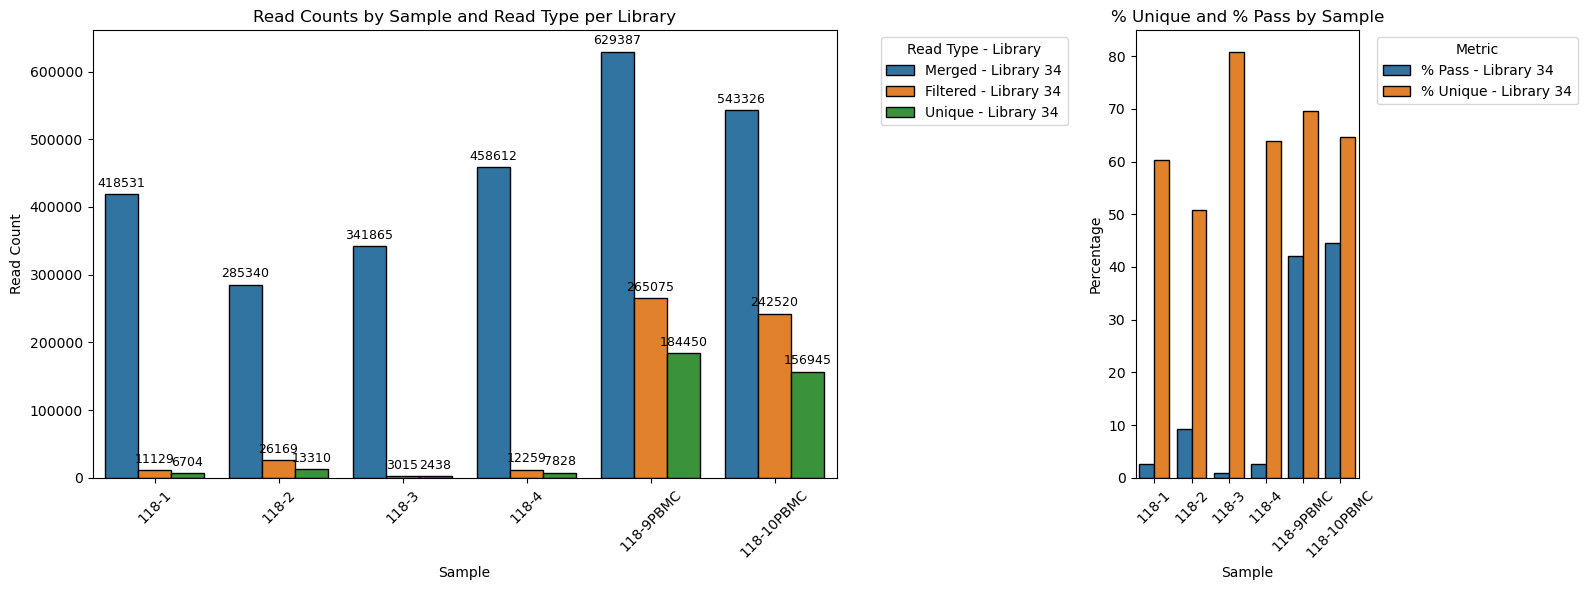

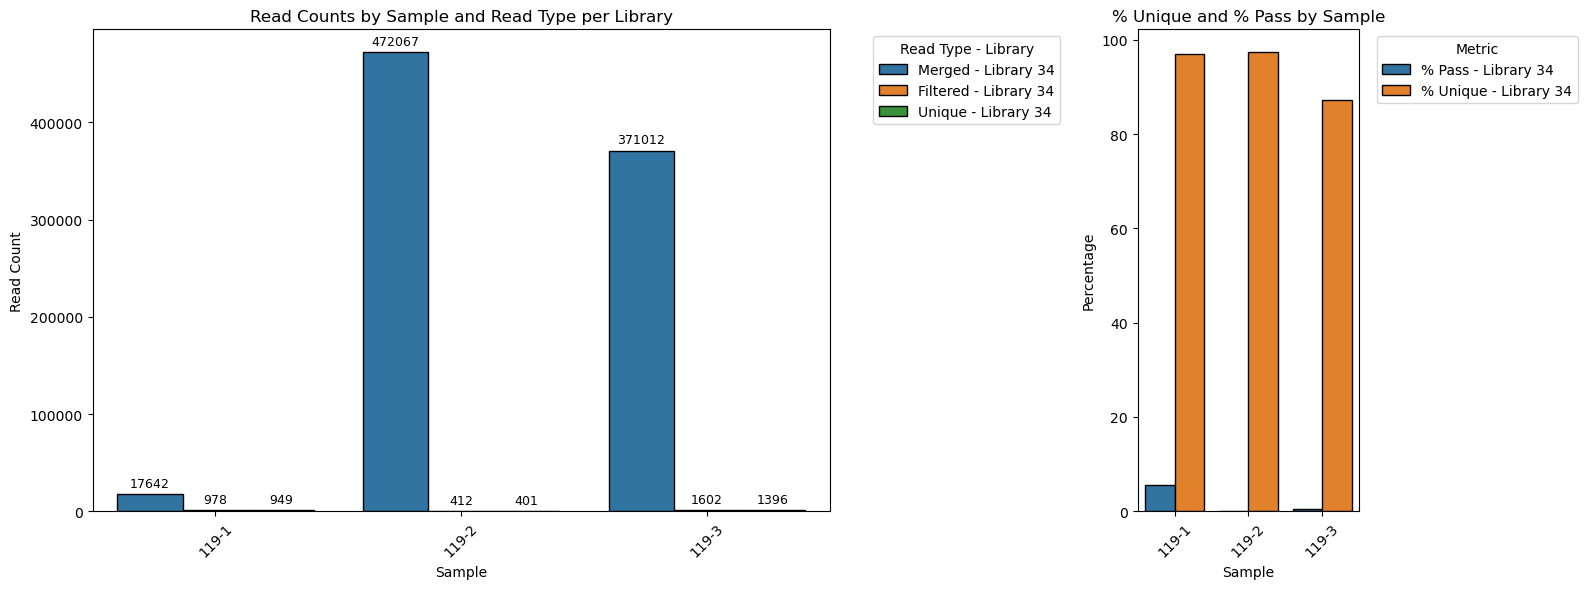

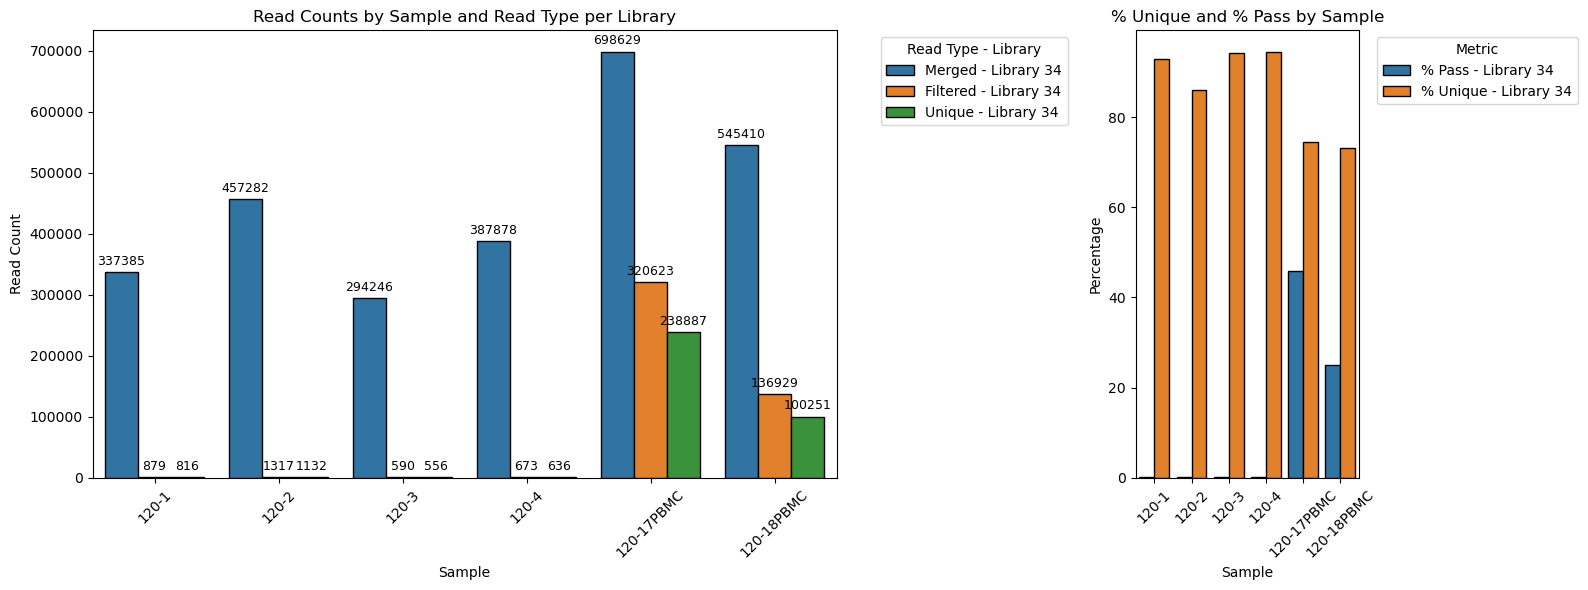

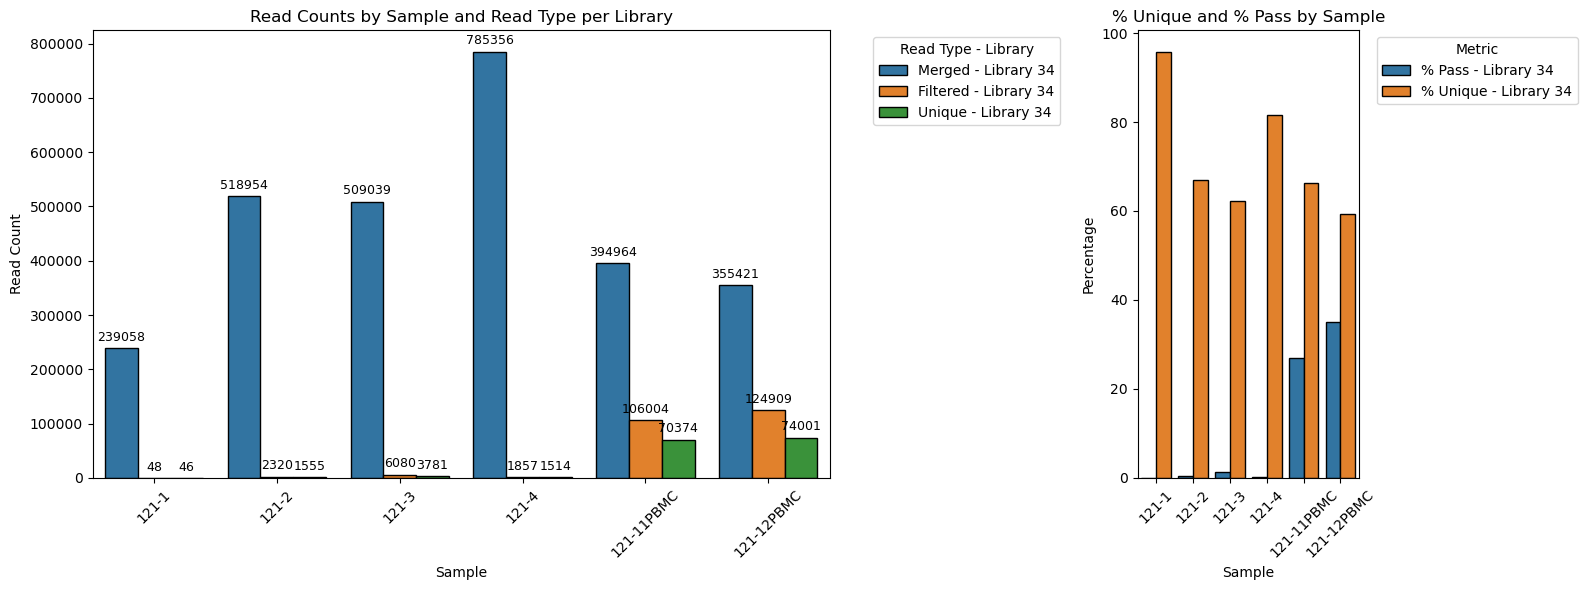

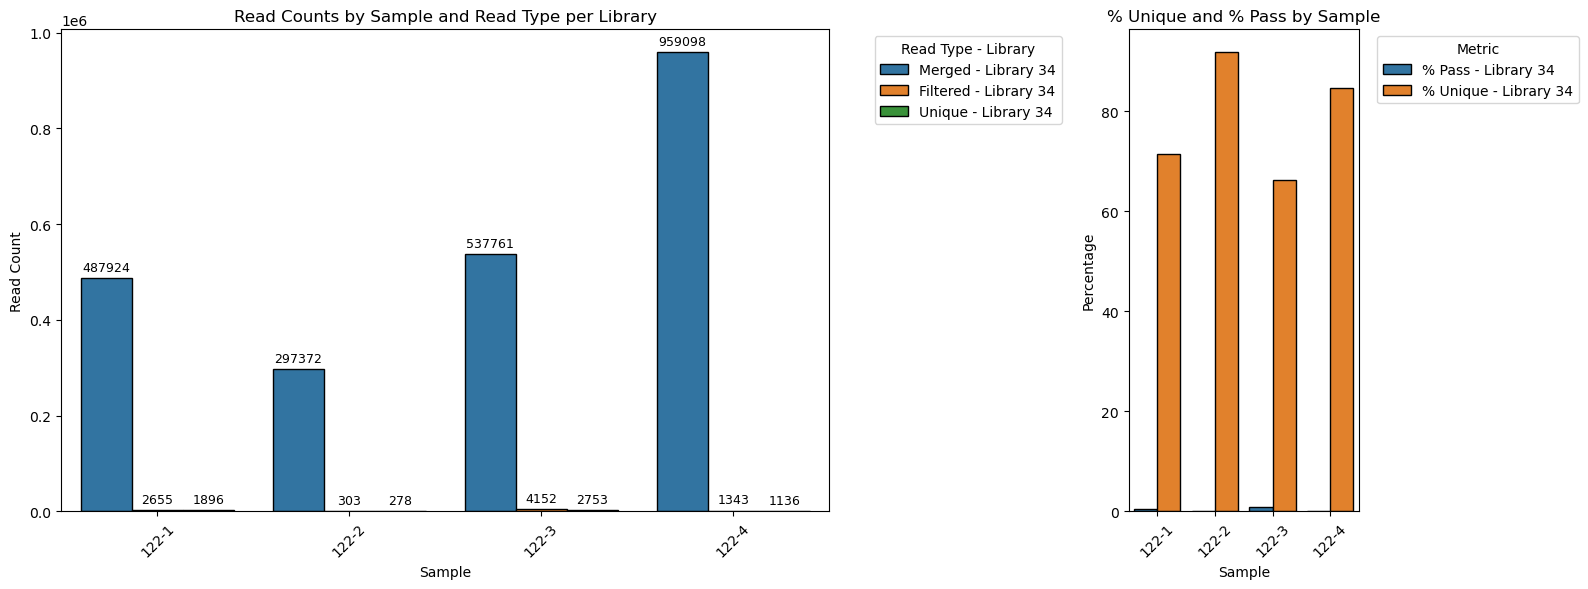

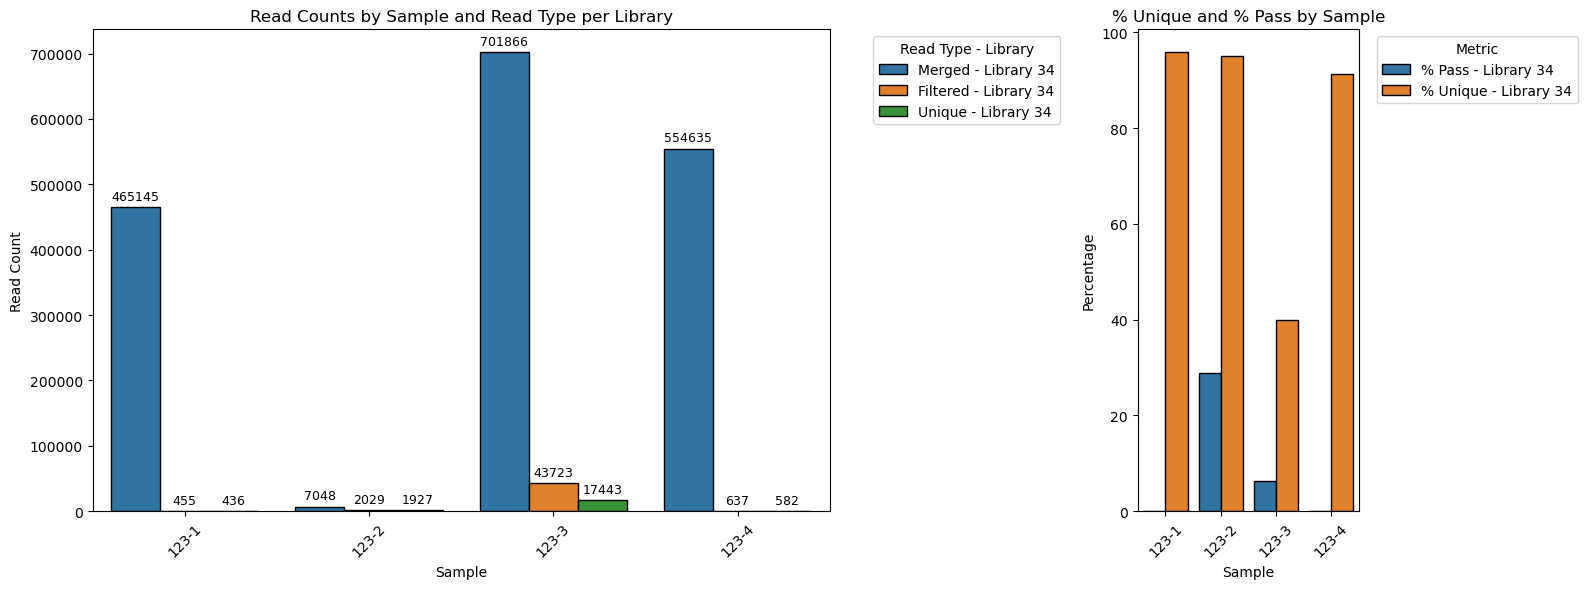

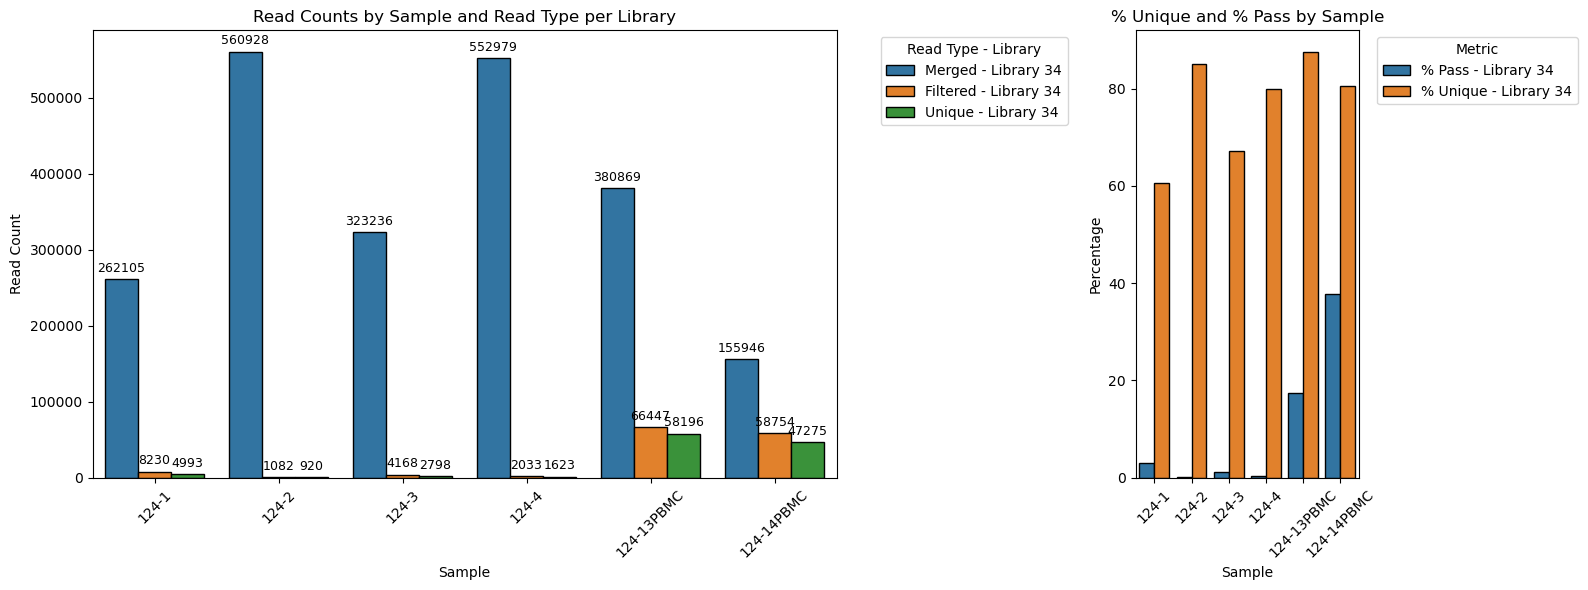

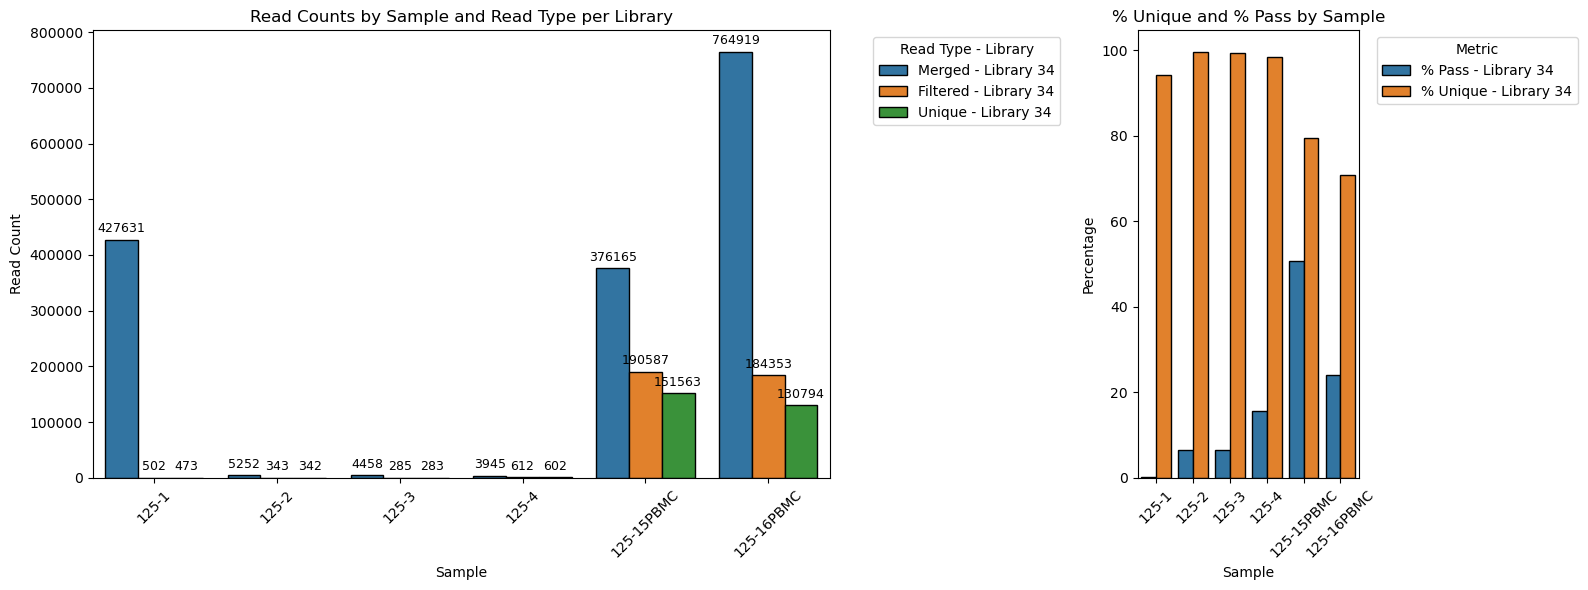

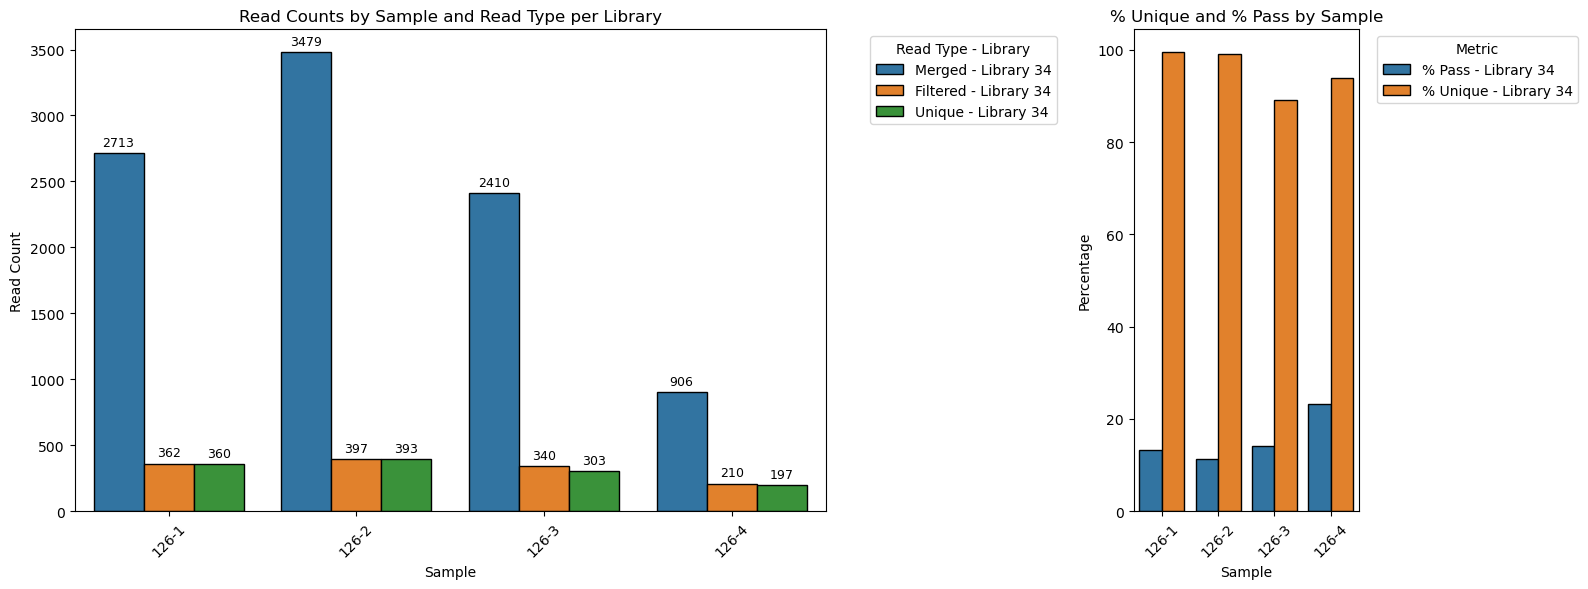

In [110]:
def add_bar_labels(ax, fmt='{:.0f}', padding=3):
    for container in ax.containers:
        ax.bar_label(
            container,
            labels=[fmt.format(v) if v == v else '' for v in container.datavalues],
            padding=padding,
            fontsize=9
        )
        
unique_patients = sample_info_combined.subject_id.unique().tolist()
max_ylim = sample_info_combined['merged reads'].max() + 1000
print("Merged read Max: ", sample_info_combined['merged reads'].max())
print("Merged read Min: ", sample_info_combined['merged reads'].min())
for patient in unique_patients:
    samples = sample_info_combined[sample_info_combined.subject_id == patient]
    # Read counts melted
    df_long = pd.melt(samples, id_vars=['sample_id', 'library'], value_vars=['merged reads', 'filtered reads', 'unique reads'], var_name='Read Type', value_name='Read Count' )
    
    df_long['Read Type'] = df_long['Read Type'].str.replace(' reads', '', regex=False).str.title()
    df_long['Library'] = df_long['library'].str.replace('_', ' ').str.title()
    df_long['Type-Library'] = df_long['Read Type'] + ' - ' + df_long['Library']

    # Percent metrics melted
    df_pct = pd.melt(samples,id_vars=['sample_id', 'library'], value_vars=['% Pass', '% Unique'], var_name='Metric', value_name='Percentage')
    df_pct['Library'] = df_pct['library'].str.replace('_', ' ').str.title()
    df_pct['Type-Library'] = df_pct['Metric'] + ' - ' + df_pct['Library']

    # Create figure with 2 subplots
    fig, ax = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [5, 1.5]})
    # Plot Read Counts
    sns.barplot(data=df_long, x='sample_id', y='Read Count', hue='Type-Library', palette='tab10', edgecolor='black', ax=ax[0])
    add_bar_labels(ax[0], fmt='{:.0f}', padding=3)
    ax[0].set_title('Read Counts by Sample and Read Type per Library')
    ax[0].set_xlabel('Sample')
    ax[0].set_ylabel('Read Count')
    # ax[0].set_ylim([10, max_ylim])
    ax[0].tick_params(axis='x', rotation=45)
    ax[0].legend(title='Read Type - Library', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Plot % Unique and % Pass
    sns.barplot(data=df_pct, x='sample_id', y='Percentage', hue='Type-Library', palette='tab10', edgecolor='black',ax=ax[1])
    ax[1].set_title('% Unique and % Pass by Sample')
    ax[1].set_xlabel('Sample')
    ax[1].set_ylabel('Percentage')
    # ax[1].set_ylim([10, 100])
    ax[1].tick_params(axis='x', rotation=45)
    ax[1].legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
    # Save and show
    fig.tight_layout()
    figname = fig_dir + f'{patient}_read_count_with_library_and_percentages.png'
    plt.savefig(figname, bbox_inches='tight', dpi=300)
    plt.show()

## Individual Plot for Each READ Count

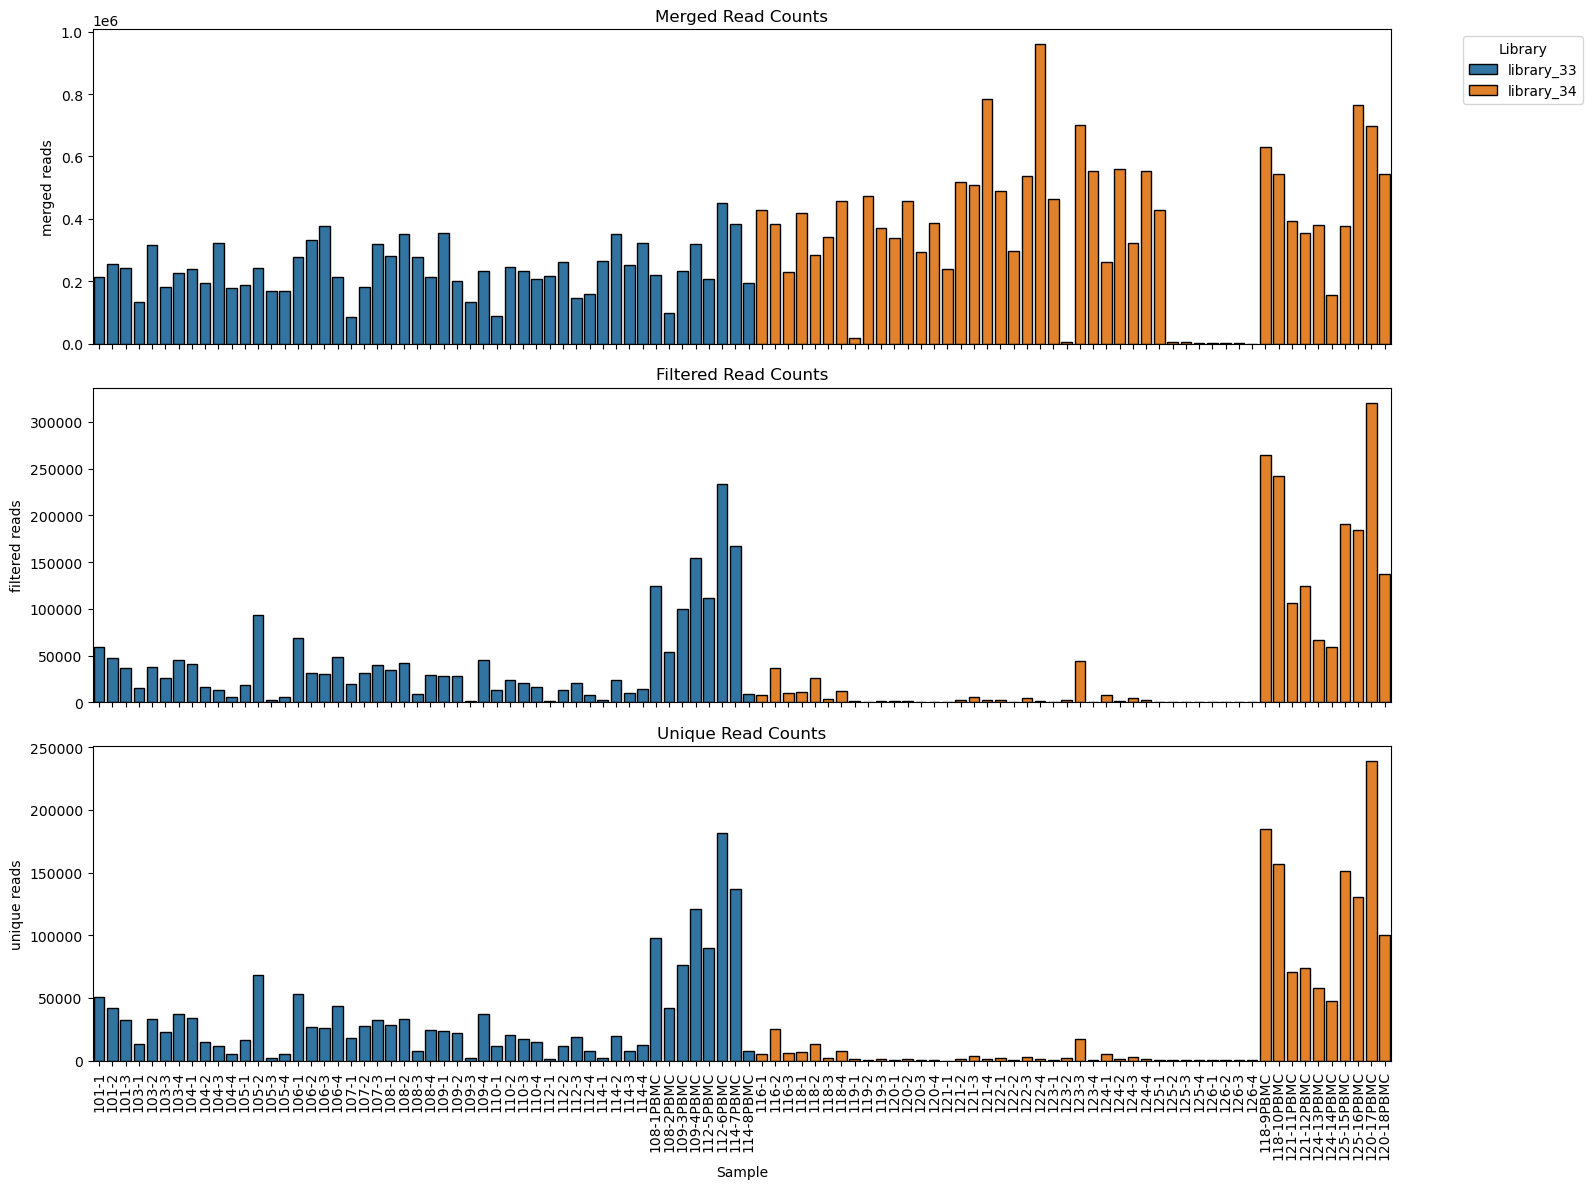

In [17]:
#combine samples from two libraries together
samples = sample_info_combined.copy()
# Create figure with 2 subplots
fig, axs = plt.subplots(3, 1, figsize=(16, 12), sharey = False, sharex = True)
# Plot Read Counts
ax = axs[0]
sns.barplot(data=samples, x='sample_id', y='merged reads', hue='library', palette='tab10', edgecolor='black', ax=ax, legend = True)
ax.set_title('Merged Read Counts')
ax.set_xlabel('Sample')
ax.legend(title='Library', bbox_to_anchor=(1.05, 1), loc='upper left')

ax = axs[1]
sns.barplot(data=samples, x='sample_id', y='filtered reads', hue='library', palette='tab10', edgecolor='black', ax=ax, legend = False)
ax.set_title('Filtered Read Counts')
ax.set_xlabel('Sample')

ax = axs[2]
sns.barplot(data=samples, x='sample_id', y='unique reads', hue='library', palette='tab10', edgecolor='black', ax=ax, legend = False)
ax.set_title('Unique Read Counts')
ax.set_xlabel('Sample')
ax.tick_params(axis='x', rotation=90)

fig.tight_layout()
# figname = fig_dir + f'{patient}_read_count_with_library_and_percentages.png'
# plt.savefig(figname, bbox_inches='tight', dpi=300)
plt.show()

## Boxplot for each Individual READ Count

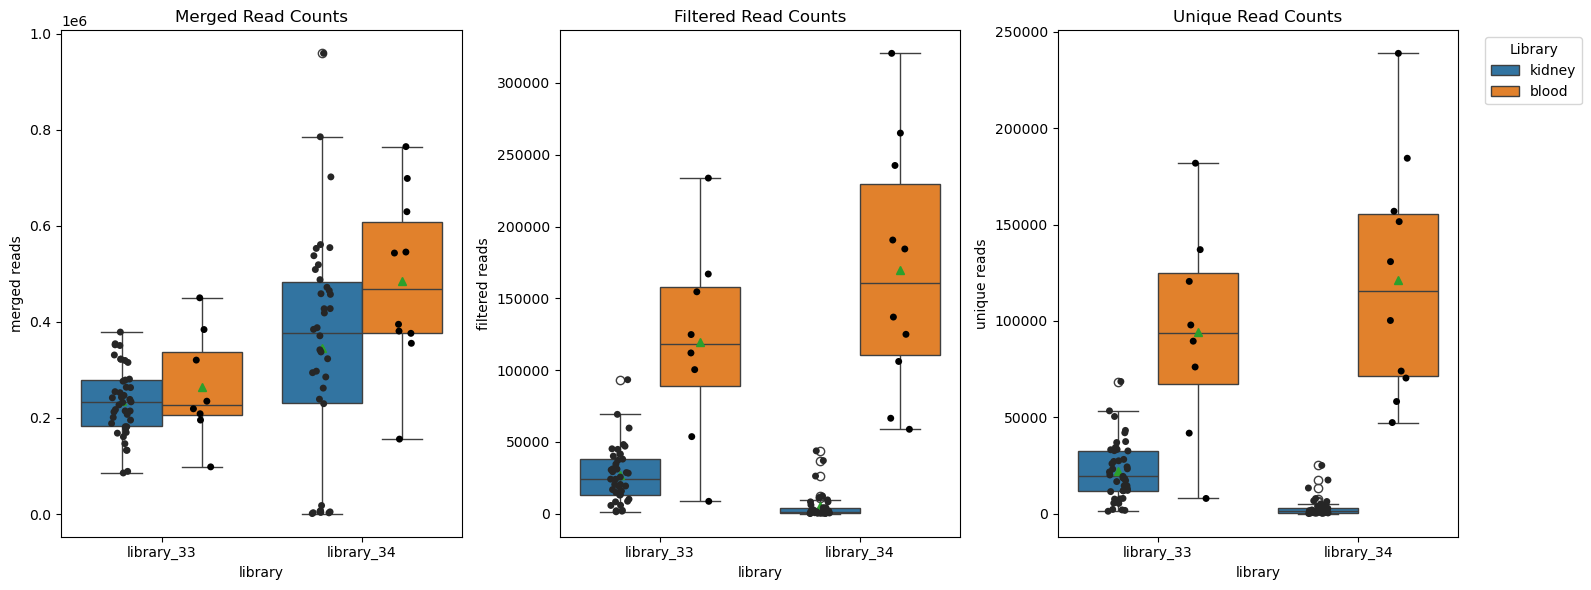

In [18]:
#combine samples from two libraries together
samples = sample_info_combined.copy()
# Create figure with 2 subplots
fig, axs = plt.subplots(1, 3, figsize=(16, 6), sharey = False, sharex = False)
# Plot Read Counts
ax = axs[0]
sns.boxplot(data=samples, x='library', y='merged reads', hue='tissue', showmeans = True, palette='tab10', ax=ax, legend = False)
sns.stripplot(data=samples, x='library', y='merged reads', hue='tissue', dodge=True, marker='o', palette = 'dark:black', ax=ax, legend = False)
ax.set_title('Merged Read Counts')

ax = axs[1]
sns.boxplot(data=samples, x='library', y='filtered reads', hue='tissue', showmeans = True, palette='tab10', ax=ax, legend = False)
sns.stripplot(data=samples, x='library', y='filtered reads', hue='tissue', dodge=True, marker='o', palette = 'dark:black', ax=ax, legend = False)
ax.set_title('Filtered Read Counts')

ax = axs[2]
sns.boxplot(data=samples, x='library', y='unique reads', hue='tissue', showmeans = True, palette='tab10', ax=ax, legend = True)
sns.stripplot(data=samples, x='library', y='unique reads', hue='tissue', dodge=True, marker='o', palette = 'dark:black', ax=ax, legend = False)
ax.set_title('Unique Read Counts')
ax.legend(title='Library', bbox_to_anchor=(1.05, 1), loc='upper left')

fig.tight_layout()
# figname = fig_dir + f'{patient}_read_count_with_library_and_percentages.png'
# plt.savefig(figname, bbox_inches='tight', dpi=300)
plt.show()

## For Each Patient plot % of Productive Vs Non-productive Records for Tissue Samples

Merged read Max:  959098
Merged read Min:  906


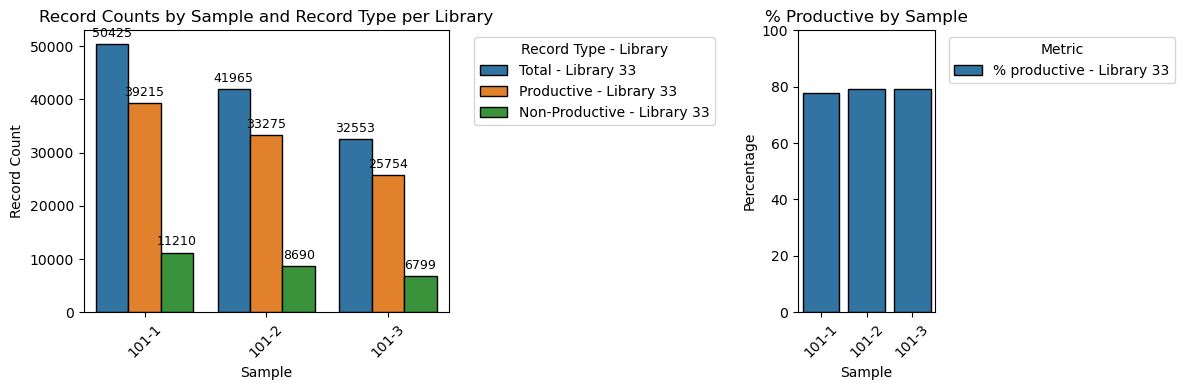

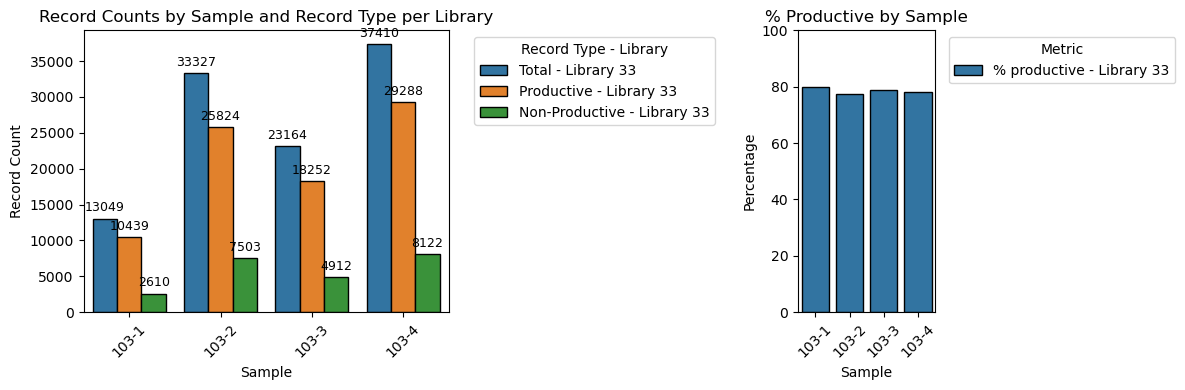

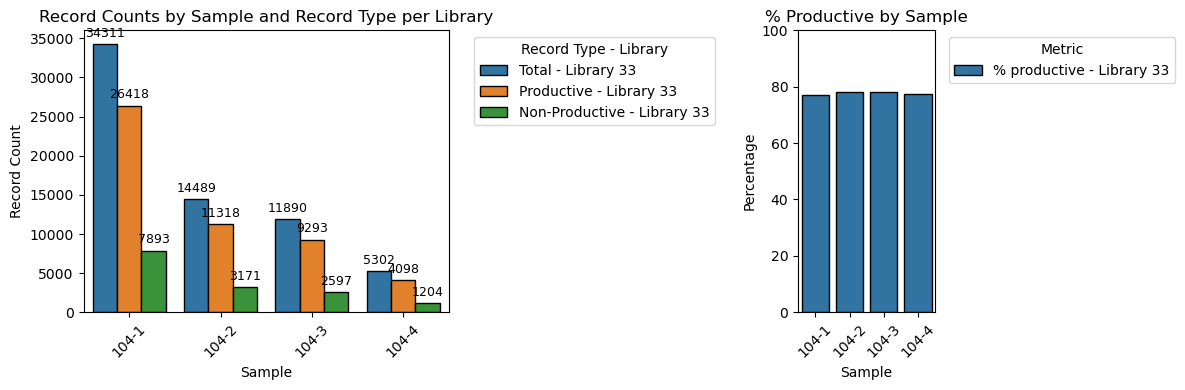

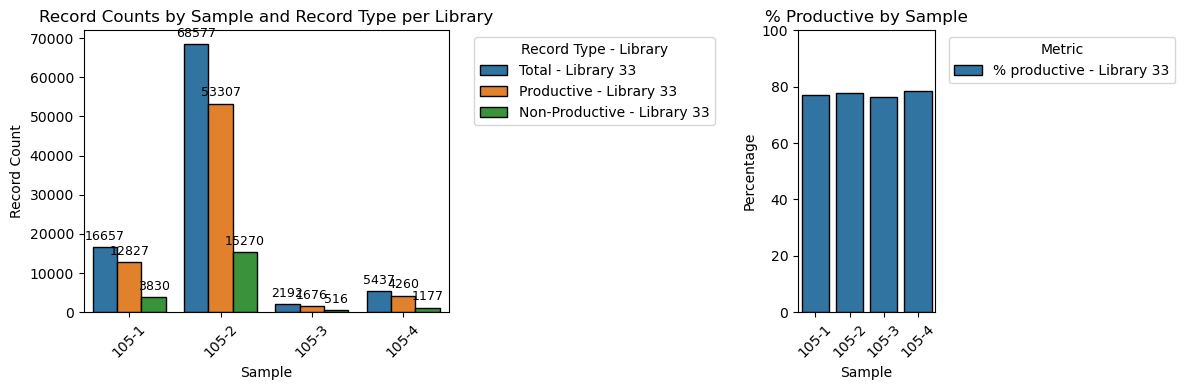

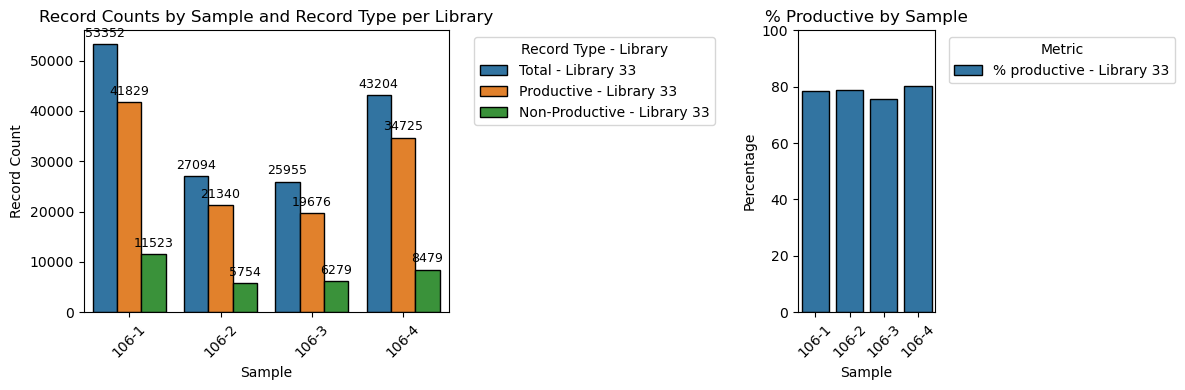

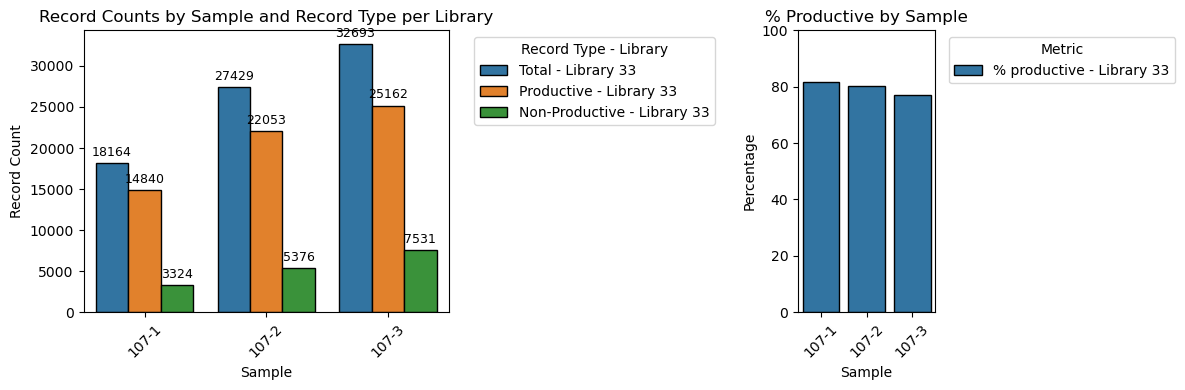

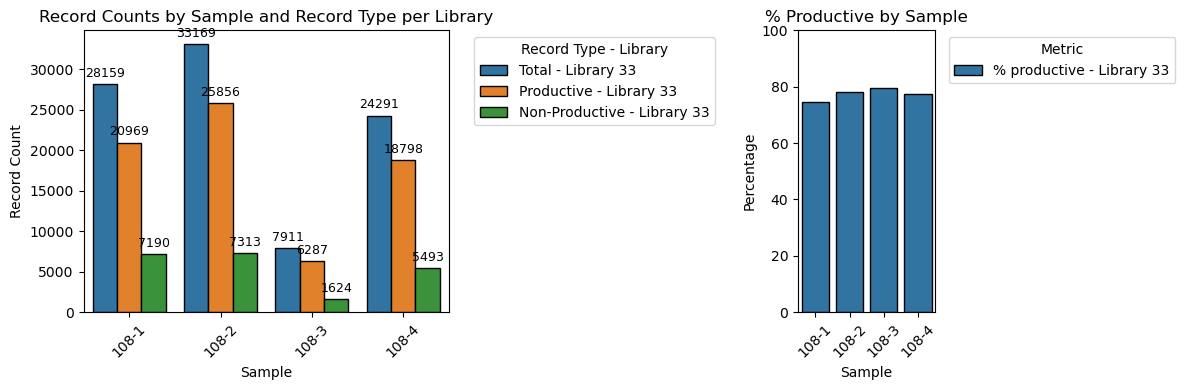

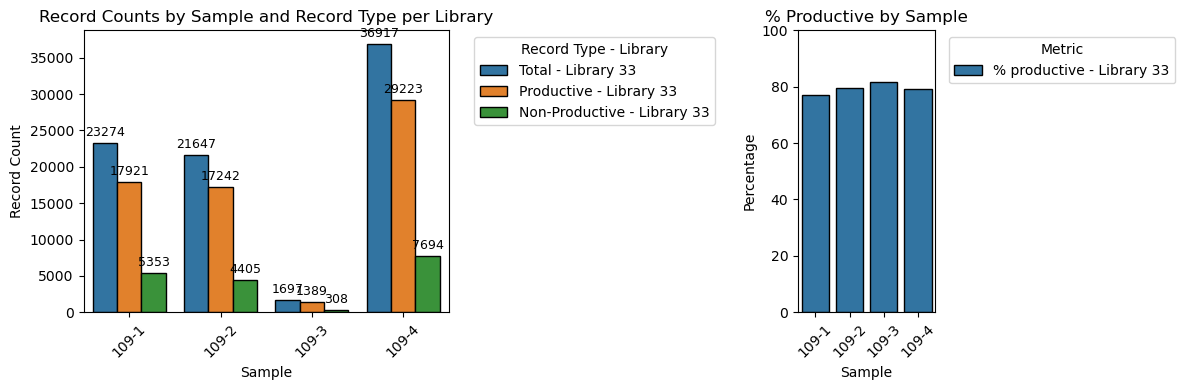

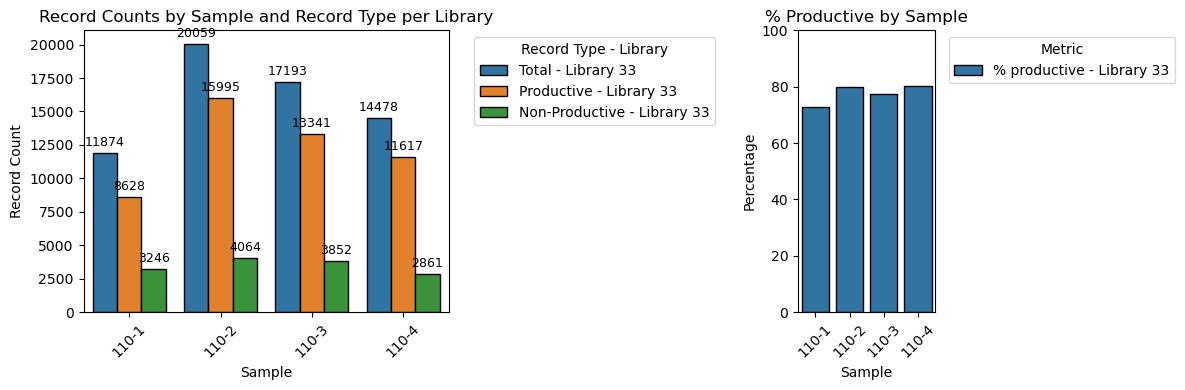

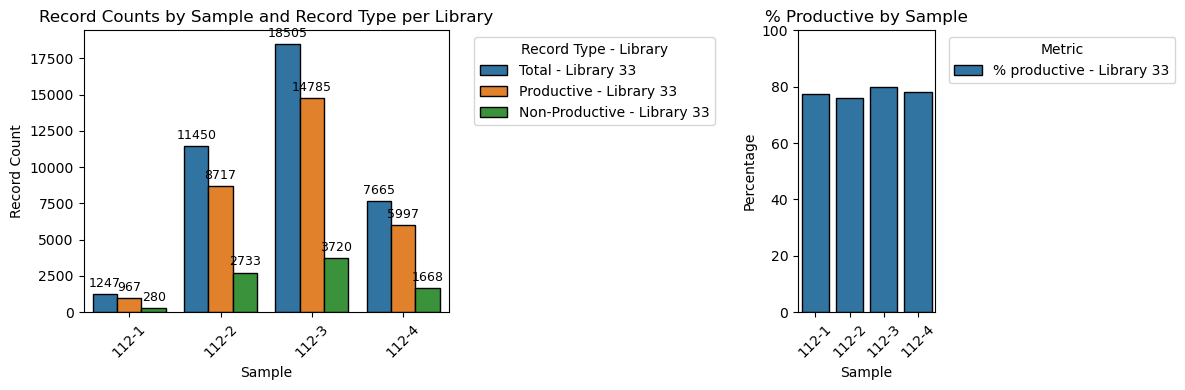

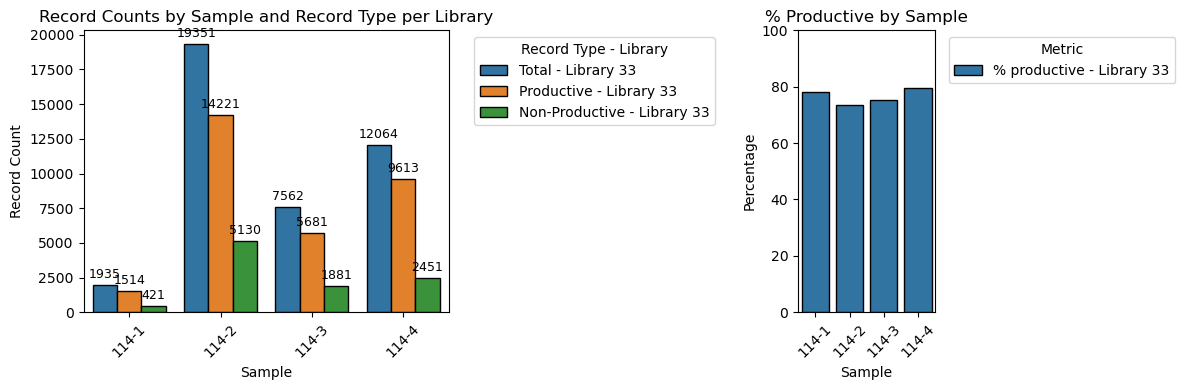

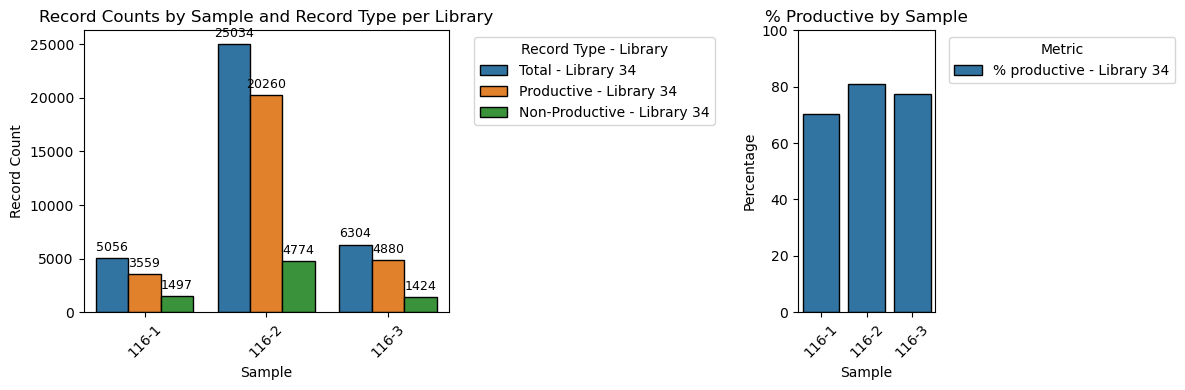

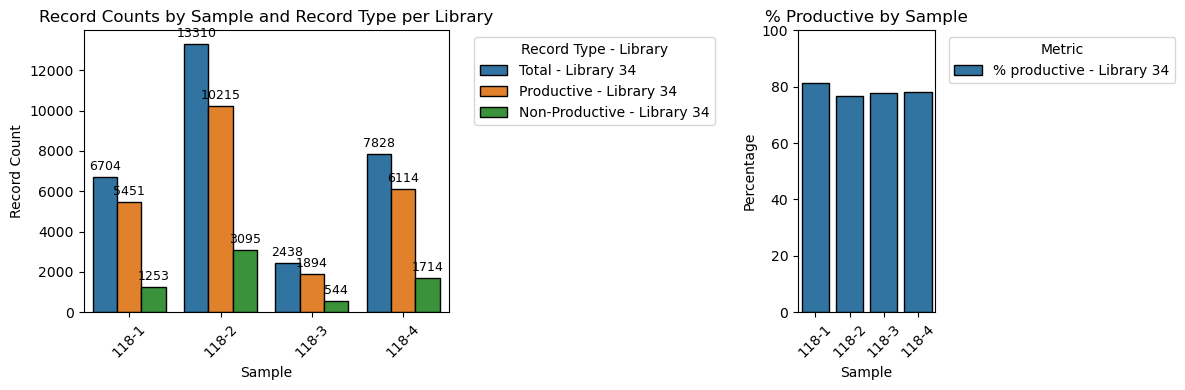

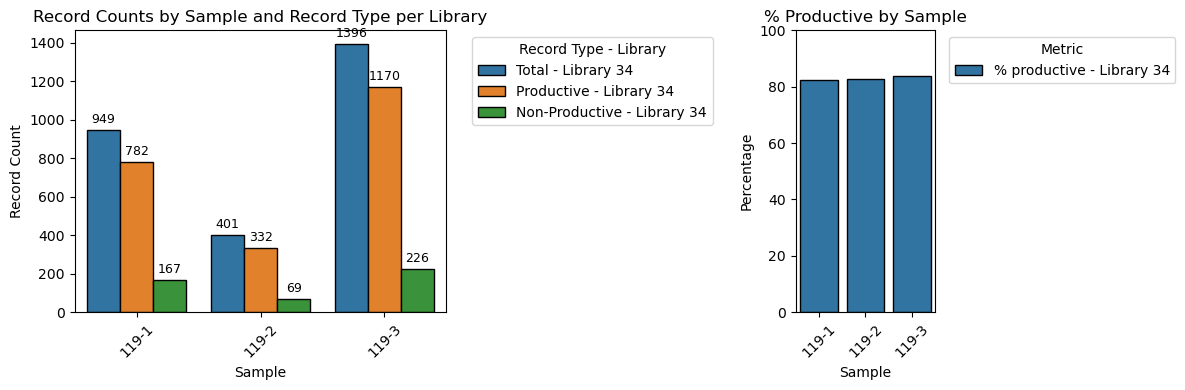

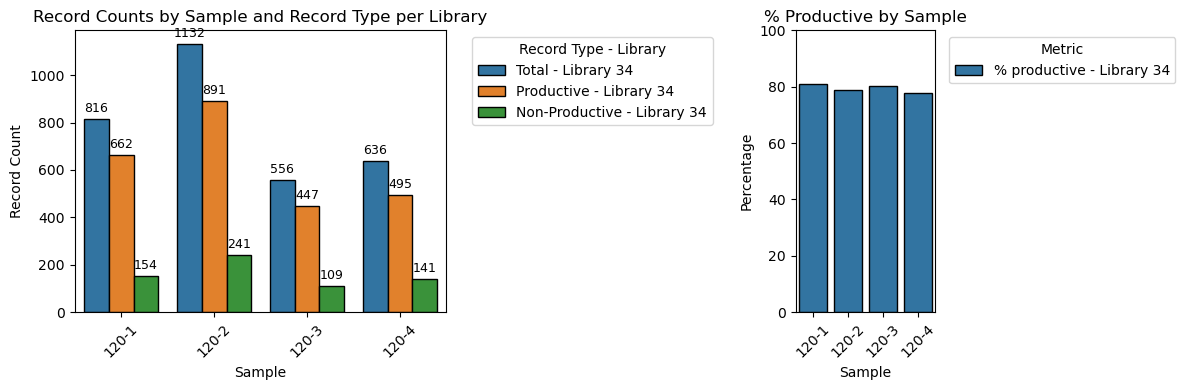

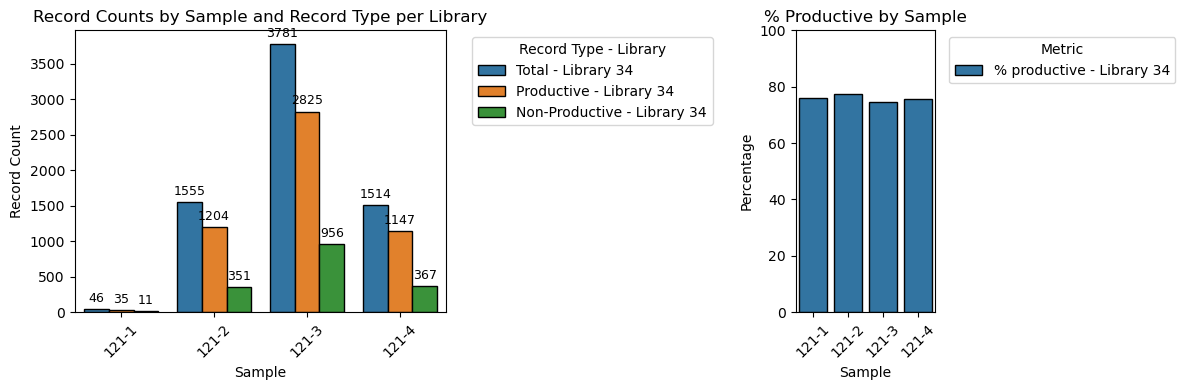

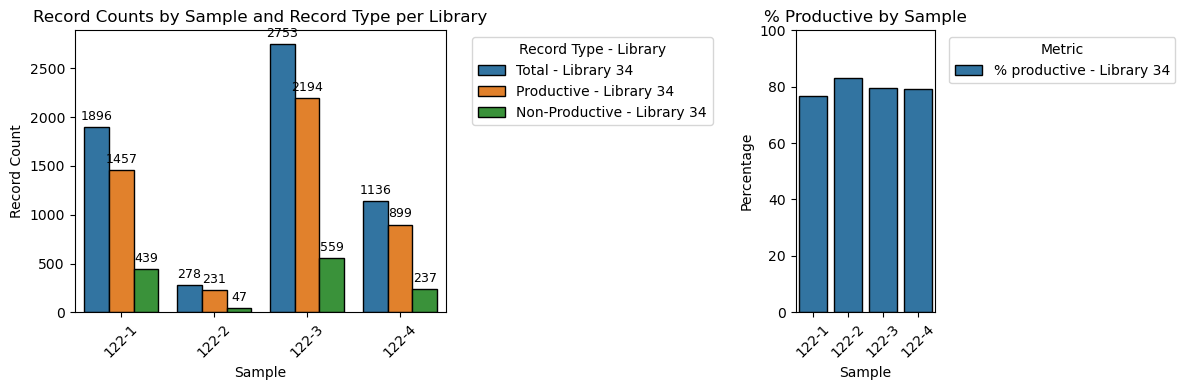

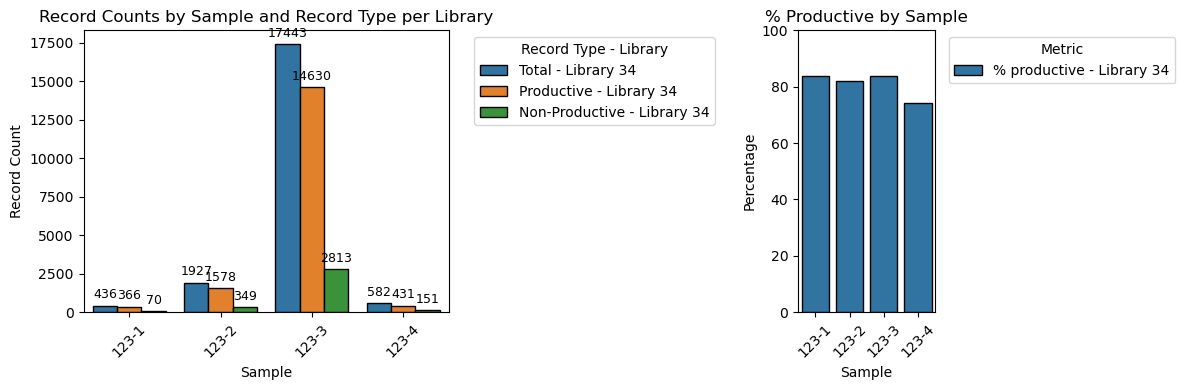

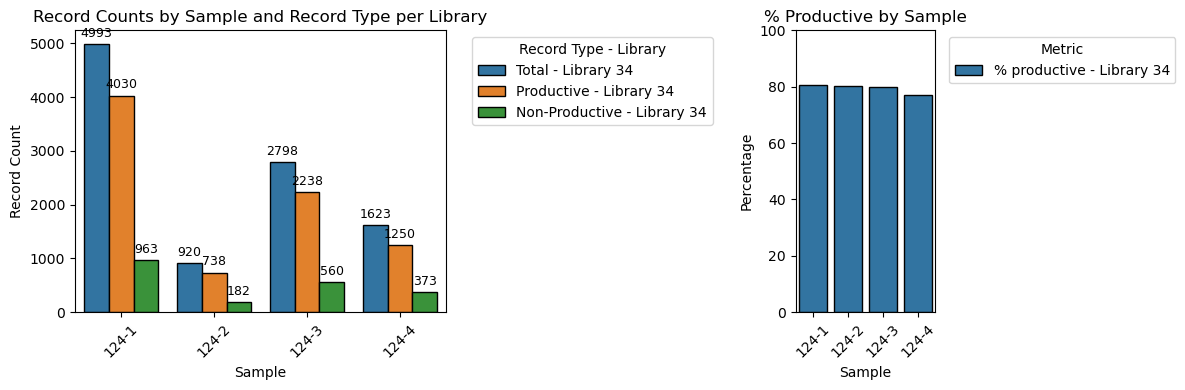

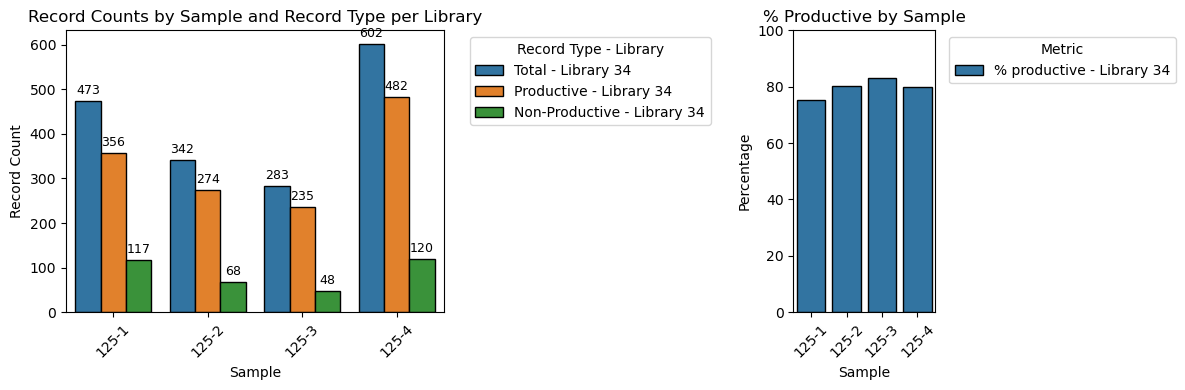

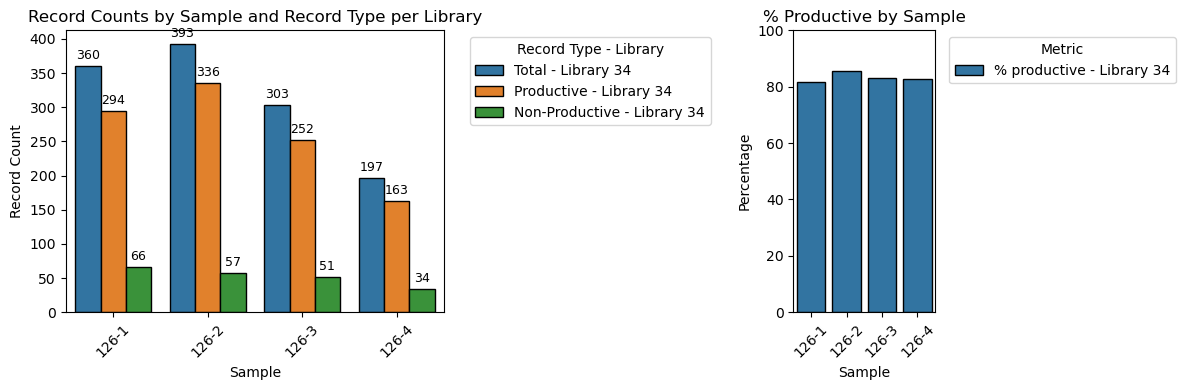

In [109]:
def add_bar_labels(ax, fmt='{:.0f}', padding=3):
    for container in ax.containers:
        ax.bar_label(
            container,
            labels=[fmt.format(v) if v == v else '' for v in container.datavalues],
            padding=padding,
            fontsize=9
        )

temp = sample_info_combined[sample_info_combined.tissue == 'kidney']
unique_patients = temp.subject_id.unique().tolist()
max_ylim = temp['merged reads'].max() + 1000
print("Merged read Max: ", temp['merged reads'].max())
print("Merged read Min: ", temp['merged reads'].min())
for patient in unique_patients:
    samples = temp[temp.subject_id == patient]
    # Read counts melted
    df_long = pd.melt(samples, id_vars=['sample_id', 'library'], value_vars=['total records', 'productive records', 'non-productive records'],
                        var_name='Record Type', value_name='Record Count' )
    
    df_long['Record Type'] = df_long['Record Type'].str.replace(' records', '', regex=False).str.title()
    df_long['Library'] = df_long['library'].str.replace('_', ' ').str.title()
    df_long['Type-Library'] = df_long['Record Type'] + ' - ' + df_long['Library']

    # Percent metrics melted
    df_pct = pd.melt(samples,id_vars=['sample_id', 'library'], value_vars=['% productive'], 
                     var_name='Metric', value_name='Percentage')
    df_pct['Library'] = df_pct['library'].str.replace('_', ' ').str.title()
    df_pct['Type-Library'] = df_pct['Metric'] + ' - ' + df_pct['Library']

    # Create figure with 2 subplots
    fig, ax = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'width_ratios': [4, 1.5]})
    # Plot Read Counts
    sns.barplot(data=df_long, x='sample_id', y='Record Count', hue='Type-Library', palette='tab10', edgecolor='black', ax=ax[0])
    add_bar_labels(ax[0], fmt='{:.0f}', padding=3)
    ax[0].set_title('Record Counts by Sample and Record Type per Library')
    ax[0].set_xlabel('Sample')
    ax[0].set_ylabel('Record Count')
    # ax[0].set_ylim([10, max_ylim])
    ax[0].tick_params(axis='x', rotation=45)
    ax[0].legend(title='Record Type - Library', bbox_to_anchor=(1.05, 1), loc='upper left')
    # Plot % Unique and % Pass
    sns.barplot(data=df_pct, x='sample_id', y='Percentage', hue='Type-Library', palette='tab10', edgecolor='black',ax=ax[1])
    ax[1].set_title('% Productive by Sample')
    ax[1].set_xlabel('Sample')
    ax[1].set_ylabel('Percentage')
    ax[1].set_ylim([0, 100])
    ax[1].tick_params(axis='x', rotation=45)
    ax[1].legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
    # Save and show
    fig.tight_layout()
    figname = fig_dir + f'{patient}_productive_record_count_with_library_and_percentages.png'
    # plt.savefig(figname, bbox_inches='tight', dpi=300)
    plt.show()

## For Each Patient plot % of Productive Vs Non-productive Records for Blood Samples

Merged read Max:  764919
Merged read Min:  98124


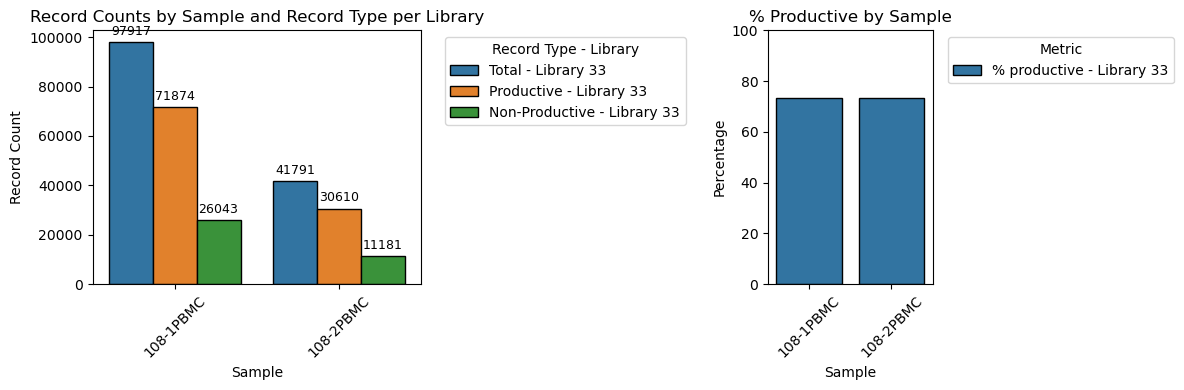

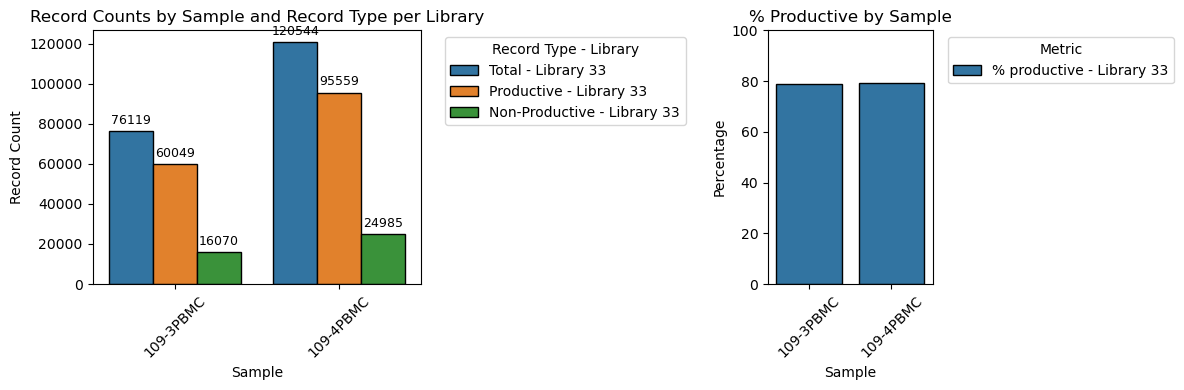

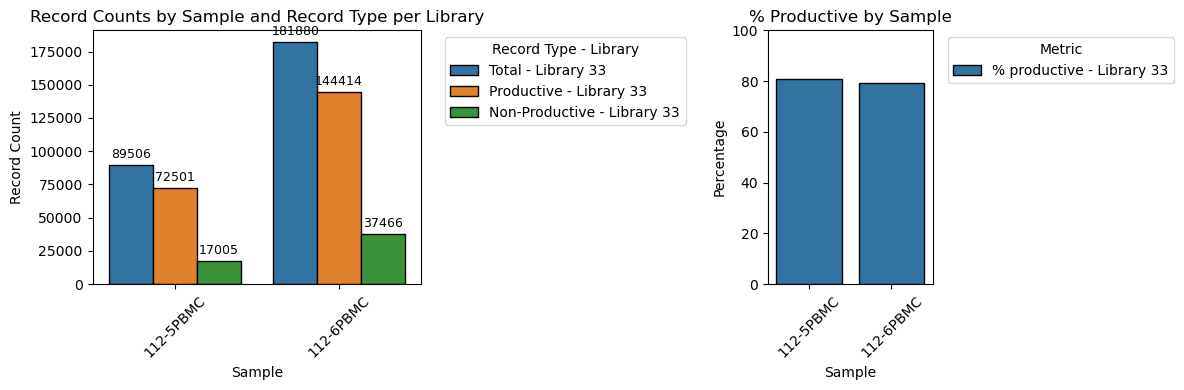

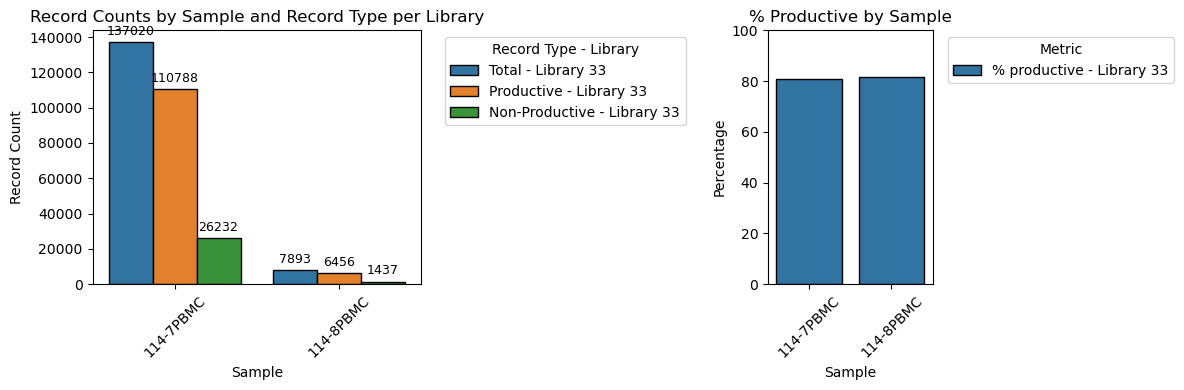

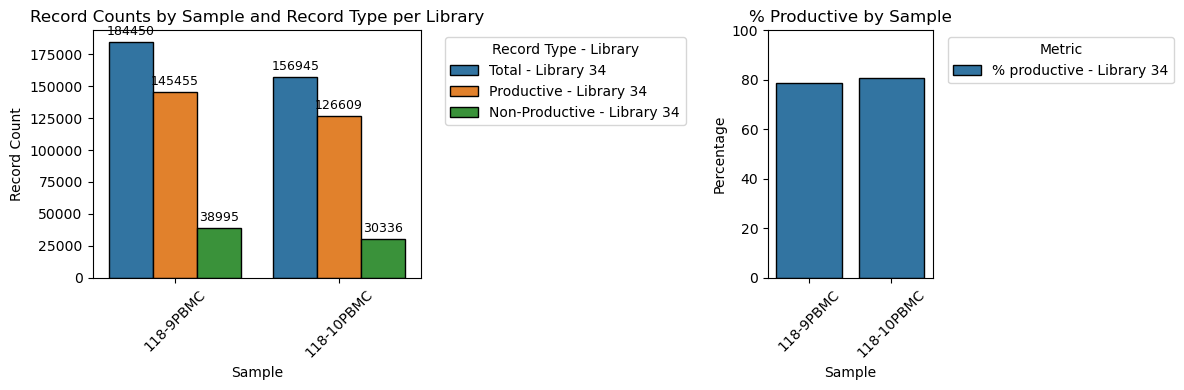

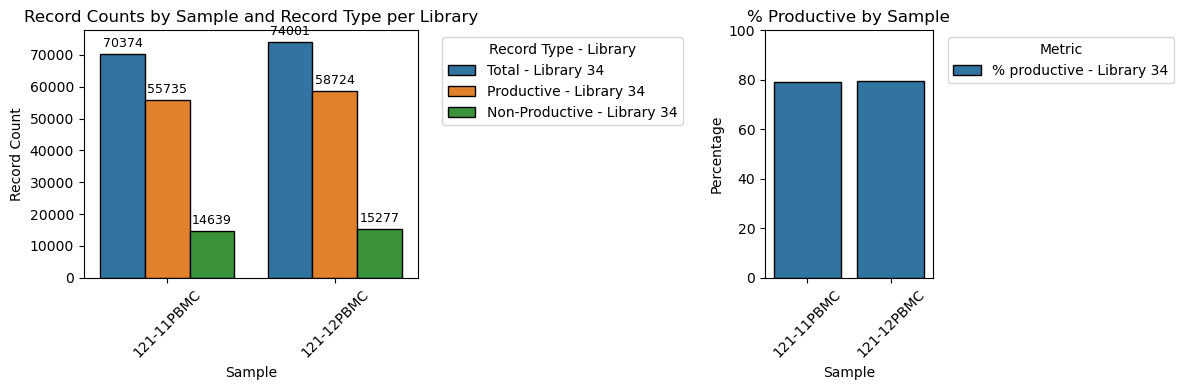

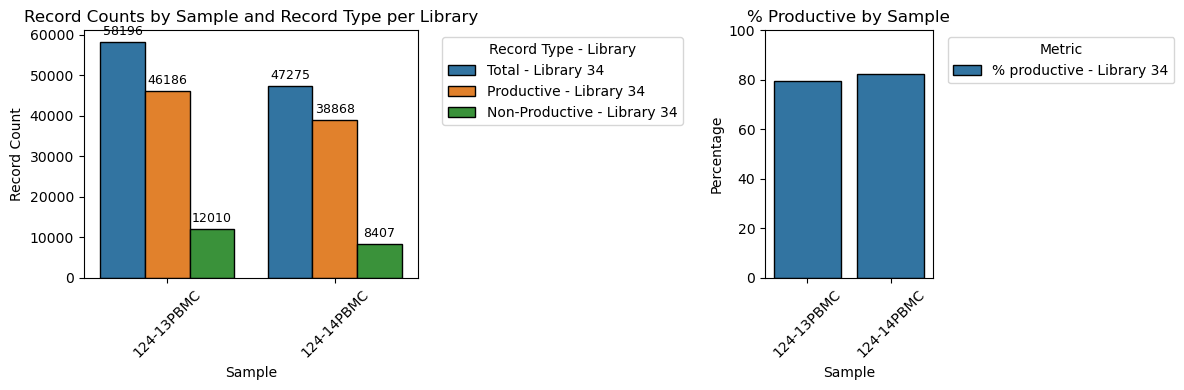

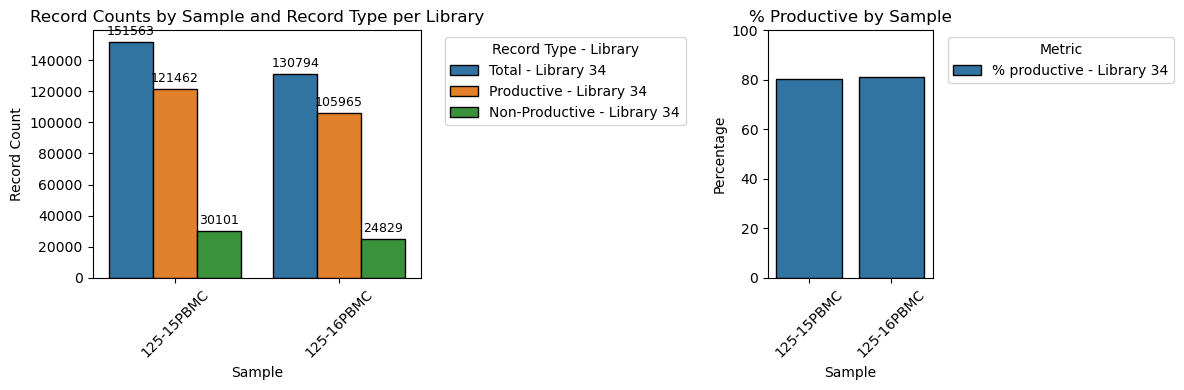

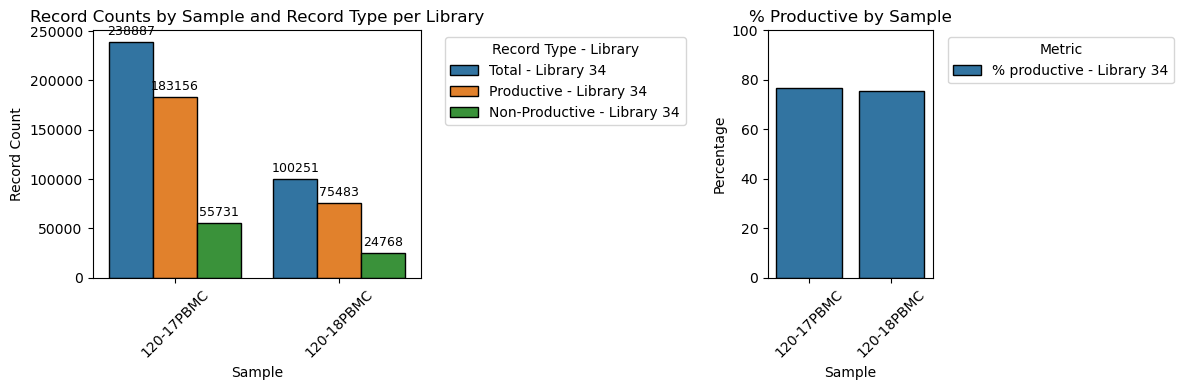

In [108]:
def add_bar_labels(ax, fmt='{:.0f}', padding=3):
    for container in ax.containers:
        ax.bar_label(
            container,
            labels=[fmt.format(v) if v == v else '' for v in container.datavalues],
            padding=padding,
            fontsize=9
        )

temp = sample_info_combined[sample_info_combined.tissue == 'blood']
unique_patients = temp.subject_id.unique().tolist()
max_ylim = temp['merged reads'].max() + 1000
print("Merged read Max: ", temp['merged reads'].max())
print("Merged read Min: ", temp['merged reads'].min())
for patient in unique_patients:
    samples = temp[temp.subject_id == patient]
    # Read counts melted
    df_long = pd.melt(samples, id_vars=['sample_id', 'library'], value_vars=['total records', 'productive records', 'non-productive records'],
                        var_name='Record Type', value_name='Record Count' )
    
    df_long['Record Type'] = df_long['Record Type'].str.replace(' records', '', regex=False).str.title()
    df_long['Library'] = df_long['library'].str.replace('_', ' ').str.title()
    df_long['Type-Library'] = df_long['Record Type'] + ' - ' + df_long['Library']

    # Percent metrics melted
    df_pct = pd.melt(samples,id_vars=['sample_id', 'library'], value_vars=['% productive'], 
                     var_name='Metric', value_name='Percentage')
    df_pct['Library'] = df_pct['library'].str.replace('_', ' ').str.title()
    df_pct['Type-Library'] = df_pct['Metric'] + ' - ' + df_pct['Library']

    # Create figure with 2 subplots
    fig, ax = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'width_ratios': [3, 1.5]})
    # Plot Read Counts
    sns.barplot(data=df_long, x='sample_id', y='Record Count', hue='Type-Library', palette='tab10', edgecolor='black', ax=ax[0])
    add_bar_labels(ax[0], fmt='{:.0f}', padding=3)
    ax[0].set_title('Record Counts by Sample and Record Type per Library')
    ax[0].set_xlabel('Sample')
    ax[0].set_ylabel('Record Count')
    # ax[0].set_ylim([10, max_ylim])
    ax[0].tick_params(axis='x', rotation=45)
    ax[0].legend(title='Record Type - Library', bbox_to_anchor=(1.05, 1), loc='upper left')
    # Plot % Unique and % Pass
    sns.barplot(data=df_pct, x='sample_id', y='Percentage', hue='Type-Library', palette='tab10', edgecolor='black',ax=ax[1])
    ax[1].set_title('% Productive by Sample')
    ax[1].set_xlabel('Sample')
    ax[1].set_ylabel('Percentage')
    ax[1].set_ylim([0, 100])
    ax[1].tick_params(axis='x', rotation=45)
    ax[1].legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
    # Save and show
    fig.tight_layout()
    figname = fig_dir + f'{patient}_productive_record_count_with_library_and_percentages.png'
    # plt.savefig(figname, bbox_inches='tight', dpi=300)
    plt.show()

## Boxplot for each Individual Productive, non-productive and individual count

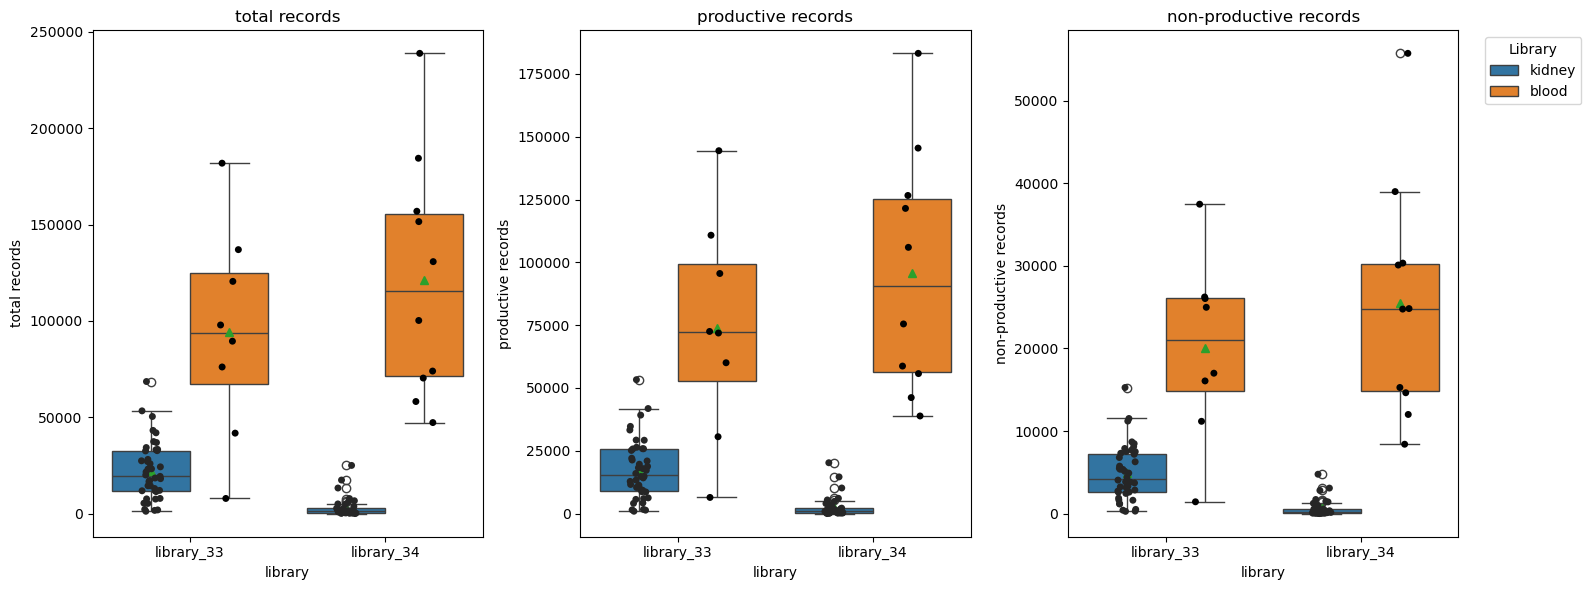

In [21]:
#combine samples from two libraries together
samples = sample_info_combined.copy()
# Create figure with 2 subplots
fig, axs = plt.subplots(1, 3, figsize=(16, 6), sharey = False, sharex = False)
# Plot Read Counts
ax = axs[0]
sns.boxplot(data=samples, x='library', y='total records', hue='tissue', showmeans = True, palette='tab10', ax=ax, legend = False)
sns.stripplot(data=samples, x='library', y='total records', hue='tissue', dodge=True, marker='o', palette = 'dark:black', ax=ax, legend = False)
ax.set_title('total records')

ax = axs[1]
sns.boxplot(data=samples, x='library', y='productive records', hue='tissue', showmeans = True, palette='tab10', ax=ax, legend = False)
sns.stripplot(data=samples, x='library', y='productive records', hue='tissue', dodge=True, marker='o', palette = 'dark:black', ax=ax, legend = False)
ax.set_title('productive records')

ax = axs[2]
sns.boxplot(data=samples, x='library', y='non-productive records', hue='tissue', showmeans = True, palette='tab10', ax=ax, legend = True)
sns.stripplot(data=samples, x='library', y='non-productive records', hue='tissue', dodge=True, marker='o', palette = 'dark:black', ax=ax, legend = False)
ax.set_title('non-productive records')
ax.legend(title='Library', bbox_to_anchor=(1.05, 1), loc='upper left')

fig.tight_layout()
# figname = fig_dir + f'{patient}_read_count_with_library_and_percentages.png'
# plt.savefig(figname, bbox_inches='tight', dpi=300)
plt.show()

## Utility Functions

In [22]:
def time_program(end_time, start_time):
    elapsed = end_time - start_time
    # Convert to hours, minutes, seconds
    hours = int(elapsed // 3600)
    minutes = int((elapsed % 3600) // 60)
    seconds = elapsed % 60
    print(f"Execution time: {hours}h {minutes}m {seconds:.2f}s")

def read_data(filename: str,
              min_len: int = 4,
              max_len: int = 100,):
    cdr3_col = 'junction_aa'
    counts_col = 'duplicate_count'
    read_status = 'productive'
    productive_indicator = 'T'
    # Read in file and rename columns for consistency
    cdr3s = pd.read_csv(filename, usecols=[cdr3_col, counts_col, read_status], delimiter="\t", low_memory=False)
    cdr3s.rename(columns={cdr3_col: "cdr3", counts_col: "counts", read_status: "read_status"}, inplace=True)
    # Drop non-productive sequences
    cdr3s = cdr3s[cdr3s.read_status == productive_indicator].drop("read_status", axis=1)
    # Remove sequences that are too long or too short
    cdr3s = cdr3s[cdr3s.cdr3.str.len() >= min_len]
    cdr3s = cdr3s[cdr3s.cdr3.str.len() <= max_len]
    # Remove sequences with 0 counts
    cdr3s = cdr3s[cdr3s.counts > 0.0]
    # Remove sequences with X, * or B character
    cdr3s = cdr3s[~cdr3s.cdr3.str.contains(r'[X\*B]')]
    total_rearrangements = cdr3s.shape[0]
    # Combine duplicate sequences and sum their counts
    cdr3s = cdr3s.groupby(cdr3s.cdr3).aggregate({"counts": 'sum'}).reset_index()
    unique_rearrangements = cdr3s.shape[0]
    return cdr3s, total_rearrangements, unique_rearrangements

## Read CDR3s from TSV File and Create an Information DB

In [65]:
start = time.time()
info_list = []
cdr3_info = []
top_n_largest_clone = []
n = 10
for idx, row in sample_info_combined.iterrows():
    start_time = time.time()
    repertoire_id = row['repertoire_id']
    sample_id = row['sample_id']
    subject_id = row['subject_id']
    # Get file names
    
    file_name = f'{igblast_dir}/{repertoire_id}.igblast.makedb.airr.tsv.gz'
    cdr3s, total_rearrangements, unique_rearrangements = read_data(file_name)
    
    cdr3_lengths = cdr3s.cdr3.apply(len).to_list()
    cdr3_count = cdr3s.counts.to_list()
    largest_clone_size = max(cdr3_count)
    longest_cdr3_length = max(cdr3_lengths)
    top_n_cdr3 = cdr3s.sort_values(by = 'counts', ascending = False)[['cdr3', 'counts']].iloc[:n]
    largest_clone = top_n_cdr3.iloc[0].cdr3
    # Append result
    info_list.append({
        'subject_id': subject_id,
        'sample_id': sample_id,
        'total_rearrangements': total_rearrangements,
        'unique_rearrangements': unique_rearrangements,
        'largest_clone': largest_clone,
        'largest_clone_size' :largest_clone_size,
        'longest_cdr3_length': longest_cdr3_length,
    })

    # Append CDR3-specific info to cdr3_info
    for length, count in zip(cdr3_lengths, cdr3_count):
        cdr3_info.append({
            'subject_id': subject_id,
            'sample_id': sample_id,
            'cdr3_length': length,
            'cdr3_count': count
        })


    for index, item in top_n_cdr3.iterrows():
        top_n_largest_clone.append({
            'subject_id': subject_id,
            'sample_id': sample_id,
            'cdr3': item['cdr3'],
            'cdr3_count': item['counts']
        })
    # time_program(time.time(), start_time)
end_time = time.time()
time_program(end_time, start)

#create subject information dataframe
subject_info = pd.DataFrame(info_list)

#Create CDR3 information dataframe 
cdr3_info = pd.DataFrame(cdr3_info)

# Create top n largest clone information dataframe with each CDR3 and their counts
top_n_largest_clone_df = pd.DataFrame(top_n_largest_clone)
top_n_largest_clone_df.head()

Execution time: 0h 0m 55.51s


subject_id sample_id             cdr3  cdr3_count
0        101     101-1      CASSSNYEQYF        2360
1        101     101-1     CASSLRGTEAFF        2333
2        101     101-1    CASGTGYNSPLHF        1826
3        101     101-1  CSVLIRTLAKNIQYF         689
4        101     101-1      CAWSLDSEAFF         683

In [107]:
# subject_info = subject_info.merge(sample_info_combined, on = ['sample_id', 'subject_id'], how = 'inner')
# cdr3_info = cdr3_info.merge(sample_info_combined, on = ['sample_id', 'subject_id'], how = 'inner')
# top_n_largest_clone_df = top_n_largest_clone_df.merge(sample_info_combined, on = ['sample_id', 'subject_id'], how = 'inner')
# subject_info
# cdr3_info
subject_info.to_csv('sample_information_combined.csv', sep = ',')

## Rearrangement Count 

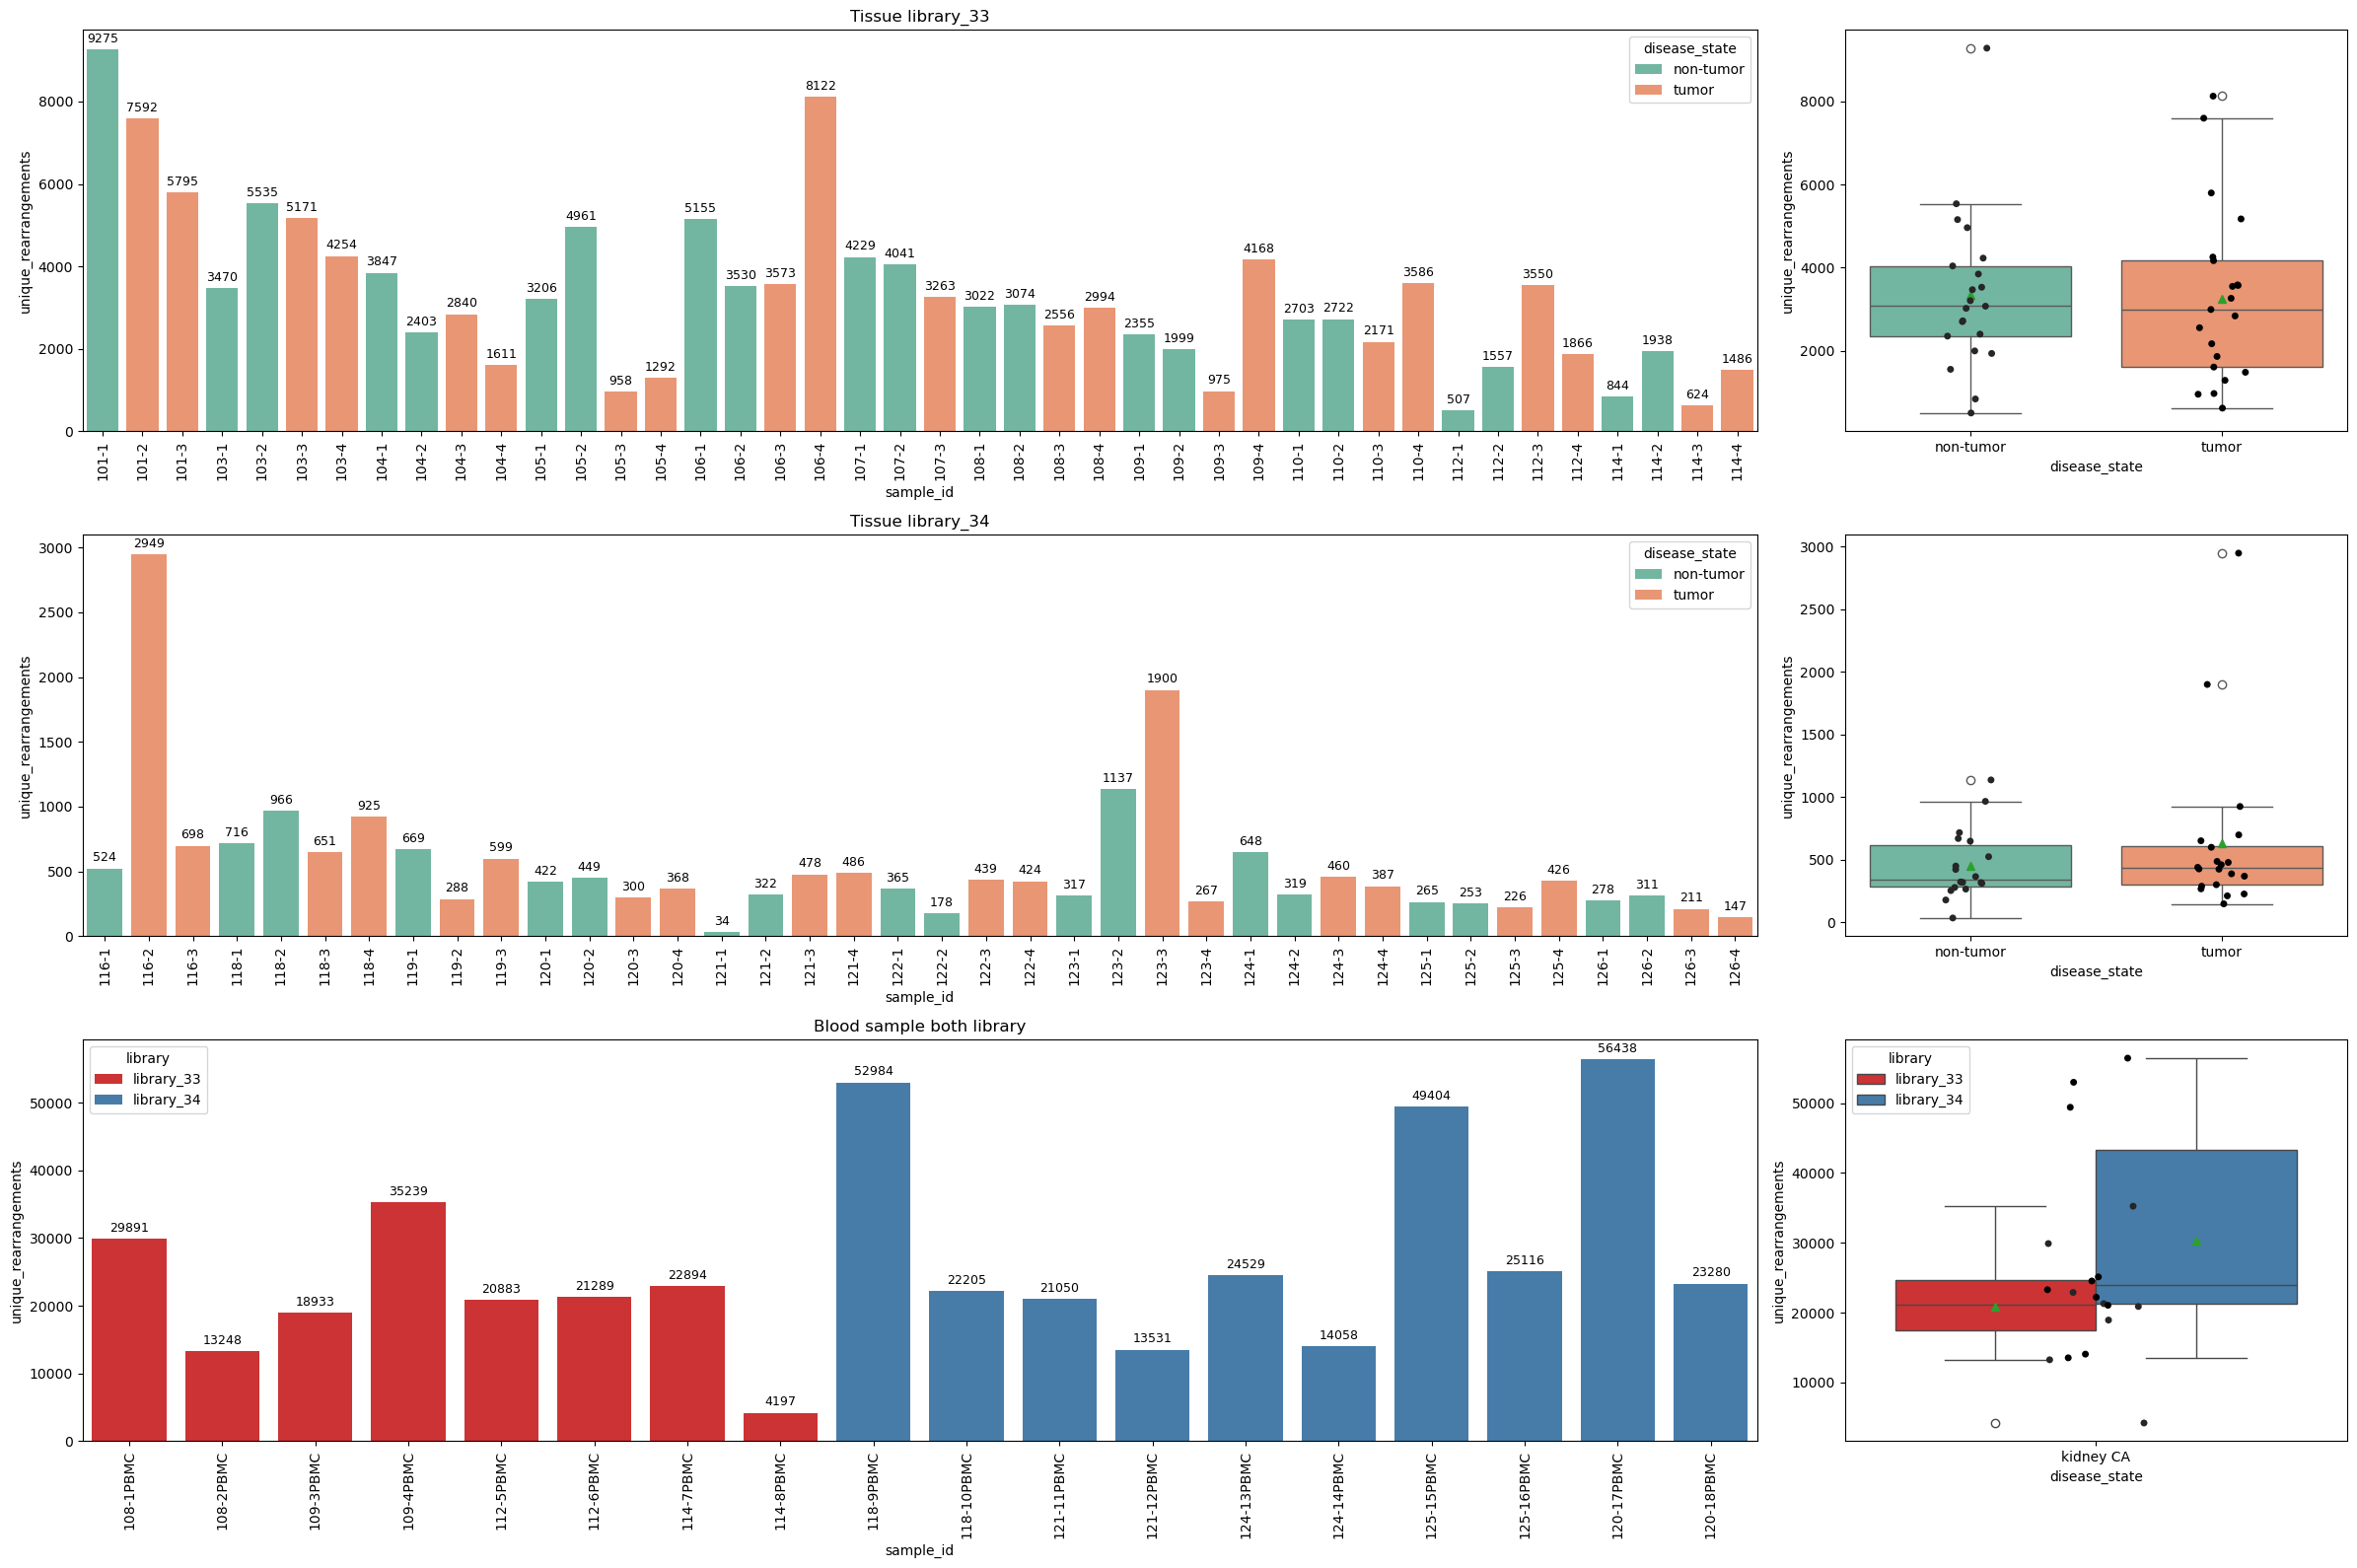

In [111]:
def add_bar_labels(ax, fmt='{:.0f}', padding=3):
    for container in ax.containers:
        ax.bar_label(
            container,
            labels=[fmt.format(v) if v == v else '' for v in container.datavalues],
            padding=padding,
            fontsize=9
        )

hue_order = ['non-tumor', 'tumor']
# Create the barplot
fig, axs = plt.subplots(3, 2, figsize = (24, 16),  gridspec_kw={'width_ratios': [5, 1.5]}, sharex = False)
ax = axs[0, 0]
df = subject_info[(subject_info.library == 'library_33') & (subject_info.tissue != 'blood')]
sns.barplot(x="sample_id", y="unique_rearrangements", hue="disease_state", data=df, hue_order = hue_order, ax = ax, palette = 'Set2')
add_bar_labels(ax, fmt='{:.0f}', padding=3)
ax.set_title('Tissue library_33')
ax.tick_params(axis='x', rotation=90)
ax = axs[0, 1]
sns.boxplot(x="disease_state", y="unique_rearrangements", hue="disease_state", data=df, hue_order = hue_order, showmeans = True, ax = ax, palette = 'Set2')
sns.stripplot(x="disease_state", y="unique_rearrangements", hue="disease_state", data=df,  ax = ax, palette = 'dark:black', legend = False)



ax = axs[1, 0]
df = subject_info[(subject_info.library == 'library_34')& (subject_info.tissue != 'blood')]
sns.barplot(x="sample_id", y="unique_rearrangements", hue="disease_state", data=df, ax = ax, palette = 'Set2')
add_bar_labels(ax, fmt='{:.0f}', padding=3)
ax.set_title('Tissue library_34')
ax.tick_params(axis='x', rotation=90)
ax = axs[1, 1]
sns.boxplot(x="disease_state", y="unique_rearrangements", hue="disease_state", data=df, hue_order = hue_order, showmeans = True, ax = ax, palette = 'Set2')
sns.stripplot(x="disease_state", y="unique_rearrangements", hue="disease_state", data=df,  ax = ax, palette = 'dark:black', legend = False)


ax = axs[2, 0]
df = subject_info[subject_info.tissue == 'blood']
sns.barplot(x="sample_id", y="unique_rearrangements", hue="library", data=df, ax = ax, palette = 'Set1')
add_bar_labels(ax, fmt='{:.0f}', padding=3)
ax.set_title('Blood sample both library')
ax.tick_params(axis='x', rotation=90)
ax = axs[2, 1]
sns.boxplot(x="disease_state", y="unique_rearrangements", hue="library", data=df, showmeans = True, ax = ax, palette = 'Set1')
sns.stripplot(x="disease_state", y="unique_rearrangements", hue="library", data=df,  ax = ax, palette = 'dark:black', legend = False)
plt.tight_layout()

plt.show()





## Plot Largest Clone Size for Each Sample Tissue Only

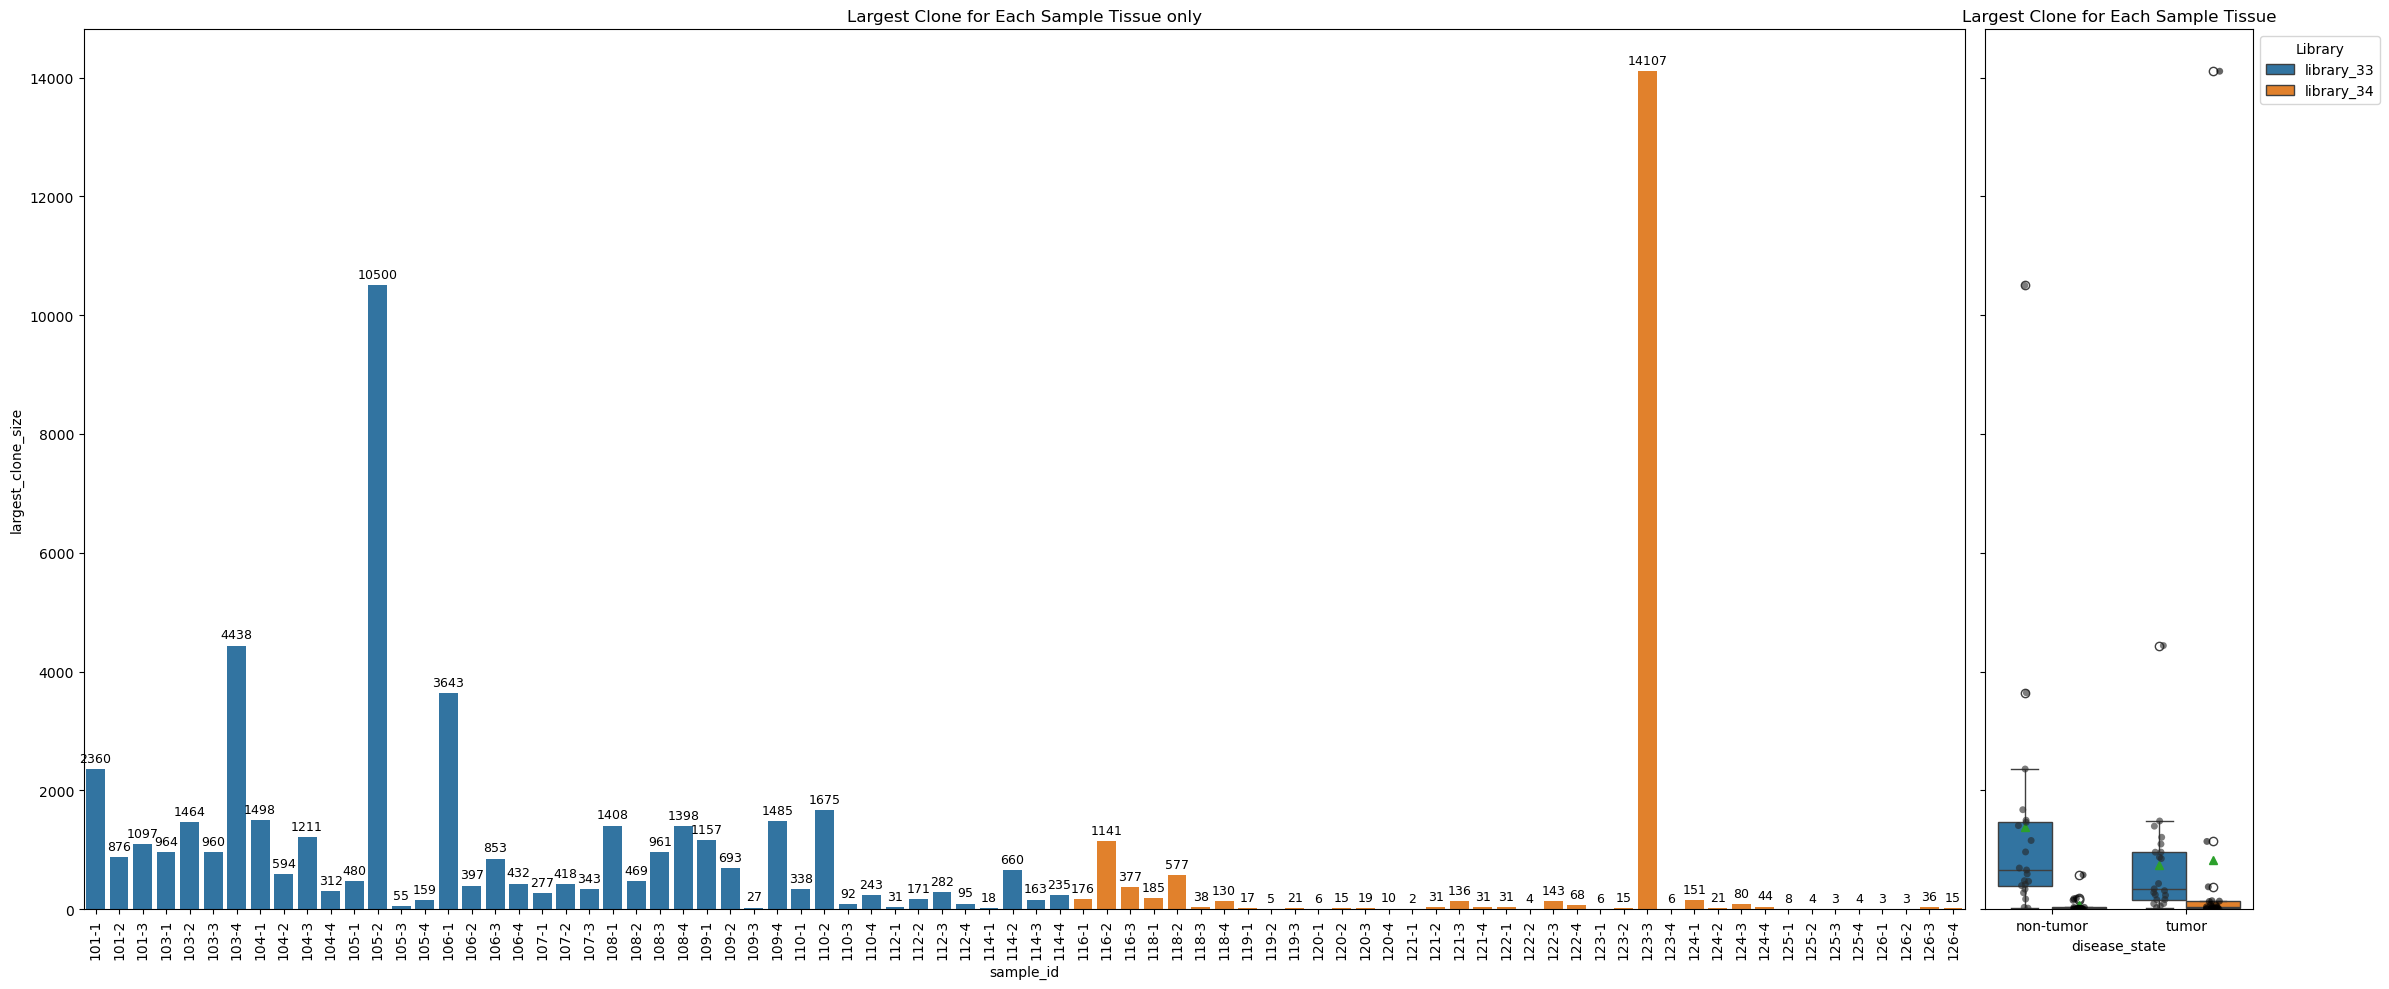

In [119]:
df = subject_info.copy()
df = df[df.tissue == 'kidney']
# # Create the boxplot
fig, ax = plt.subplots(1,2, figsize = (24, 10), gridspec_kw={'width_ratios': [7, 1]}, sharey = True)
sns.barplot(data = df, x = 'sample_id', y = 'largest_clone_size', hue = 'library', legend = False, ax = ax[0])
add_bar_labels(ax[0], fmt='{:.0f}', padding=3)
ax[0].set_title("Largest Clone for Each Sample Tissue only")
ax[0].tick_params(axis='x', labelrotation = 90)

sns.boxplot(data = df, x = 'disease_state', y = 'largest_clone_size', hue = 'library', showmeans = True,  ax = ax[1])
ax[1].legend( title='Library', bbox_to_anchor=(1, 1), loc='upper left')
sns.stripplot(data=df, x='disease_state', y='largest_clone_size', palette='dark:black', hue = 'library', jitter=True, dodge= True, alpha=0.6, ax = ax[1], legend = False)
ax[1].set_title("Largest Clone for Each Sample Tissue")
plt.tight_layout()
figname = fig_dir + 'largest_clone_size_by_library.png'
# plt.savefig(figname, bbox_inches = 'tight', dpi = 300)
plt.show()

## Plot Largest Clone Size for Each Sample Blood Only

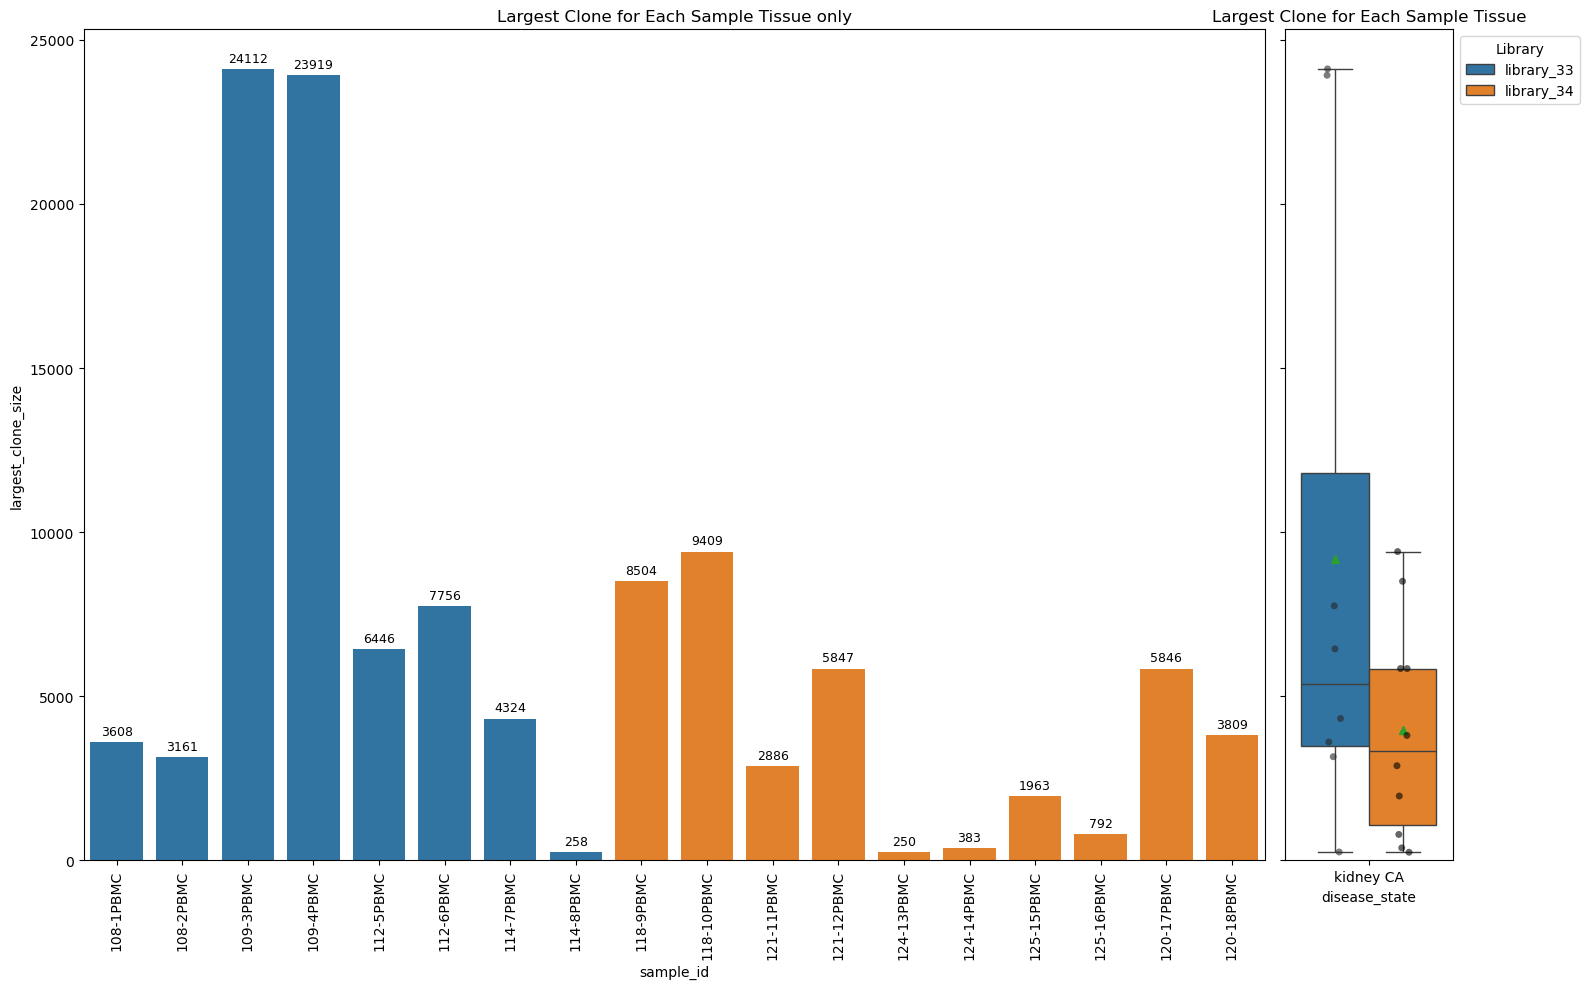

In [120]:
df = subject_info.copy()
df = df[df.tissue == 'blood']

fig, ax = plt.subplots(1,2, figsize = (16, 10), gridspec_kw={'width_ratios': [7, 1]}, sharey = True)
sns.barplot(data = df, x = 'sample_id', y = 'largest_clone_size', hue = 'library', legend = False, ax = ax[0])
add_bar_labels(ax[0], fmt='{:.0f}', padding=3)
ax[0].set_title("Largest Clone for Each Sample Tissue only")
ax[0].tick_params(axis='x', labelrotation = 90)

sns.boxplot(data = df, x = 'disease_state', y = 'largest_clone_size', hue = 'library', showmeans = True,  ax = ax[1])
ax[1].legend( title='Library', bbox_to_anchor=(1, 1), loc='upper left')
sns.stripplot(data=df, x='disease_state', y='largest_clone_size', palette='dark:black', hue = 'library', jitter=True, dodge= True, alpha=0.6, ax = ax[1], legend = False)
ax[1].set_title("Largest Clone for Each Sample Tissue")
plt.tight_layout()
figname = fig_dir + 'largest_clone_size_by_library.png'
# plt.savefig(figname, bbox_inches = 'tight', dpi = 300)
plt.show()

## Total rearrangements Vs Unique Rearrangements for Tissue


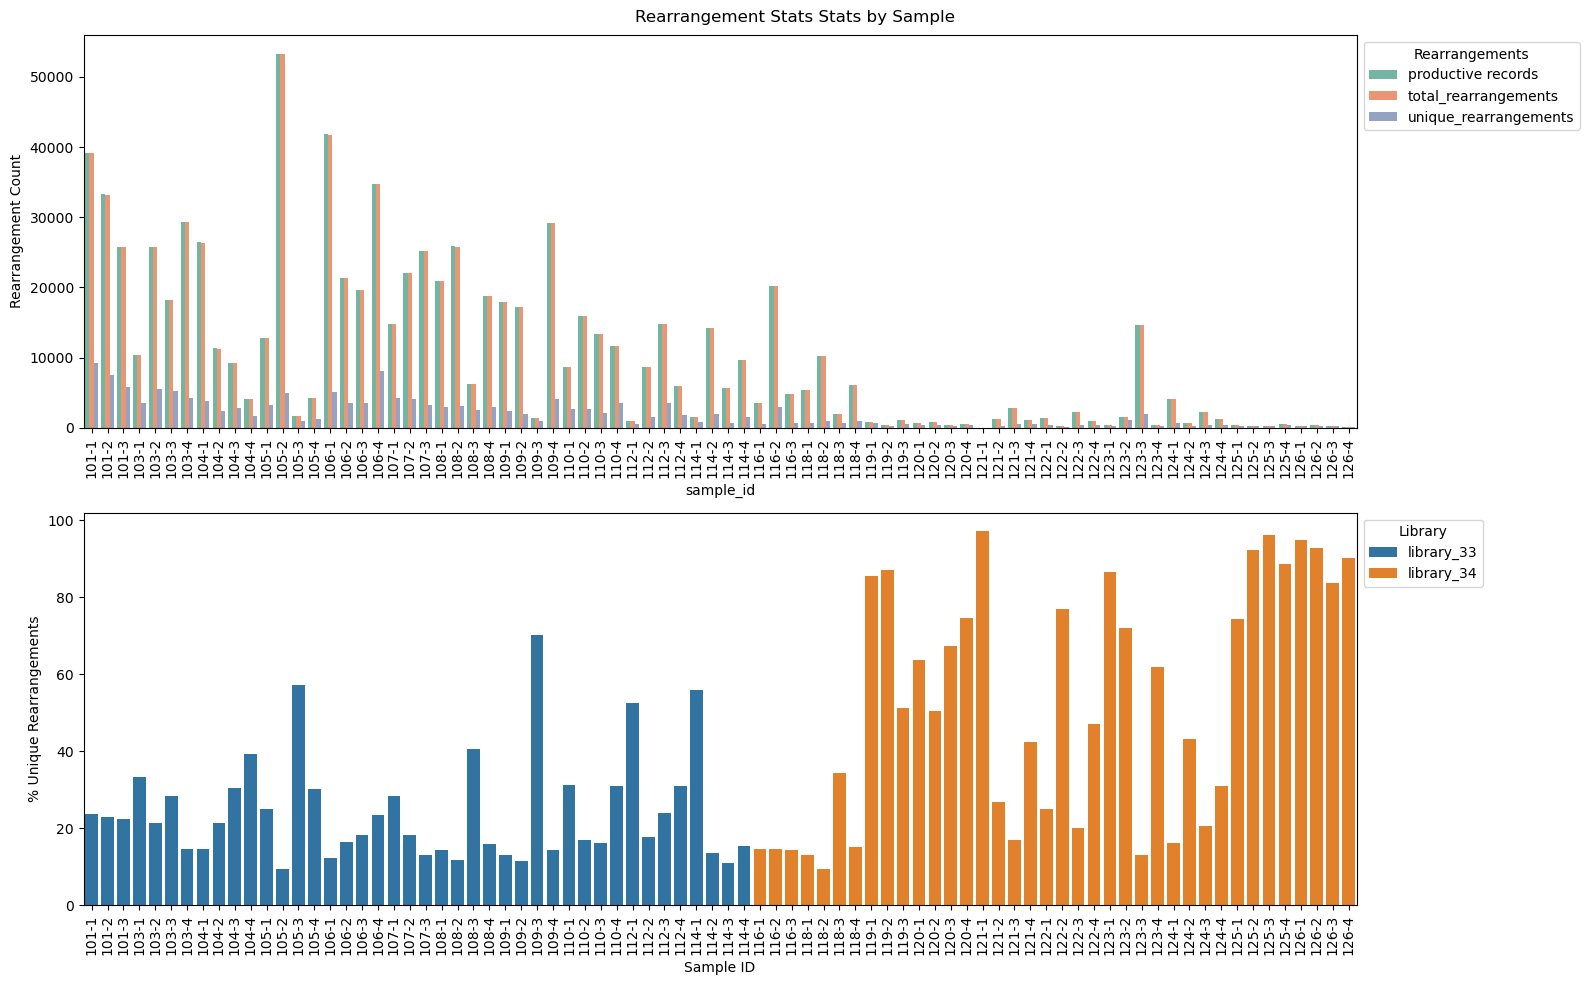

In [77]:
df = subject_info.copy()
df = df[df.tissue == 'kidney']
df['% Unique'] = (df['unique_rearrangements'] / df['total_rearrangements']) * 100
# Reshape the DataFrame for easier plotting
df_melted = df.melt(id_vars="sample_id", value_vars = ['productive records', 'total_rearrangements',  'unique_rearrangements'], 
                             var_name="rearrangement_count", value_name="value")

# Create the barplot
fig, axs = plt.subplots(2, 1, figsize = (16, 10), sharex = False)
sns.barplot(x="sample_id", y="value", hue="rearrangement_count", data=df_melted, ax = axs[0], palette = 'Set2')
axs[0].tick_params(axis='x', rotation=90)
sns.barplot(x="sample_id", y="% Unique", hue = 'library',  data=df, ax = axs[1])
axs[0].set_ylabel('Rearrangement Count')
axs[1].set_ylabel('% Unique Rearrangements')


axs[0].legend(title = "Rearrangements", loc='upper left', bbox_to_anchor = (1, 1))
axs[1].legend(title = "Library", loc='upper left', bbox_to_anchor = (1, 1))

# Customize the plot
plt.suptitle("Rearrangement Stats Stats by Sample")
plt.xlabel("Sample ID")

axs[1].tick_params(axis='x', rotation=90)
plt.tight_layout()
figname = fig_dir + 'rearrangement_with_unique_percentage_count.png'
# plt.savefig(figname, bbox_inches = 'tight', dpi = 300)
# Show the plot
plt.show()


## Total rearrangements Vs Unique Rearrangements for Blood

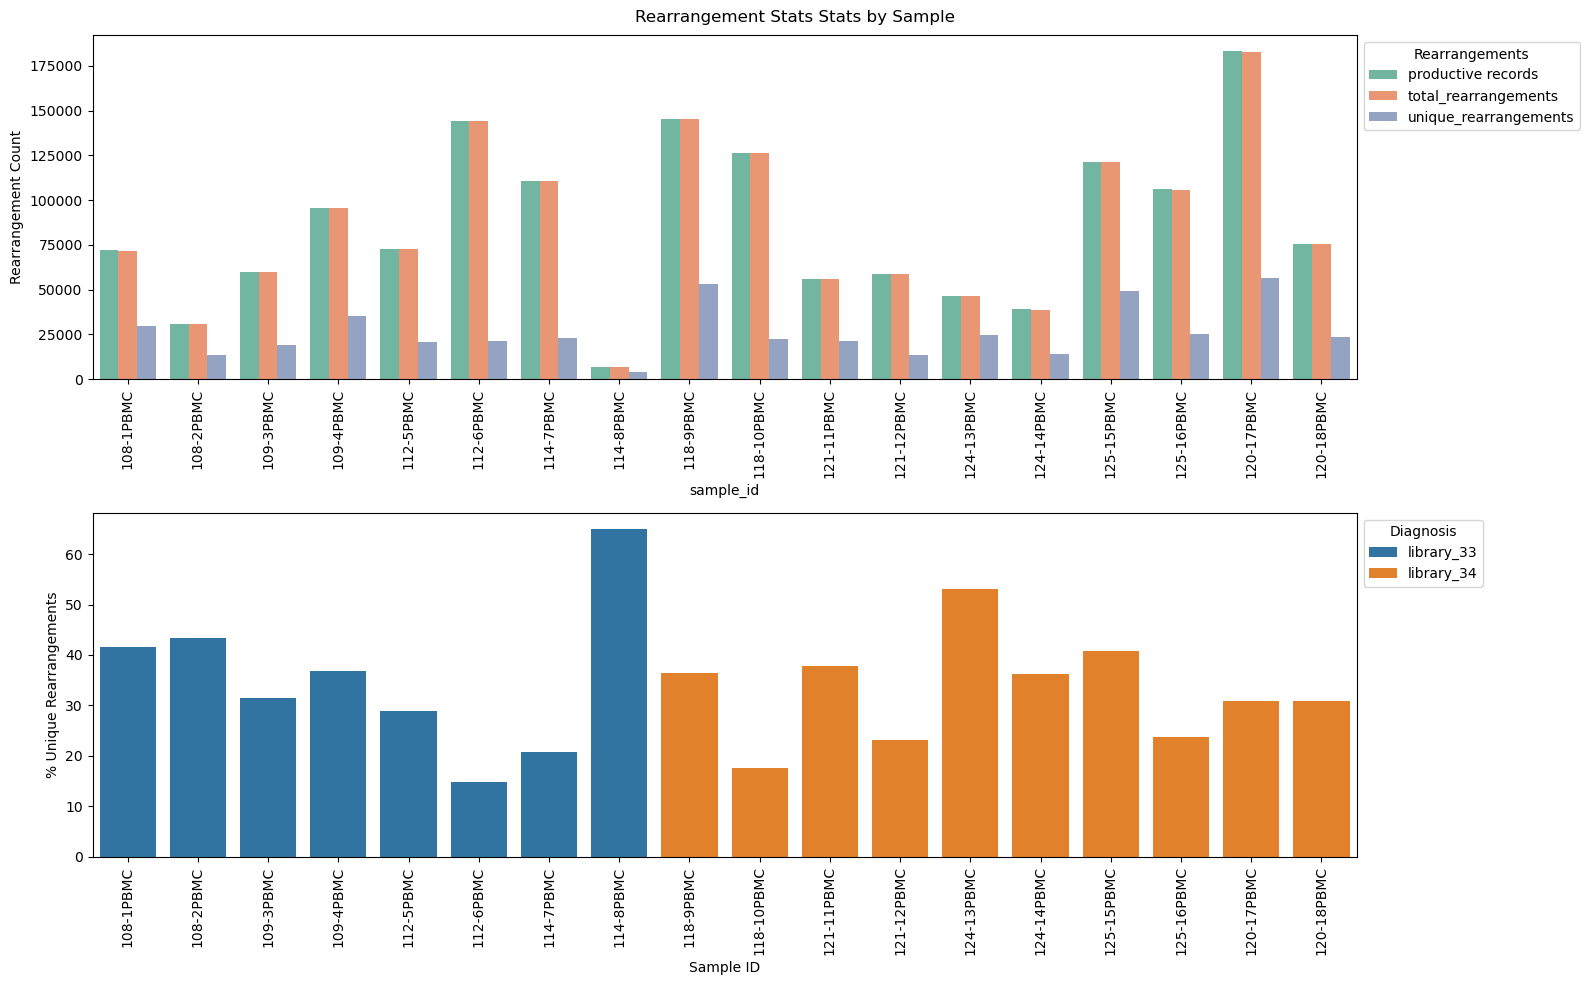

In [40]:
df = subject_info.copy()
df = df[df.tissue == 'blood']
df['% Unique'] = (df['unique_rearrangements'] / df['total_rearrangements']) * 100
# Reshape the DataFrame for easier plotting
df_melted = df.melt(id_vars="sample_id", value_vars = ['productive records', 'total_rearrangements',  'unique_rearrangements'], 
                             var_name="rearrangement_count", value_name="value")

# Create the barplot
fig, axs = plt.subplots(2, 1, figsize = (16, 10), sharex = False)
sns.barplot(x="sample_id", y="value", hue="rearrangement_count", data=df_melted, ax = axs[0], palette = 'Set2')
axs[0].tick_params(axis='x', rotation=90)
sns.barplot(x="sample_id", y="% Unique", hue = 'library',  data=df, ax = axs[1])
axs[0].set_ylabel('Rearrangement Count')
axs[1].set_ylabel('% Unique Rearrangements')


axs[0].legend(title = "Rearrangements", loc='upper left', bbox_to_anchor = (1, 1))
axs[1].legend(title = "Diagnosis", loc='upper left', bbox_to_anchor = (1, 1))

# Customize the plot
plt.suptitle("Rearrangement Stats Stats by Sample")
plt.xlabel("Sample ID")

axs[1].tick_params(axis='x', rotation=90)
plt.tight_layout()
figname = fig_dir + 'rearrangement_with_unique_percentage_count.png'
# plt.savefig(figname, bbox_inches = 'tight', dpi = 300)
# Show the plot
plt.show()


In [30]:
# subject_info[subject_info.unique_rearrangements < 1000][['total_rearrangements', 'unique_rearrangements', 'largest_clone_size', 'patient_id', 'library', 'disease_state']]
subject_info.columns
subject_info.disease_state.unique()

array(['non-tumor', 'tumor', 'kidney CA'], dtype=object)

In [126]:
subject_info.tissue.unique()

array(['kidney', 'blood'], dtype=object)

## Productive CDR3 Box Plot by Diagnosis

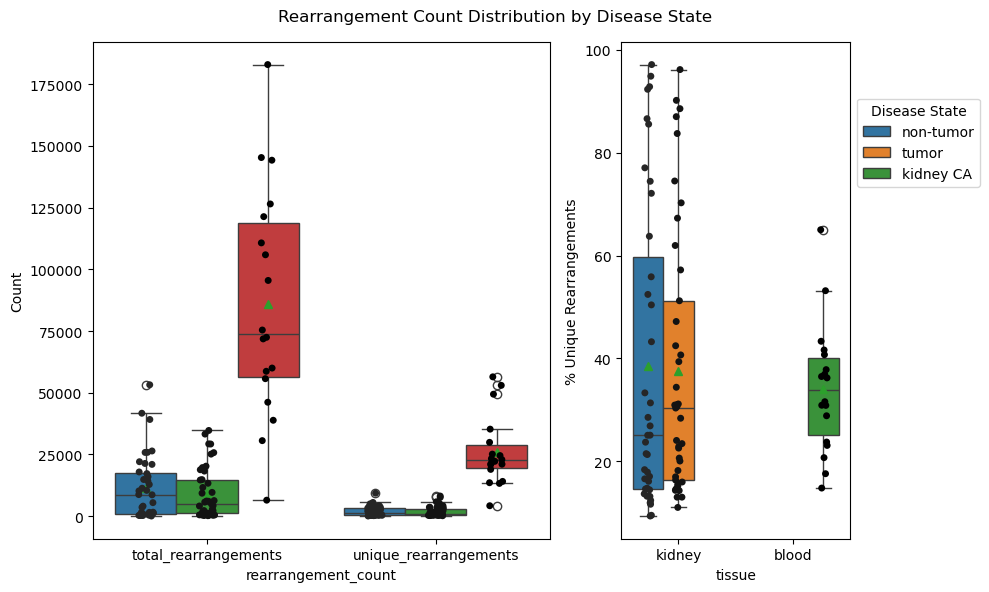

In [39]:
df = subject_info.copy()
df['% Unique'] = (df['unique_rearrangements'] / df['total_rearrangements']) * 100
df_melted = df.melt(
    id_vars = ['sample_id', 'disease_state'],
    value_vars = ['total_rearrangements', 'unique_rearrangements'],
    var_name = 'rearrangement_count',
    value_name = 'Count'
)

custom_palette = {
    'non-tumor': '#1f77b4',  # blue
    'tumor': '#2ca02c',  # green
    'kidney CA': '#d62728'   # red
}

hue_order = ['non-tumor', 'tumor', 'kidney CA']
order = ['non-tumor', 'tumor', 'kidney CA']
# # Create the boxplot
fig, ax = plt.subplots(1, 2, figsize = (10, 6), gridspec_kw={'width_ratios': [2, 1]},)

sns.boxplot(data = df_melted, x="rearrangement_count", y= 'Count', hue = 'disease_state', 
            showmeans = True, hue_order = hue_order, palette=custom_palette, legend = False, ax = ax[0])
sns.stripplot(data = df_melted, x="rearrangement_count", y= 'Count', hue = 'disease_state',
              legend = False, palette='dark:black', dodge = True, ax = ax[0])

sns.boxplot(data = df, x="tissue", y= '% Unique', hue = 'disease_state',  showmeans = True,legend = True, ax = ax[1])
sns.stripplot(data = df, x="tissue", y= '% Unique', hue = 'disease_state', dodge = True, palette='dark:black', legend = False, ax = ax[1])

ax[1].legend(title='Disease State', bbox_to_anchor=(1, 0.9), loc='upper left')


#remove legend from the first figure


ax[1].set_ylabel('% Unique Rearrangements')
plt.suptitle("Rearrangement Count Distribution by Disease State")

plt.tight_layout()
figname = fig_dir + 'boxplot_productive_cdr3_by_diagnosis.png'
# plt.savefig(figname, bbox_inches = 'tight', dpi = 300)
plt.show()


In [130]:
all_patient_files = {101: ['Thr_101_25516-1', 'Thr_101_25519-1', 'Thr_101_25516_9'],
 103: ['Thr_103_26277_1', 'Thr_103_26276-1', 'Thr_103_26277_3'],
 104: ['24673-6', '26473-1', '24563-5', 'lung_biopsy', 'O_weeks', '5_weeks', '5_weeks_2', '8_weeks', '17_weeks', '7_months', '30_months'],
 105: ['Thr_105_28473_3', 'Thr_105_28473_2H', 'Thr_105_28474-4', '105_0_week', '105_2_week', '105_3_month', '105_6_month'],
 106: ['Thr_106_30817-2', 'Thr_106_30818_1', 'Thr_106_30817_1', '106_0_week', '106_3_month', '106_6_month-1', '106_9_month'],
 107: ['Thr_107_31626-3', 'Thr_107_31627-1', 'Thr_107_31626_1', '107_0_week', '107_3_month']}

In [145]:
df1 = pd.read_csv('library 33 design.csv')
df1['sample_name'] = df1['sample name'] + '_' + df1[' code']
df1['sample_name'] = df1['sample_name'].str.replace(" ", "")
df1.to_csv('library_33.csv')

In [146]:
df1 = pd.read_csv('library 34 design.csv')
df1['sample_name'] = df1['sample name'] + '_' + df1[' code']
df1['sample_name'] = df1['sample_name'].str.replace(" ", "")
df1.to_csv('library_34.csv')

In [ ]:
Thr_101_25516-1
Thr_101_25516_9
Thr_101_25519-1

Thr_103_26276-1
Thr_103_26277_1
Thr_103_26277_3

